In [1]:
import torch
import matplotlib.pyplot as plt
import tensorly
from tensorly.decomposition import tucker
import numpy as np
import time


tensorly.set_backend("pytorch")
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def generate_tensor(
    C_out=512, C_in=256, k_h=3, k_w=3, pruning_rate=0.5, noise_amplitude=0.01
):
    """
    Generate a tensor with specified dimensions.

    Args:
        C_out (int): Number of output channels.
        C_in (int): Number of input channels.
        k_h (int): Height of the kernel.
        k_w (int): Width of the kernel.
        pruning_rate (float): Pruning rate, ranging from 0 to 1.
        noise_amplitude (float): Amplitude of the noise.

    Returns:
        torch.Tensor: Generated tensor.
    """
    # Calculate the number of channels to keep after pruning
    num_channels_to_keep = round(C_out * (1 - pruning_rate))

    # Initialize tensor with random values for the first part
    tensor = torch.randn(num_channels_to_keep, C_in, k_h, k_w)

    # Calculate the number of channels to copy
    num_channels_to_copy = C_out - num_channels_to_keep

    # Copy values from the first part and add noise
    for i in range(0, num_channels_to_copy, num_channels_to_keep):
        end_index = min(num_channels_to_keep, num_channels_to_copy - i)
        tensor = torch.cat(
            (
                tensor,
                tensor[:end_index]
                + noise_amplitude * torch.randn_like(tensor[:end_index]),
            )
        )

    return tensor

In [3]:
def compute_multilinear_singular_values(tensor):
    """
    Decompose `tensor` with full-rank HOSVD.
    Compute multilinear_singular_values via Frobenius Norm of each slice of the `core` tensor.
    """
    core, _ = tucker(tensor, rank=tensor.shape)
    multilinear_singular_values = torch.norm(core.reshape(tensor.size(0), -1), dim=1)

    return multilinear_singular_values


# def compute_singular_values(tensor):
#     """
#     Reshape `tensor` to 2 dimensions and return its singular values.
#     """
#     reshaped_tensor = tensor.view(tensor.size(0), -1)
#     _, singular_values, _ = torch.linalg.svd(reshaped_tensor)

#     return singular_values


def spectral_norm(tensor):
    """
    Compute the spectral norm of a given tensor.

    Parameters:
    - tensor: torch.Tensor

    Returns:
    - spectral_norm_value: float
    """
    reshaped_tensor = tensor
    if tensor.dim() > 2:
        # If tensor has more than 2 dimensions, reshape it to have 2 dimensions
        reshaped_tensor = tensor.view(tensor.size(0), -1)

    singular_values = torch.linalg.svdvals(reshaped_tensor)
    max = torch.max(singular_values)

    return max.item()


def frobenius_norm(tensor):
    """
    Compute the frobenius norm of a given tensor.

    Parameters:
    - tensor: torch.Tensor

    Returns:
    - frobenius_norm_value: float
    """
    reshaped_tensor = tensor
    if tensor.dim() > 2:
        # If tensor has more than 2 dimensions, reshape it to have 2 dimensions
        reshaped_tensor = tensor.view(tensor.size(0), -1)

    return torch.norm(reshaped_tensor, p="fro").item()


def nuclear_norm(tensor):
    """
    Compute the nuclear norm of a given tensor.

    Parameters:
    - tensor: torch.Tensor

    Returns:
    - nuclear_norm_value: float
    """
    if tensor.dim() > 2:
        # If tensor has more than 2 dimensions, reshape it to have 2 dimensions
        reshaped_tensor = tensor.view(tensor.size(0), -1)
        return torch.norm(reshaped_tensor, p="nuc").item()
    else:
        return torch.norm(tensor, p="nuc").item()


def rank(tensor):
    """
    Compute the rank of a given tensor.

    Parameters:
    - tensor: torch.Tensor

    Returns:
    - rank: int
    """
    if tensor.dim() > 2:
        # If tensor has more than 2 dimensions, reshape it to have 2 dimensions
        reshaped_tensor = tensor.view(tensor.size(0), -1)
        return torch.linalg.matrix_rank(reshaped_tensor).item()
    else:
        return torch.linalg.matrix_rank(tensor).item()

In [4]:
def visualize_singular_values(singular_values, name="Original"):
    plt.figure(dpi=500)
    # Plotting singular values for each layer
    for i, sv in enumerate(singular_values):
        layer_number = i + 1  # Adjust for 1-based indexing
        plt.plot(sv, label=f"Layer {layer_number}")

    # Adding labels and legend
    plt.xlabel("Index")
    plt.ylabel("Multilinear Singular Value")
    # plt.title(
    #     f"Multilinear Singular Values of L={len(singular_values)} Layers"
    # )  # , {name}')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_values(input_list, title):
    """
    Plot a vertical bar chart for the input list.

    Parameters:
    - input_list: List of integers or floats.
    - title: Title of the plot.

    Returns:
    None
    """
    input_list = np.round(input_list, decimals=2)
    x_values = np.arange(1, len(input_list) + 1)

    plt.figure(dpi=500)
    plt.bar(x_values, input_list)
    plt.xlabel("Layer index")
    plt.ylabel("Value")
    plt.title(f"N={len(input_list)} layers, " + title)
    for i, value in enumerate(input_list):
        plt.text(x_values[i], value, f"{value}", ha="center", va="bottom")

    plt.show()


def inspect_layers(layers, name="groundtruth, pruned"):
    """
    Compute singular values, nuclear norms and visualize SVs for a list of layers

    Parameters:
    - layers: list of torch.Tensor, list of layer tensors

    Returns:
    - singular_values: list of torch.Tensor, list of singular_value
    - nuclear_norms: list of float, list of nuclear_norm
    """
    singular_values = []
    nuclear_norms = []
    ranks = []
    for i, layer in enumerate(layers):
        # print(f"Current layer: {i + 1}")
        singular_value = compute_multilinear_singular_values(layer)
        singular_values.append(singular_value)
        current_nuclear_norm = nuclear_norm(layer)
        nuclear_norms.append(current_nuclear_norm)
        # print(f'groundtruth nuclear norm = {current_nuclear_norm}')
        current_rank = rank(layer)
        ranks.append(current_rank)
        # print(f'groundtruth rank = {current_rank}')
    visualize_singular_values(singular_values, name=name)
    plot_values(nuclear_norms, title="nuclear norms, " + name)
    plot_values(ranks, title="ranks, " + name)
    print(f"np.sum(nuclear_norms) {sum(nuclear_norms)}")

    return singular_values, nuclear_norms, ranks

In [5]:
def reset_data(N=5):
    channels = [64, 128, 256, 512, 512]

    pruning_rates = list(np.arange(0.25, 0.99, 0.05))

    # Initialize C_in for the first layer
    C_in = 32

    # Initialize a list to store the generated tensors
    vgg_layers = []

    # Loop over the channels and pruning_rates
    for C_out, pruning_rate in zip(channels, pruning_rates):
        # Generate tensor for the current layer
        layer_tensor = generate_tensor(
            C_out=C_out, C_in=C_in, pruning_rate=pruning_rate, noise_amplitude=0.0
        )

        # Update C_in for the next layer
        C_in = C_out

        # Append the generated tensor to the list
        vgg_layers.append(layer_tensor)

    # Display the generated tensors
    for i, layer_tensor in enumerate(vgg_layers):
        print(f"Layer {i + 1}: {layer_tensor.shape}")

    # Number of layers
    channels = channels[:N]
    vgg_layers = vgg_layers[:N]
    pruning_rates = pruning_rates[:N]

    singular_values, nuclear_norms, ranks = inspect_layers(vgg_layers, name="original")

    # Total number of original channels
    total_original_channels = np.sum(channels)

    # Calculate the absolute number of channels to remove for each layer
    channels_to_remove = [round(pr * ch) for pr, ch in zip(pruning_rates, channels)]

    # Calculate the sum of the absolute number of channels to remove
    total_channels_to_remove = np.sum(channels_to_remove)

    # Calculate the absolute number of channels to keep for each layer
    gt_channels_to_keep = [
        round((1 - pr) * ch) for pr, ch in zip(pruning_rates, channels)
    ]

    total_channels_to_keep = total_original_channels - total_channels_to_remove

    print("Total Original Channels:", total_original_channels)
    print("Total Channels to Remove:", total_channels_to_remove)
    print(f"Total Channels to Keep: {total_channels_to_keep}")

    print(f"Groundtruth channels_to_keep = {gt_channels_to_keep}")

    return (
        singular_values,
        channels,
        vgg_layers,
        total_original_channels,
        channels_to_remove,
        total_channels_to_keep,
        gt_channels_to_keep,
    )

Layer 1: torch.Size([64, 32, 3, 3])
Layer 2: torch.Size([128, 64, 3, 3])
Layer 3: torch.Size([256, 128, 3, 3])
Layer 4: torch.Size([512, 256, 3, 3])
Layer 5: torch.Size([512, 512, 3, 3])


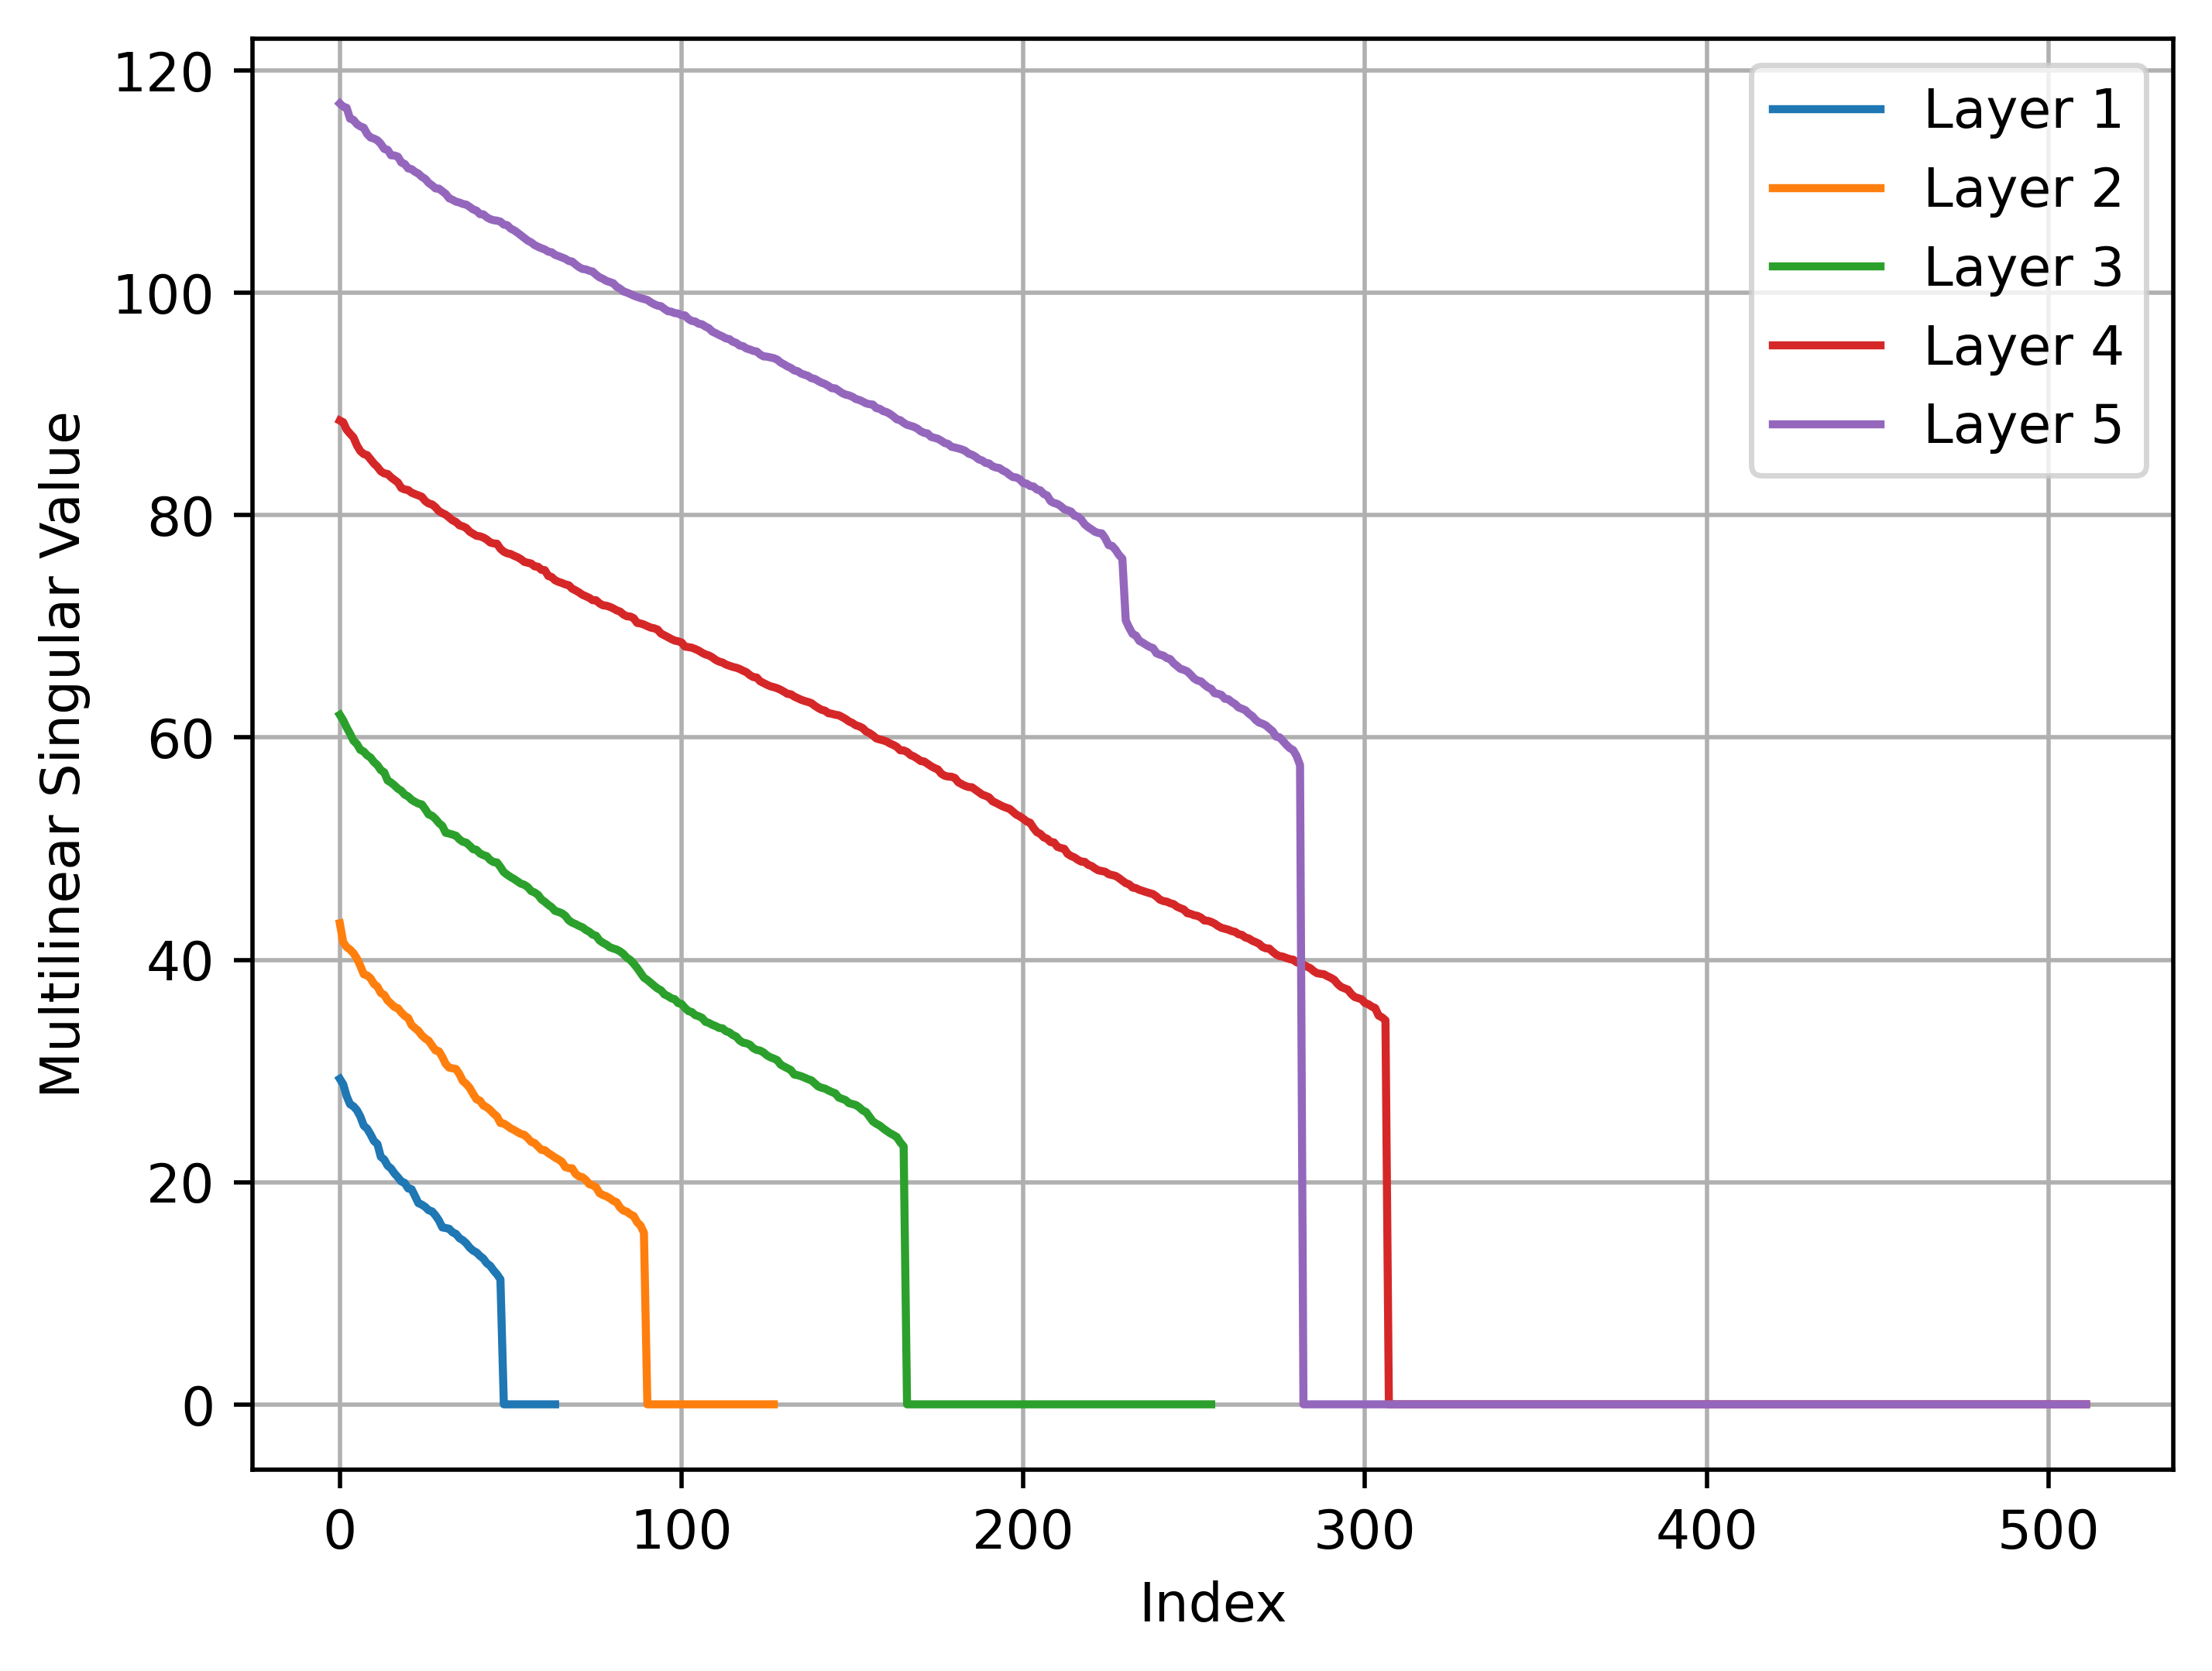

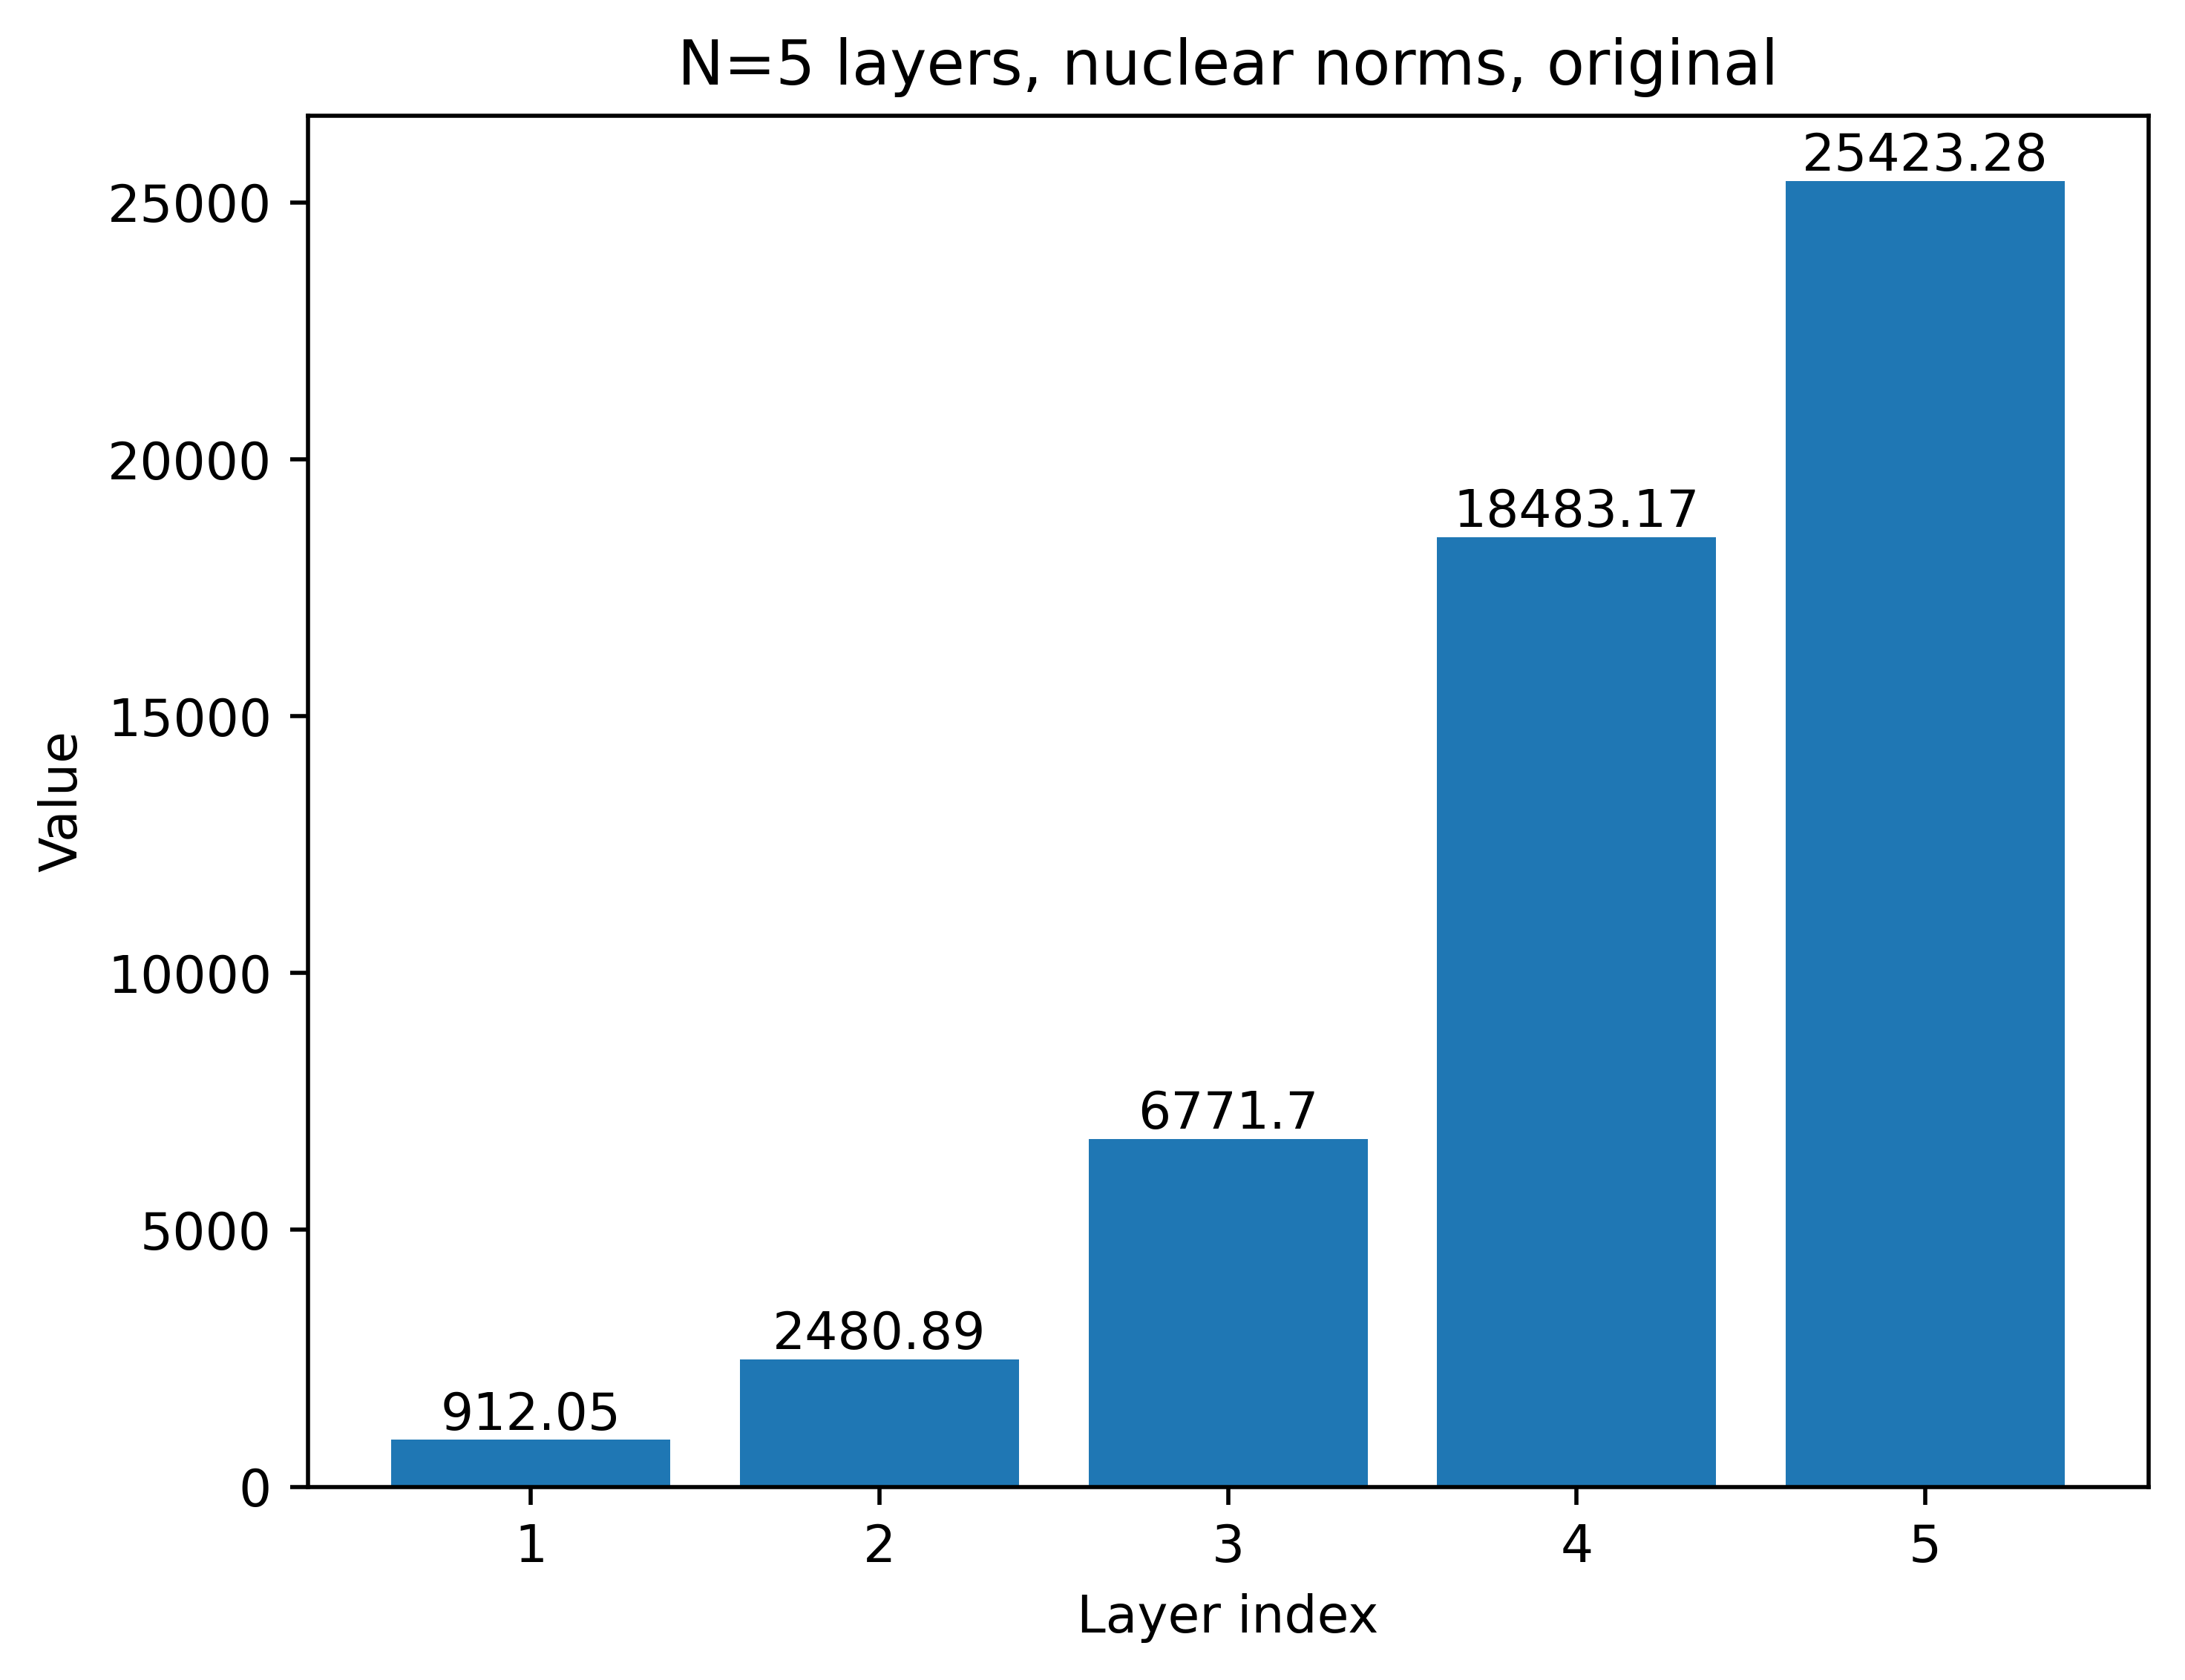

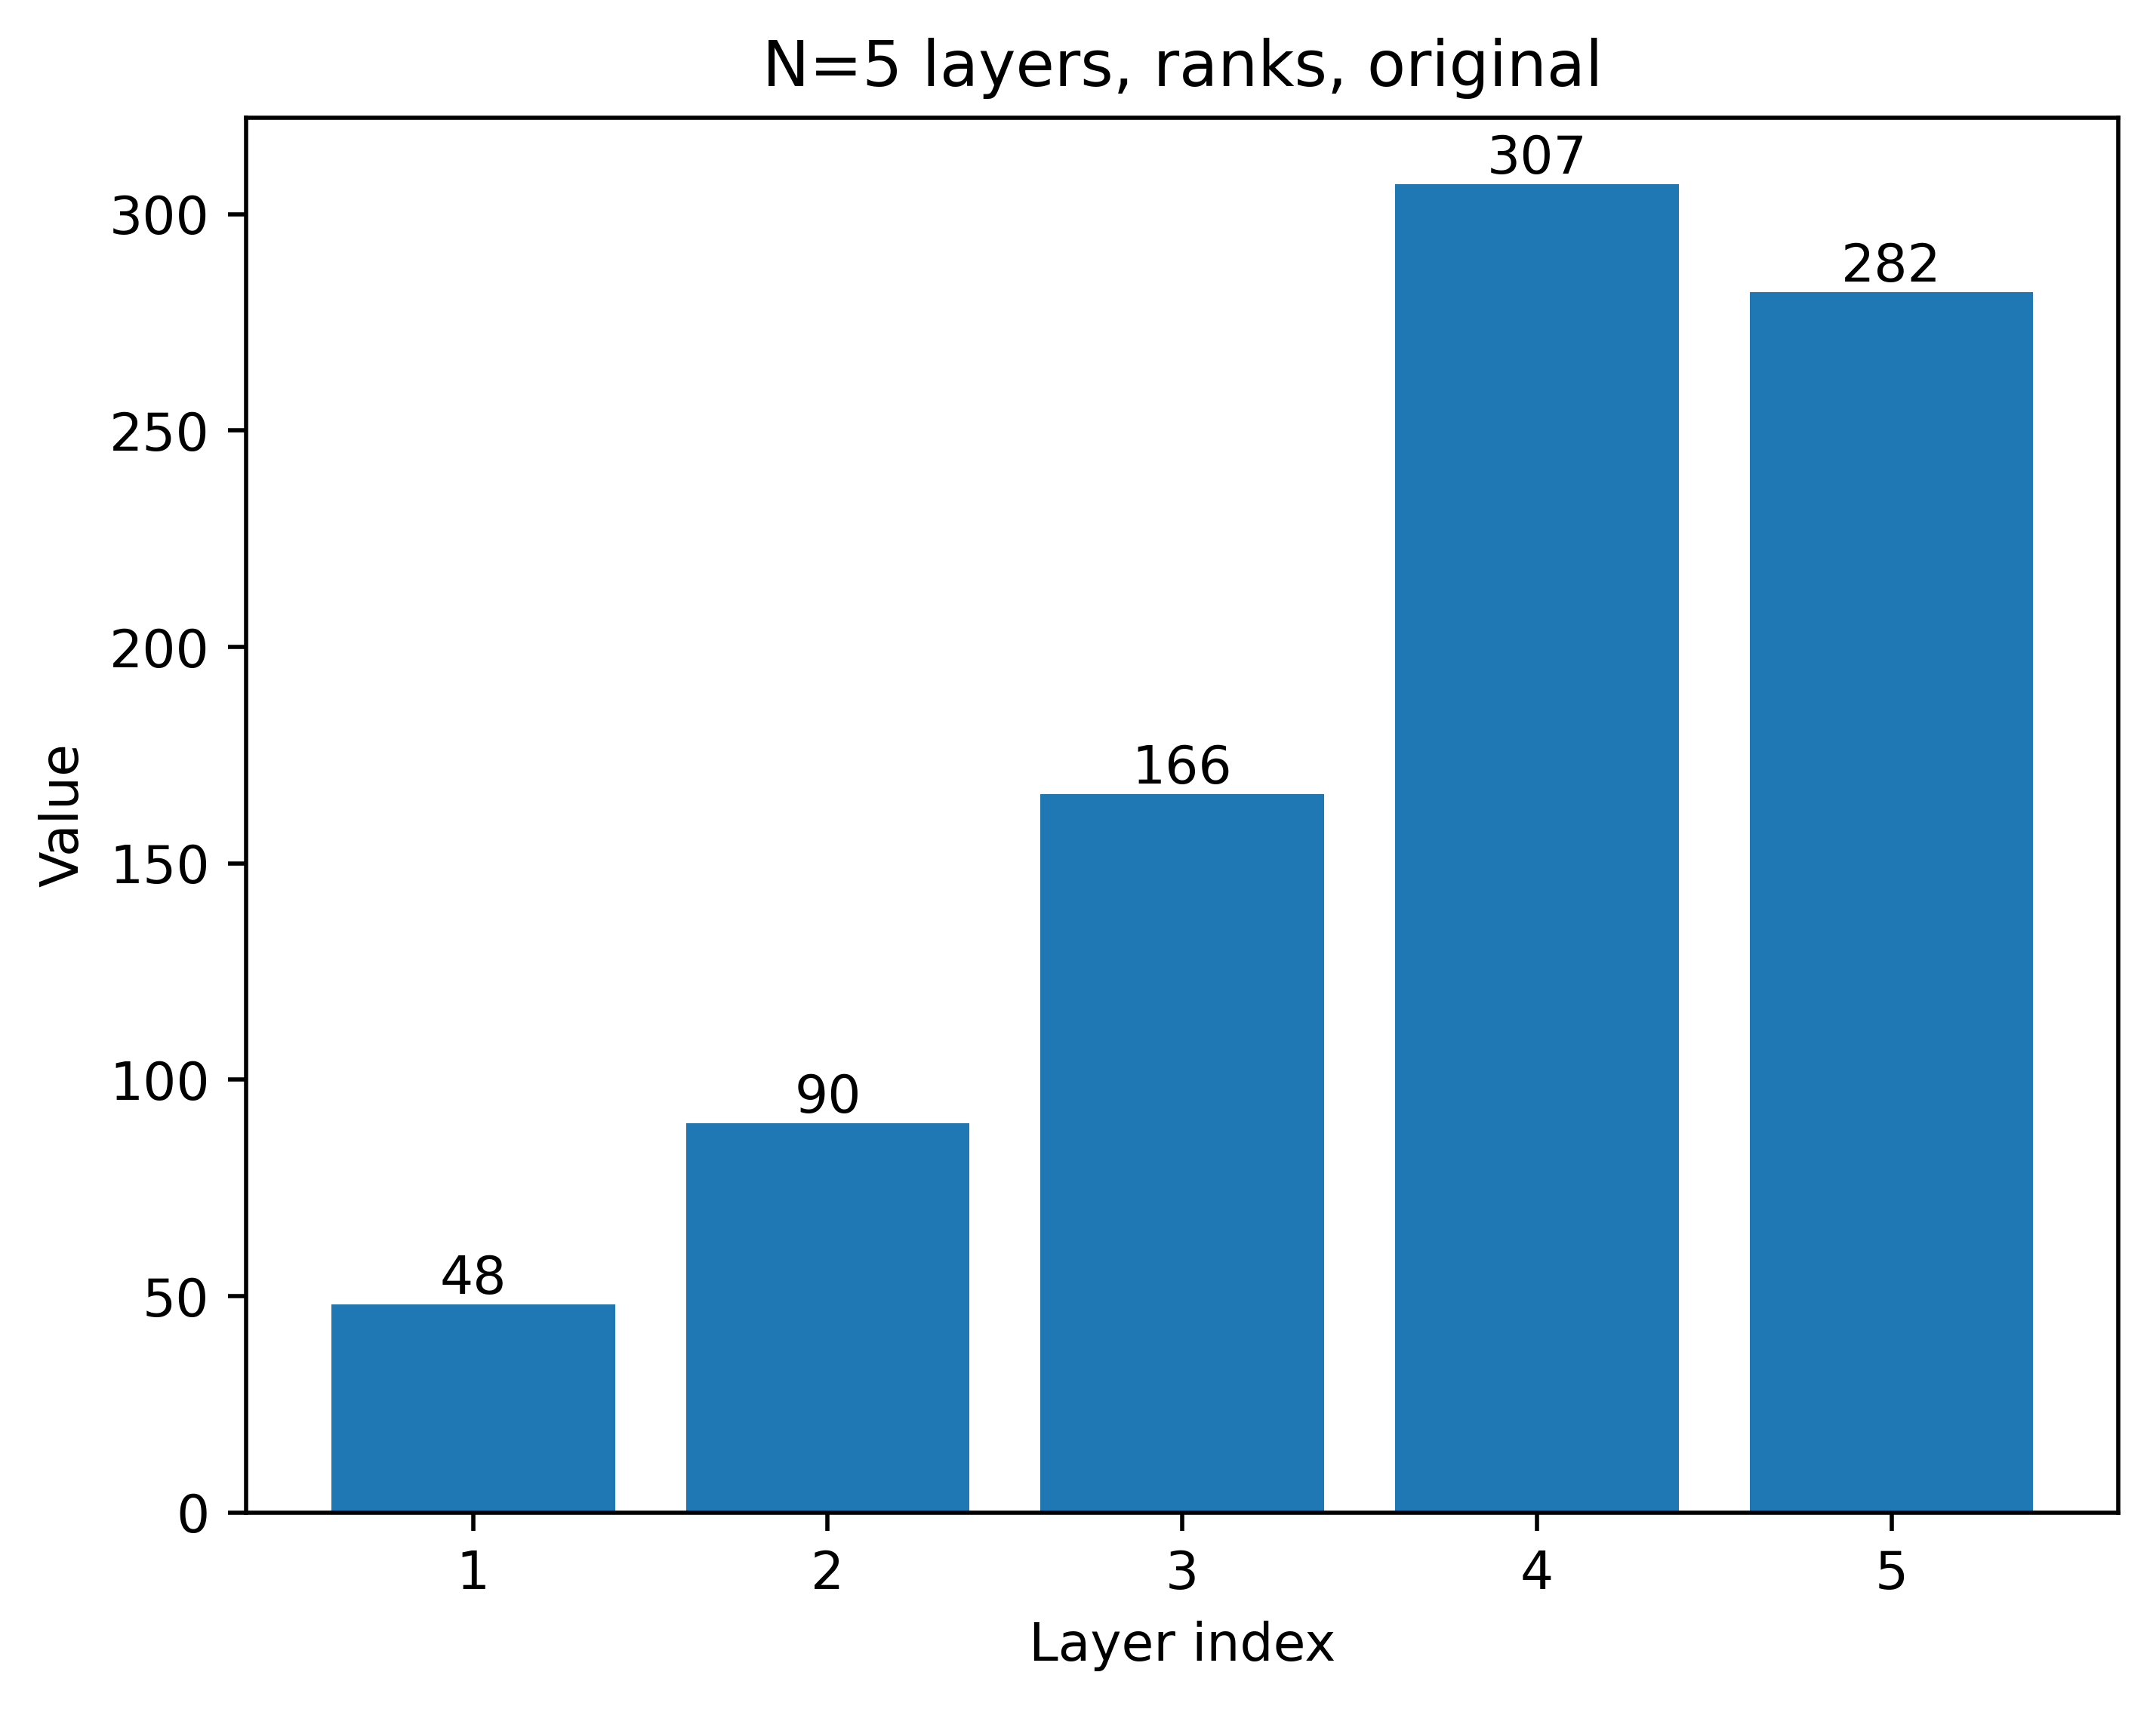

np.sum(nuclear_norms) 54071.08996582031
Total Original Channels: 1472
Total Channels to Remove: 579
Total Channels to Keep: 893
Groundtruth channels_to_keep = [48, 90, 166, 307, 282]


In [6]:
(
    singular_values,
    channels,
    vgg_layers,
    total_original_channels,
    channels_to_remove,
    total_channels_to_keep,
    gt_channels_to_keep,
) = reset_data()

### Latex stuffs

In [7]:
def export_singular_values(singular_values, prefix="layer"):
    # Write each array to a separate file
    for i, sv in enumerate(singular_values):
        filename = f"{prefix}{i+1}.txt"
        with open(filename, "w") as f:
            for j, val in enumerate(sv):
                f.write(f"{j+1} {val}\n")

In [8]:
export_singular_values(singular_values)

In [9]:
def find_optimal_channels(singular_values, total_channels_to_keep):
    start_time = time.time()

    num_layers = len(singular_values)
    number_of_channels_to_keep = [0] * num_layers
    current_singular_values_candidates = np.array(
        [singular_value[0] for singular_value in singular_values]
    )
    for i in range(total_channels_to_keep):
        max_idx = np.argmax(current_singular_values_candidates)
        number_of_channels_to_keep[max_idx] += 1
        current_singular_values_candidates[max_idx] = singular_values[max_idx][
            number_of_channels_to_keep[max_idx]
        ]

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution Time: {execution_time} seconds")

    return number_of_channels_to_keep, execution_time


# Assuming singular_values, total_channels_to_keep, and channels are defined
optimal_channels, execution_time = find_optimal_channels(
    singular_values, total_channels_to_keep
)
print("Optimal Channels to Keep:", optimal_channels)
assert (
    optimal_channels == np.array(gt_channels_to_keep)
).all(), f"Prediction {optimal_channels} differs from groundtruth {gt_channels_to_keep}"
print("Prediction = Groundtruth, test passed")

Execution Time: 0.0021390914916992188 seconds
Optimal Channels to Keep: [48, 90, 166, 307, 282]
Prediction = Groundtruth, test passed


## Ground-truth

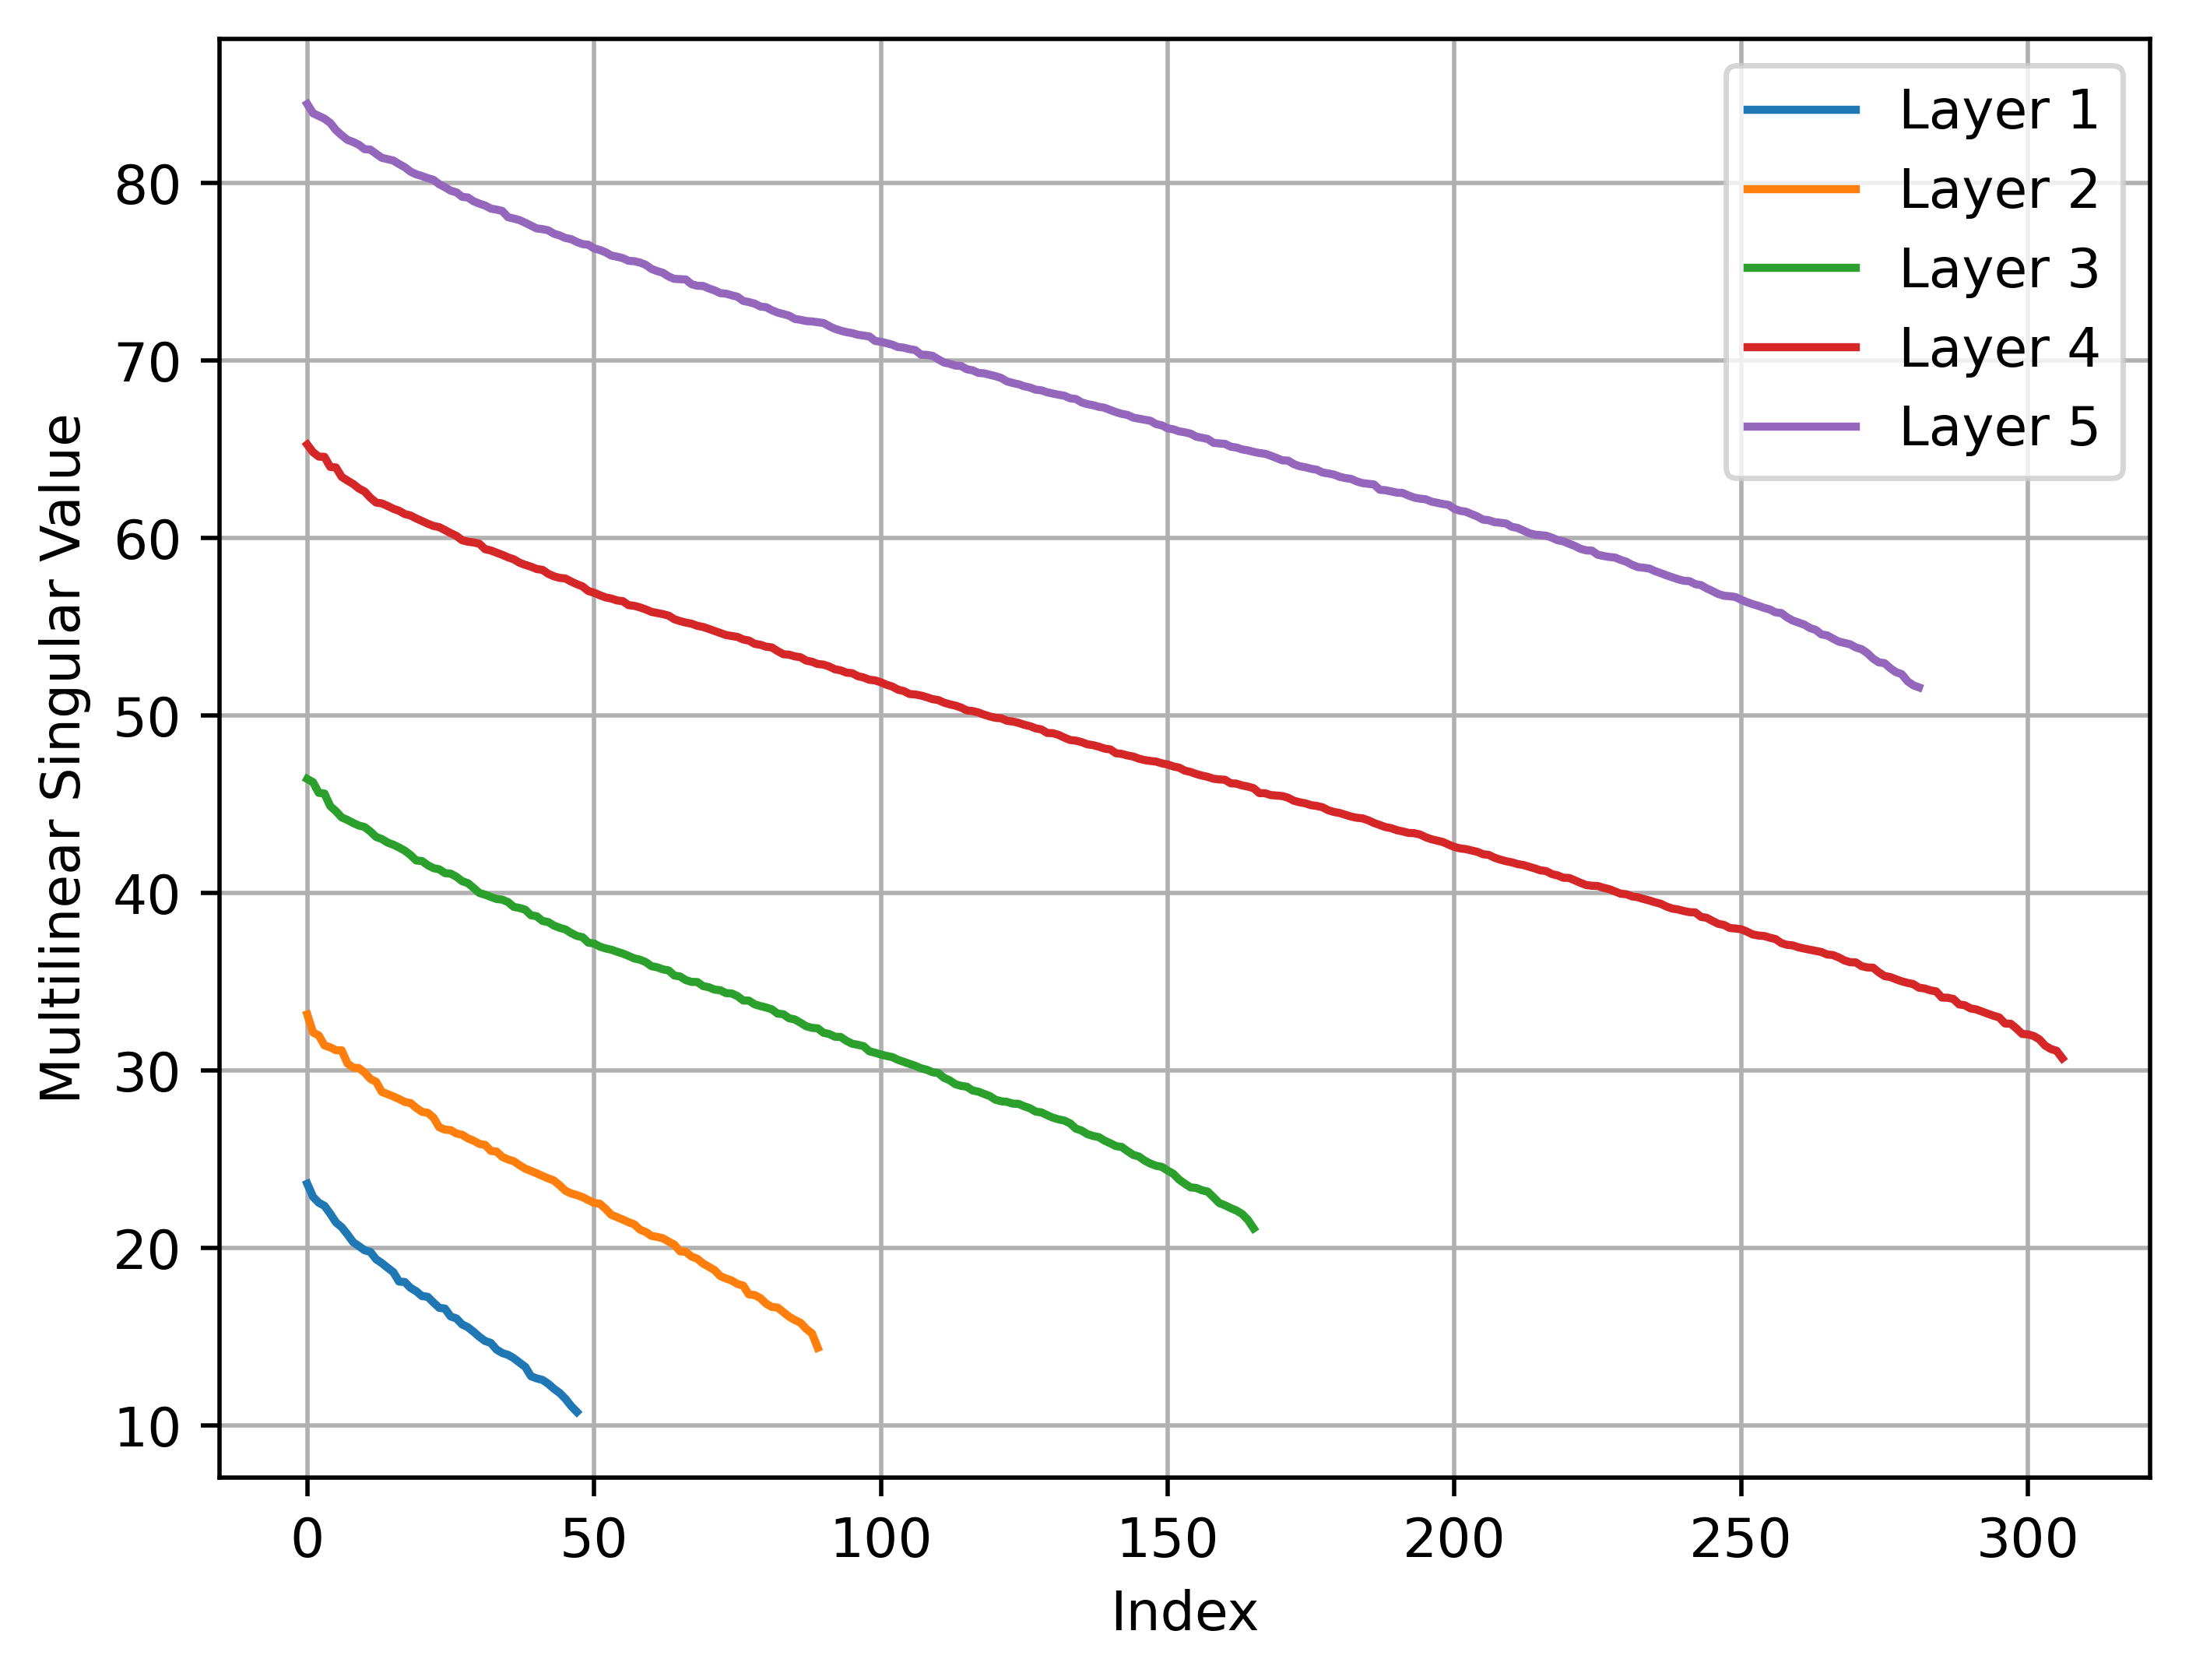

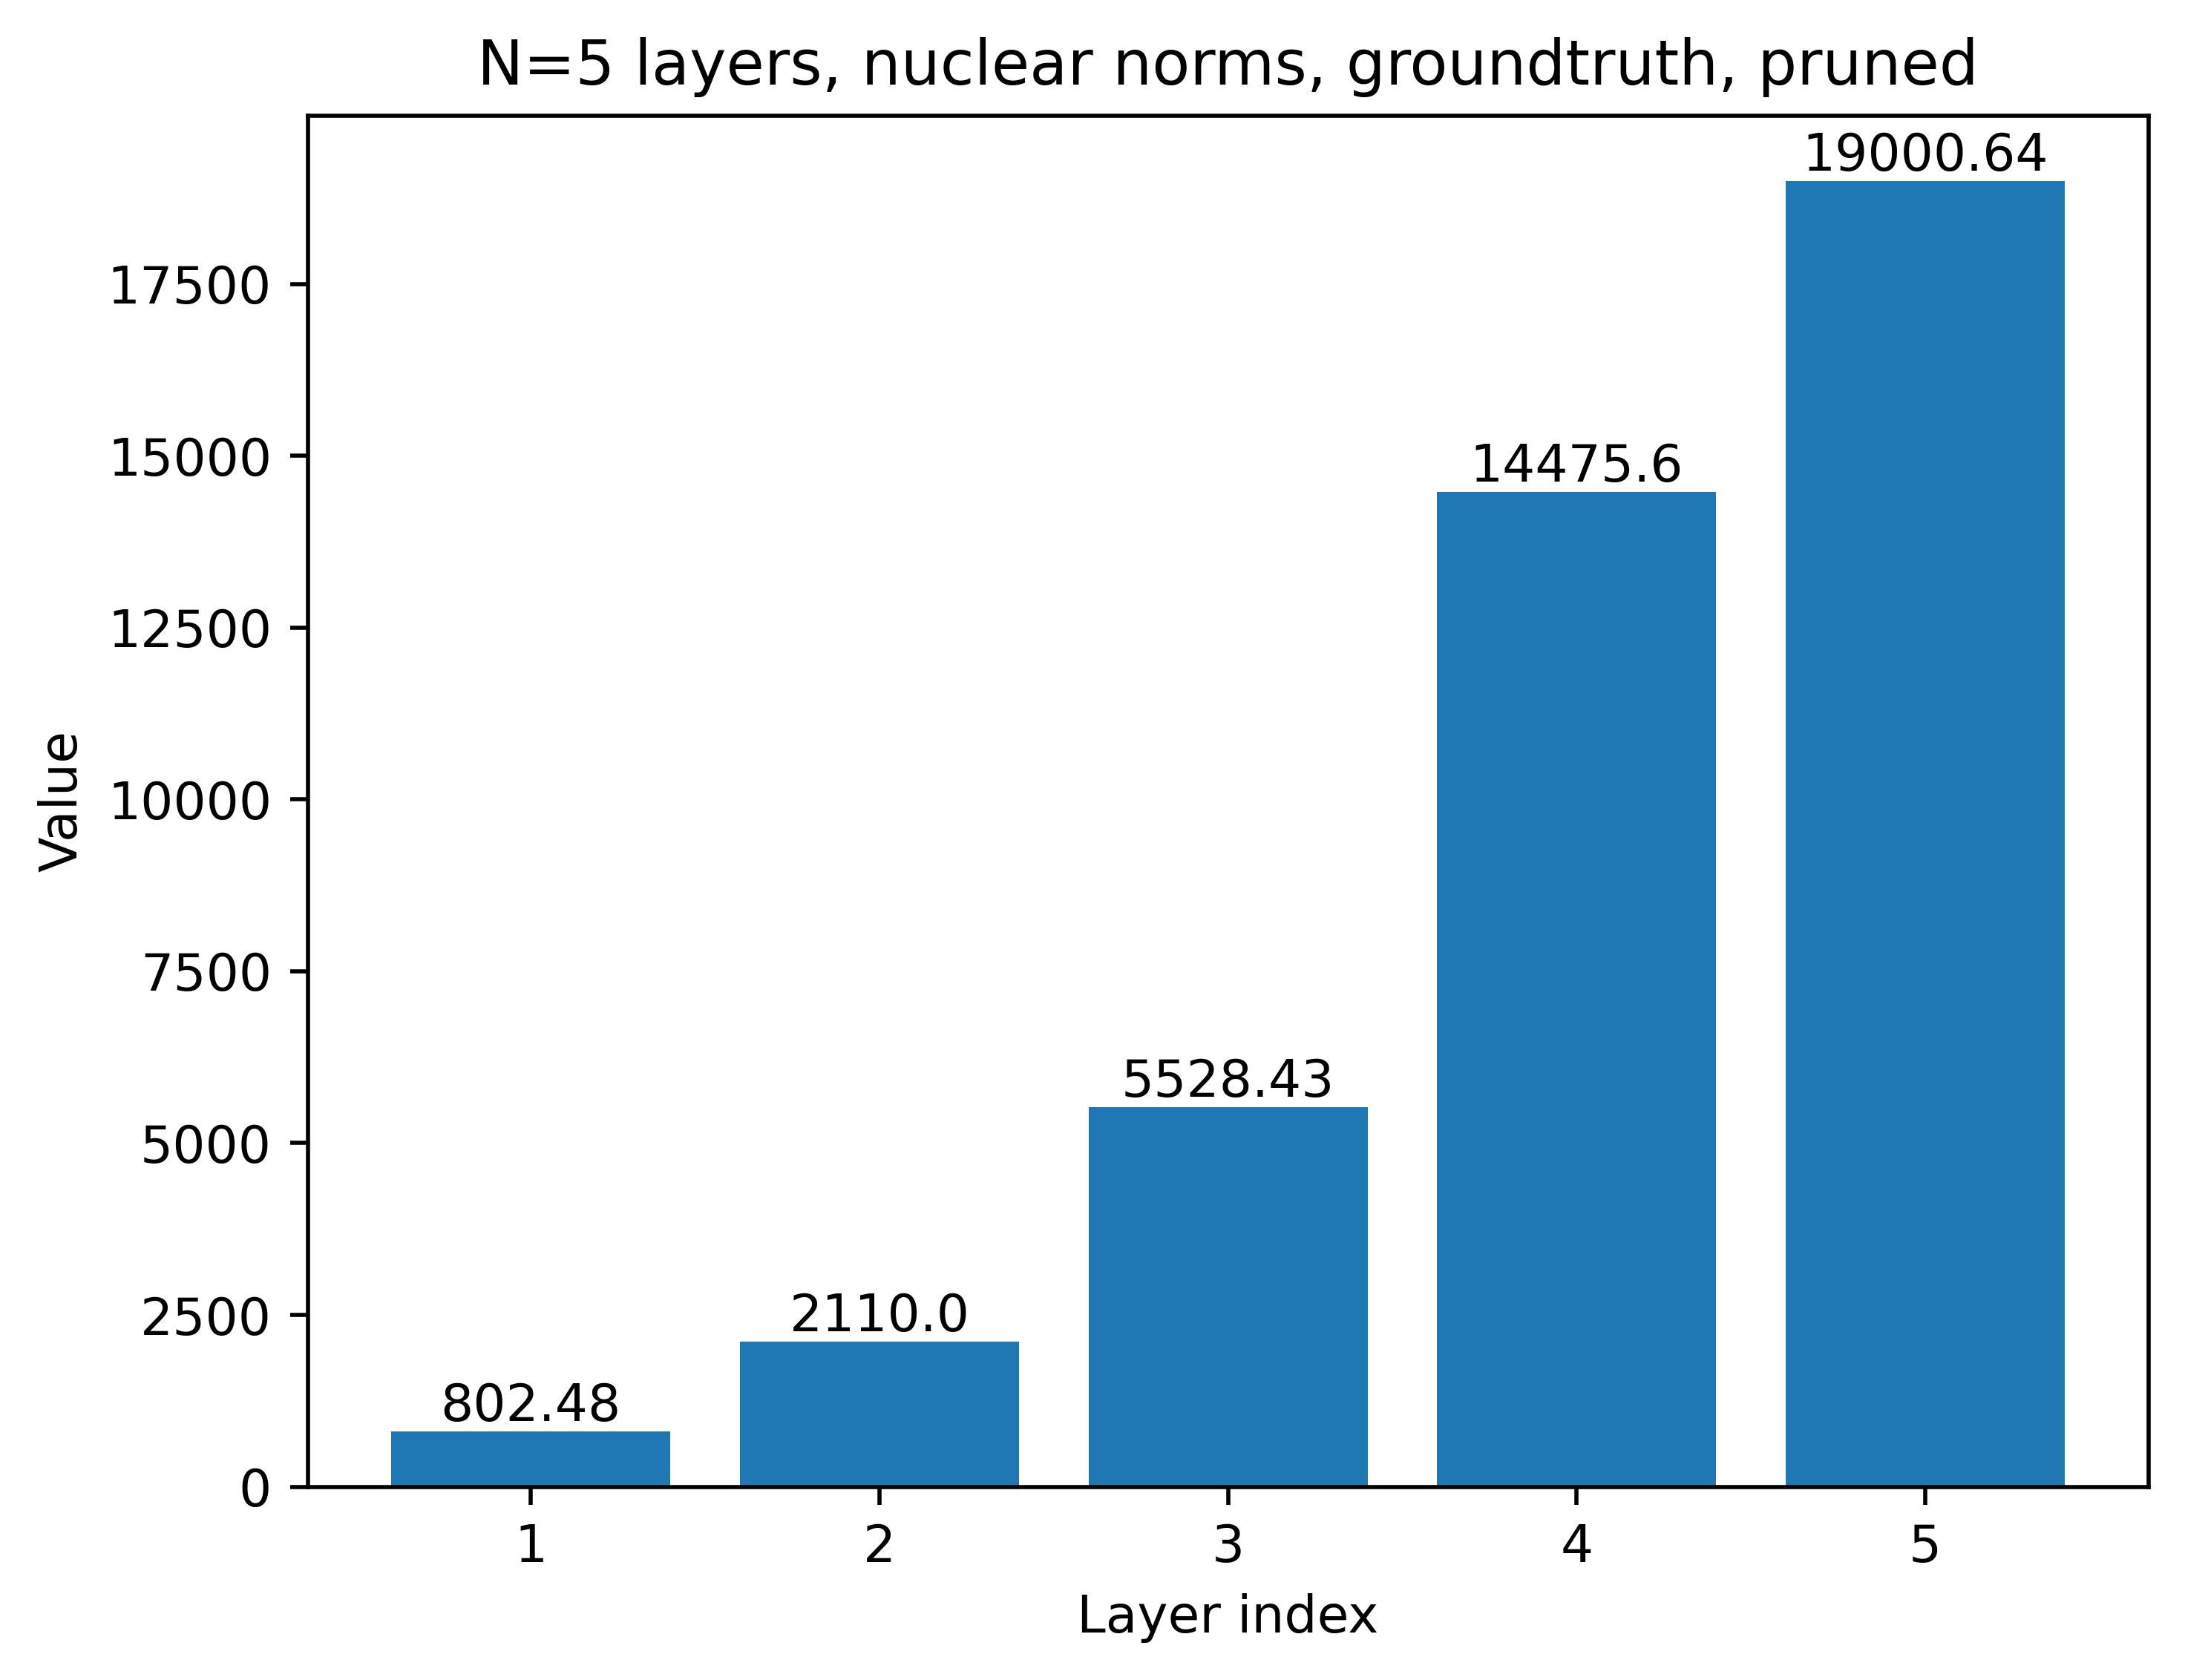

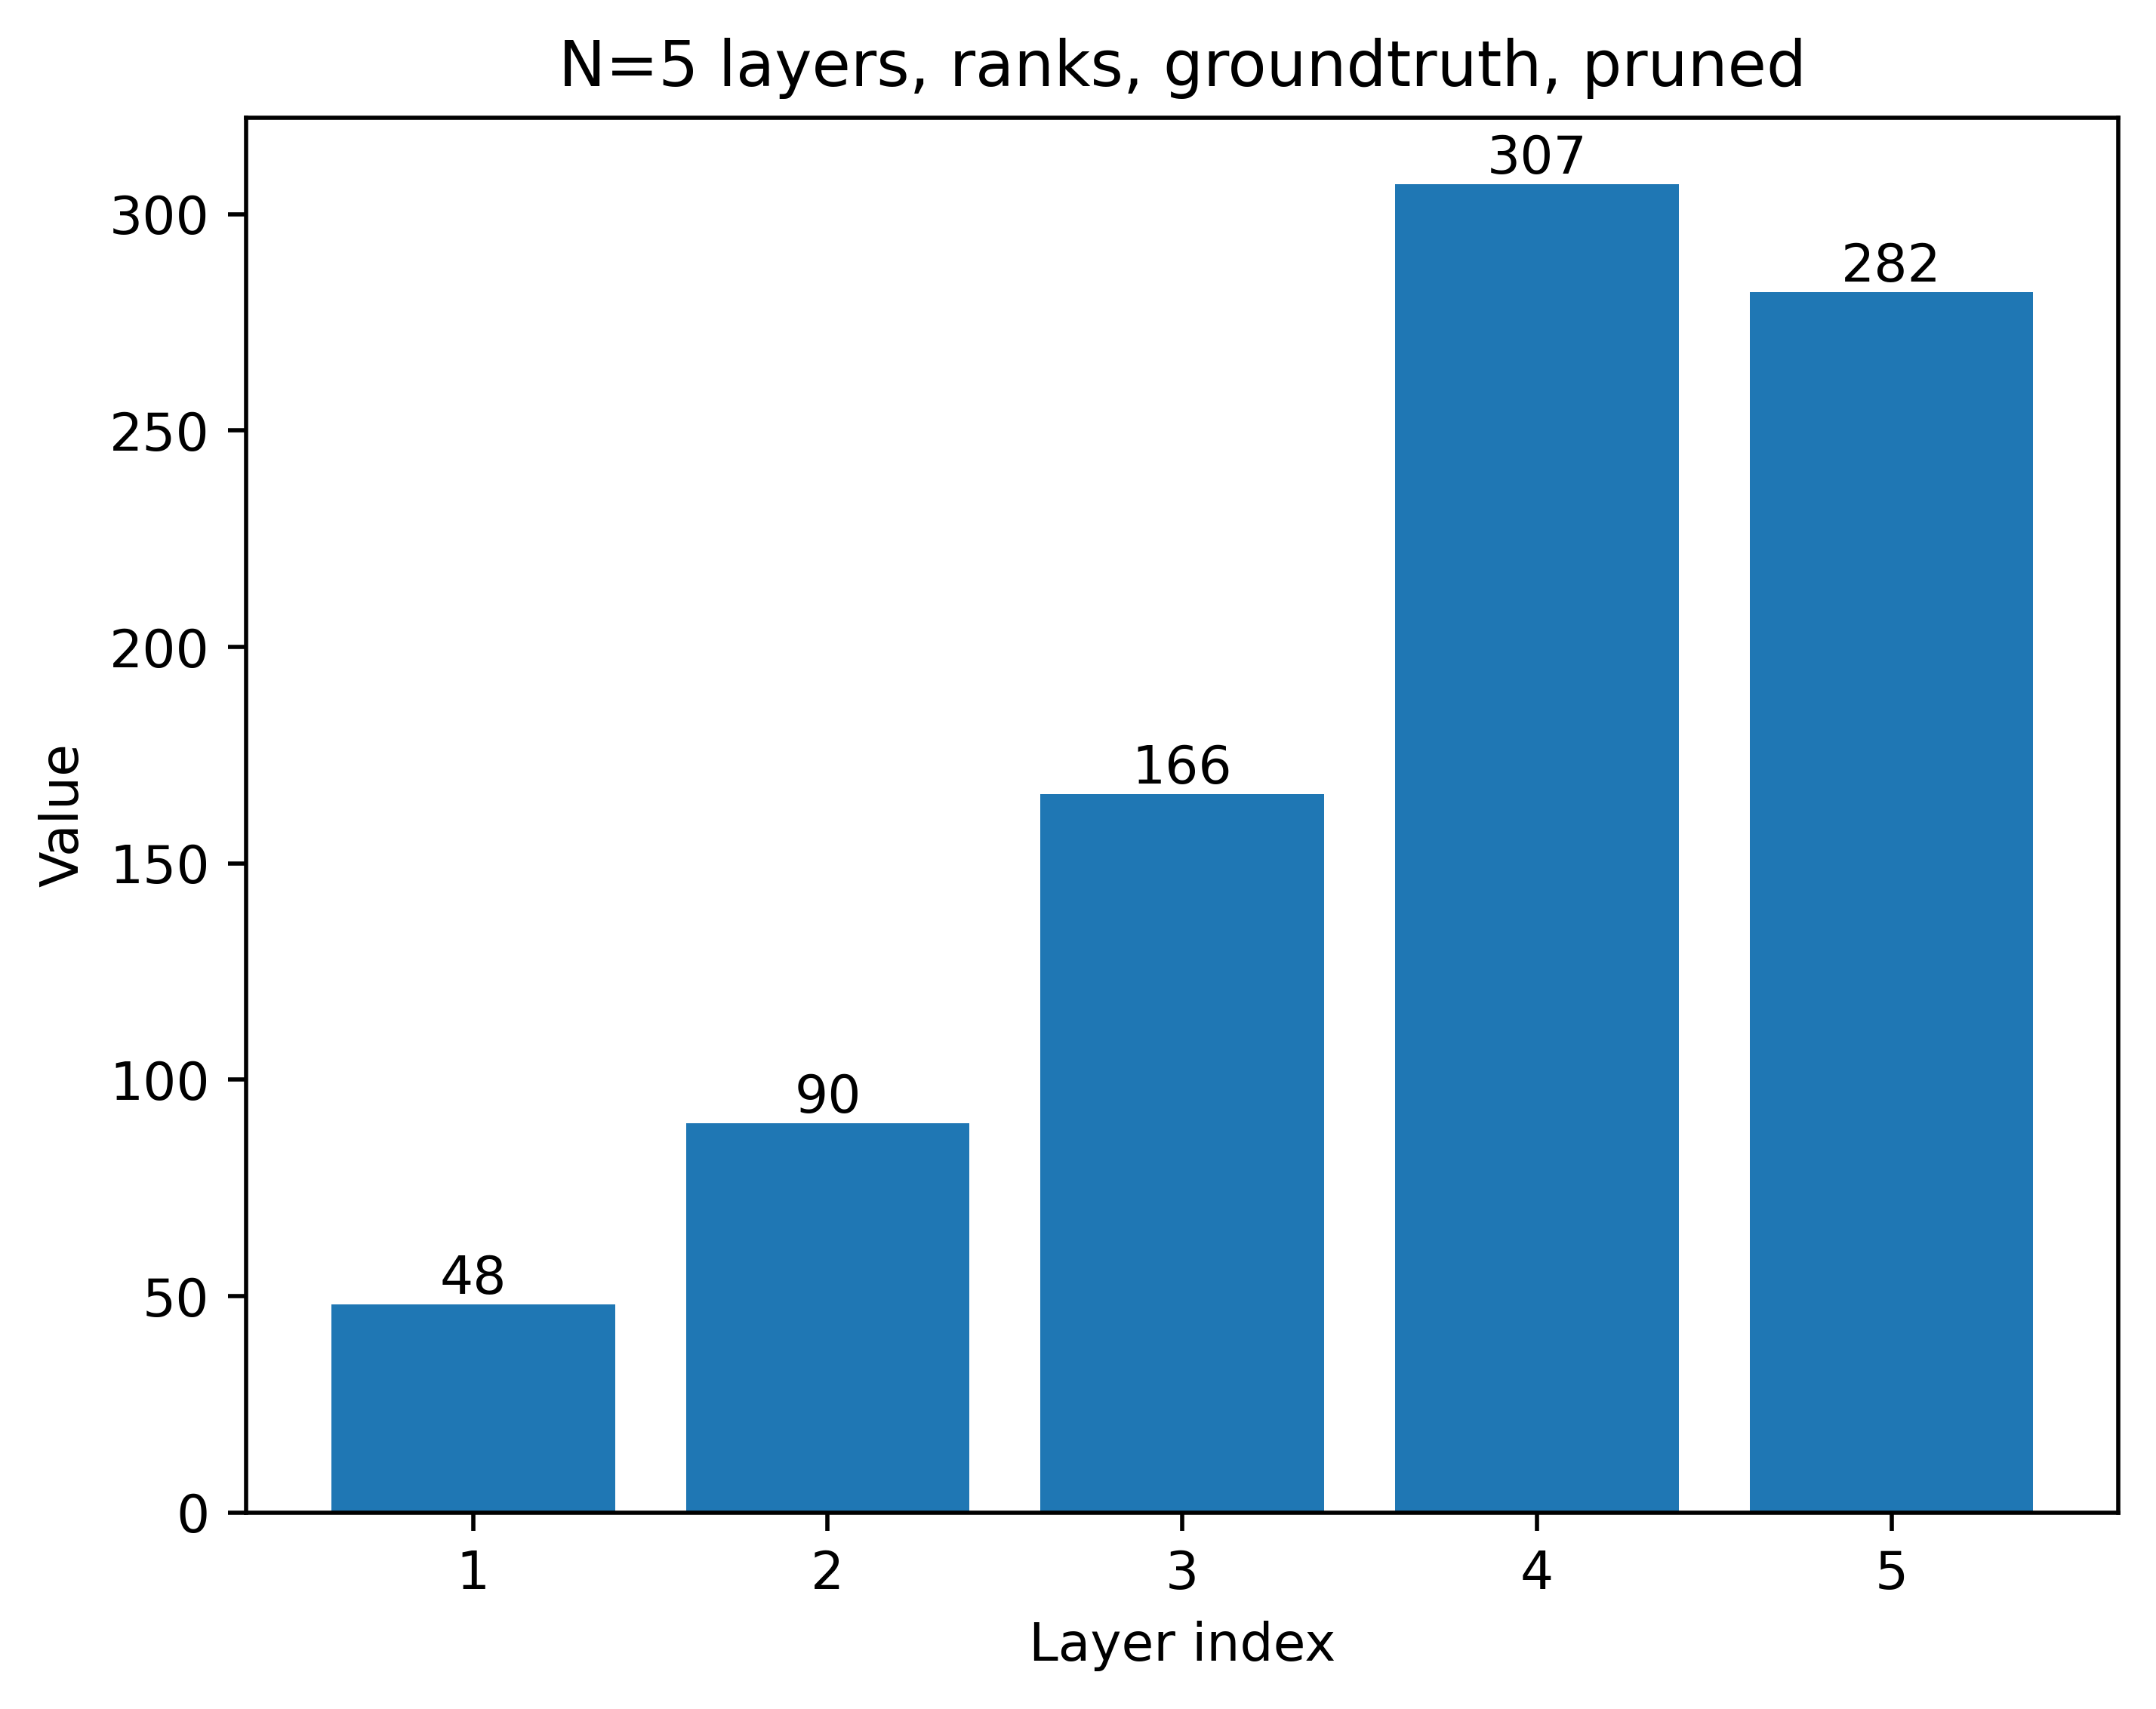

np.sum(nuclear_norms) 41917.15100097656


In [10]:
gt_layers = [
    layer[:num_centroids]
    for (layer, num_centroids) in zip(vgg_layers, optimal_channels)
]
gt_singular_values, gt_nuclear_norms, gt_ranks = inspect_layers(gt_layers)

## Random Search

In [11]:
import numpy as np
import math


def random_search_layer(layer_tensor, num_centroids, num_trials=1000):
    """
    Apply a random search strategy to a layer tensor.

    Parameters:
    - layer_tensor: torch.Tensor, shape (Cout, Cin, k, k)
    - num_centroids: int, number of centroids (filters) to keep
    - num_trials: int, number of random trials

    Returns:
    - best_layer_tensor: torch.Tensor, shape (num_centroids, Cin, k, k)
    - best_nuclear_norm: float, nuclear norm of the best configuration
    """

    best_layer_tensor = None
    best_nuclear_norm = float("-inf")

    # Calculate the number of trials based on the rate
    # num_trials = int(layer_tensor.size(0) * trial_rate)

    # Randomly select a subset for trials
    selected_combinations = set()

    while len(selected_combinations) < min(
        num_trials, math.comb(layer_tensor.size(0), num_centroids)
    ):
        # Generate a random combination
        random_combination = tuple(
            np.random.choice(layer_tensor.size(0), size=num_centroids, replace=False)
        )

        # Check if it's not in the set already
        if random_combination not in selected_combinations:
            selected_combinations.add(random_combination)

            # Create a new layer tensor with selected centroids
            new_layer_tensor = layer_tensor[list(random_combination)]

            # Calculate nuclear norm
            current_nuclear_norm = nuclear_norm(new_layer_tensor)

            # Update if the current configuration has a higher nuclear norm
            if current_nuclear_norm > best_nuclear_norm:
                best_nuclear_norm = current_nuclear_norm
                best_layer_tensor = new_layer_tensor
                best_configuration = random_combination

    return best_layer_tensor, best_nuclear_norm, best_configuration


def apply_random_search_to_layers(vgg_layers, optimal_channels, num_trials=1000):
    """
    Apply random search strategy to each layer in vgg_layers based on the optimal_channels.

    Parameters:
    - vgg_layers: list of torch.Tensor, list of layer tensors
    - optimal_channels: list, number of filters to keep in each layer
    - num_trials: int, number of random trials

    Returns:
    - best_vgg_layers: list of torch.Tensor, list of layer tensors after random search
    - best_nuclear_norms: list of floats, nuclear norm of the best configuration in each layer
    """

    best_vgg_layers = []
    best_nuclear_norms = []
    print(
        f"number of layers = {len(vgg_layers)}, target configuration = {optimal_channels}"
    )

    for i, (layer_tensor, num_centroids) in enumerate(
        zip(vgg_layers, optimal_channels)
    ):
        print(f"Current layer: {i + 1}")
        best_layer_tensor, best_nuclear_norm, best_configuration = random_search_layer(
            layer_tensor, num_centroids, num_trials
        )
        gt_nuclear_norm = nuclear_norm(layer_tensor[:num_centroids])
        print(
            f"groundtruth nuclear norm = {gt_nuclear_norm}, prediction nuclear norm = {best_nuclear_norm}"
        )
        print(
            f"groundtruth configuration = 0 .. {num_centroids-1}, prediction configuration ={best_configuration}"
        )
        best_vgg_layers.append(best_layer_tensor)
        best_nuclear_norms.append(best_nuclear_norm)

    return best_vgg_layers, best_nuclear_norms

number of layers = 5, target configuration = [48, 90, 166, 307, 282]
Current layer: 1
groundtruth nuclear norm = 802.4805908203125, prediction nuclear norm = 764.9739379882812
groundtruth configuration = 0 .. 47, prediction configuration =(40, 21, 18, 43, 38, 51, 62, 20, 37, 12, 5, 10, 31, 14, 47, 48, 33, 27, 4, 11, 54, 55, 17, 41, 2, 26, 28, 8, 23, 32, 16, 42, 57, 19, 1, 36, 44, 13, 53, 29, 56, 39, 22, 46, 63, 45, 6, 34)
Current layer: 2
groundtruth nuclear norm = 2110.0048828125, prediction nuclear norm = 1952.71826171875
groundtruth configuration = 0 .. 89, prediction configuration =(43, 113, 46, 48, 66, 82, 70, 32, 56, 91, 117, 44, 37, 102, 35, 50, 13, 89, 1, 124, 71, 11, 103, 96, 52, 123, 92, 3, 63, 22, 77, 88, 99, 61, 21, 31, 108, 39, 120, 8, 80, 53, 60, 54, 28, 6, 105, 69, 55, 73, 83, 57, 126, 15, 84, 0, 127, 121, 116, 36, 62, 26, 86, 114, 41, 59, 98, 74, 49, 20, 75, 23, 87, 51, 81, 17, 42, 115, 14, 5, 76, 16, 119, 4, 67, 9, 79, 10, 85, 25)
Current layer: 3
groundtruth nuclear n

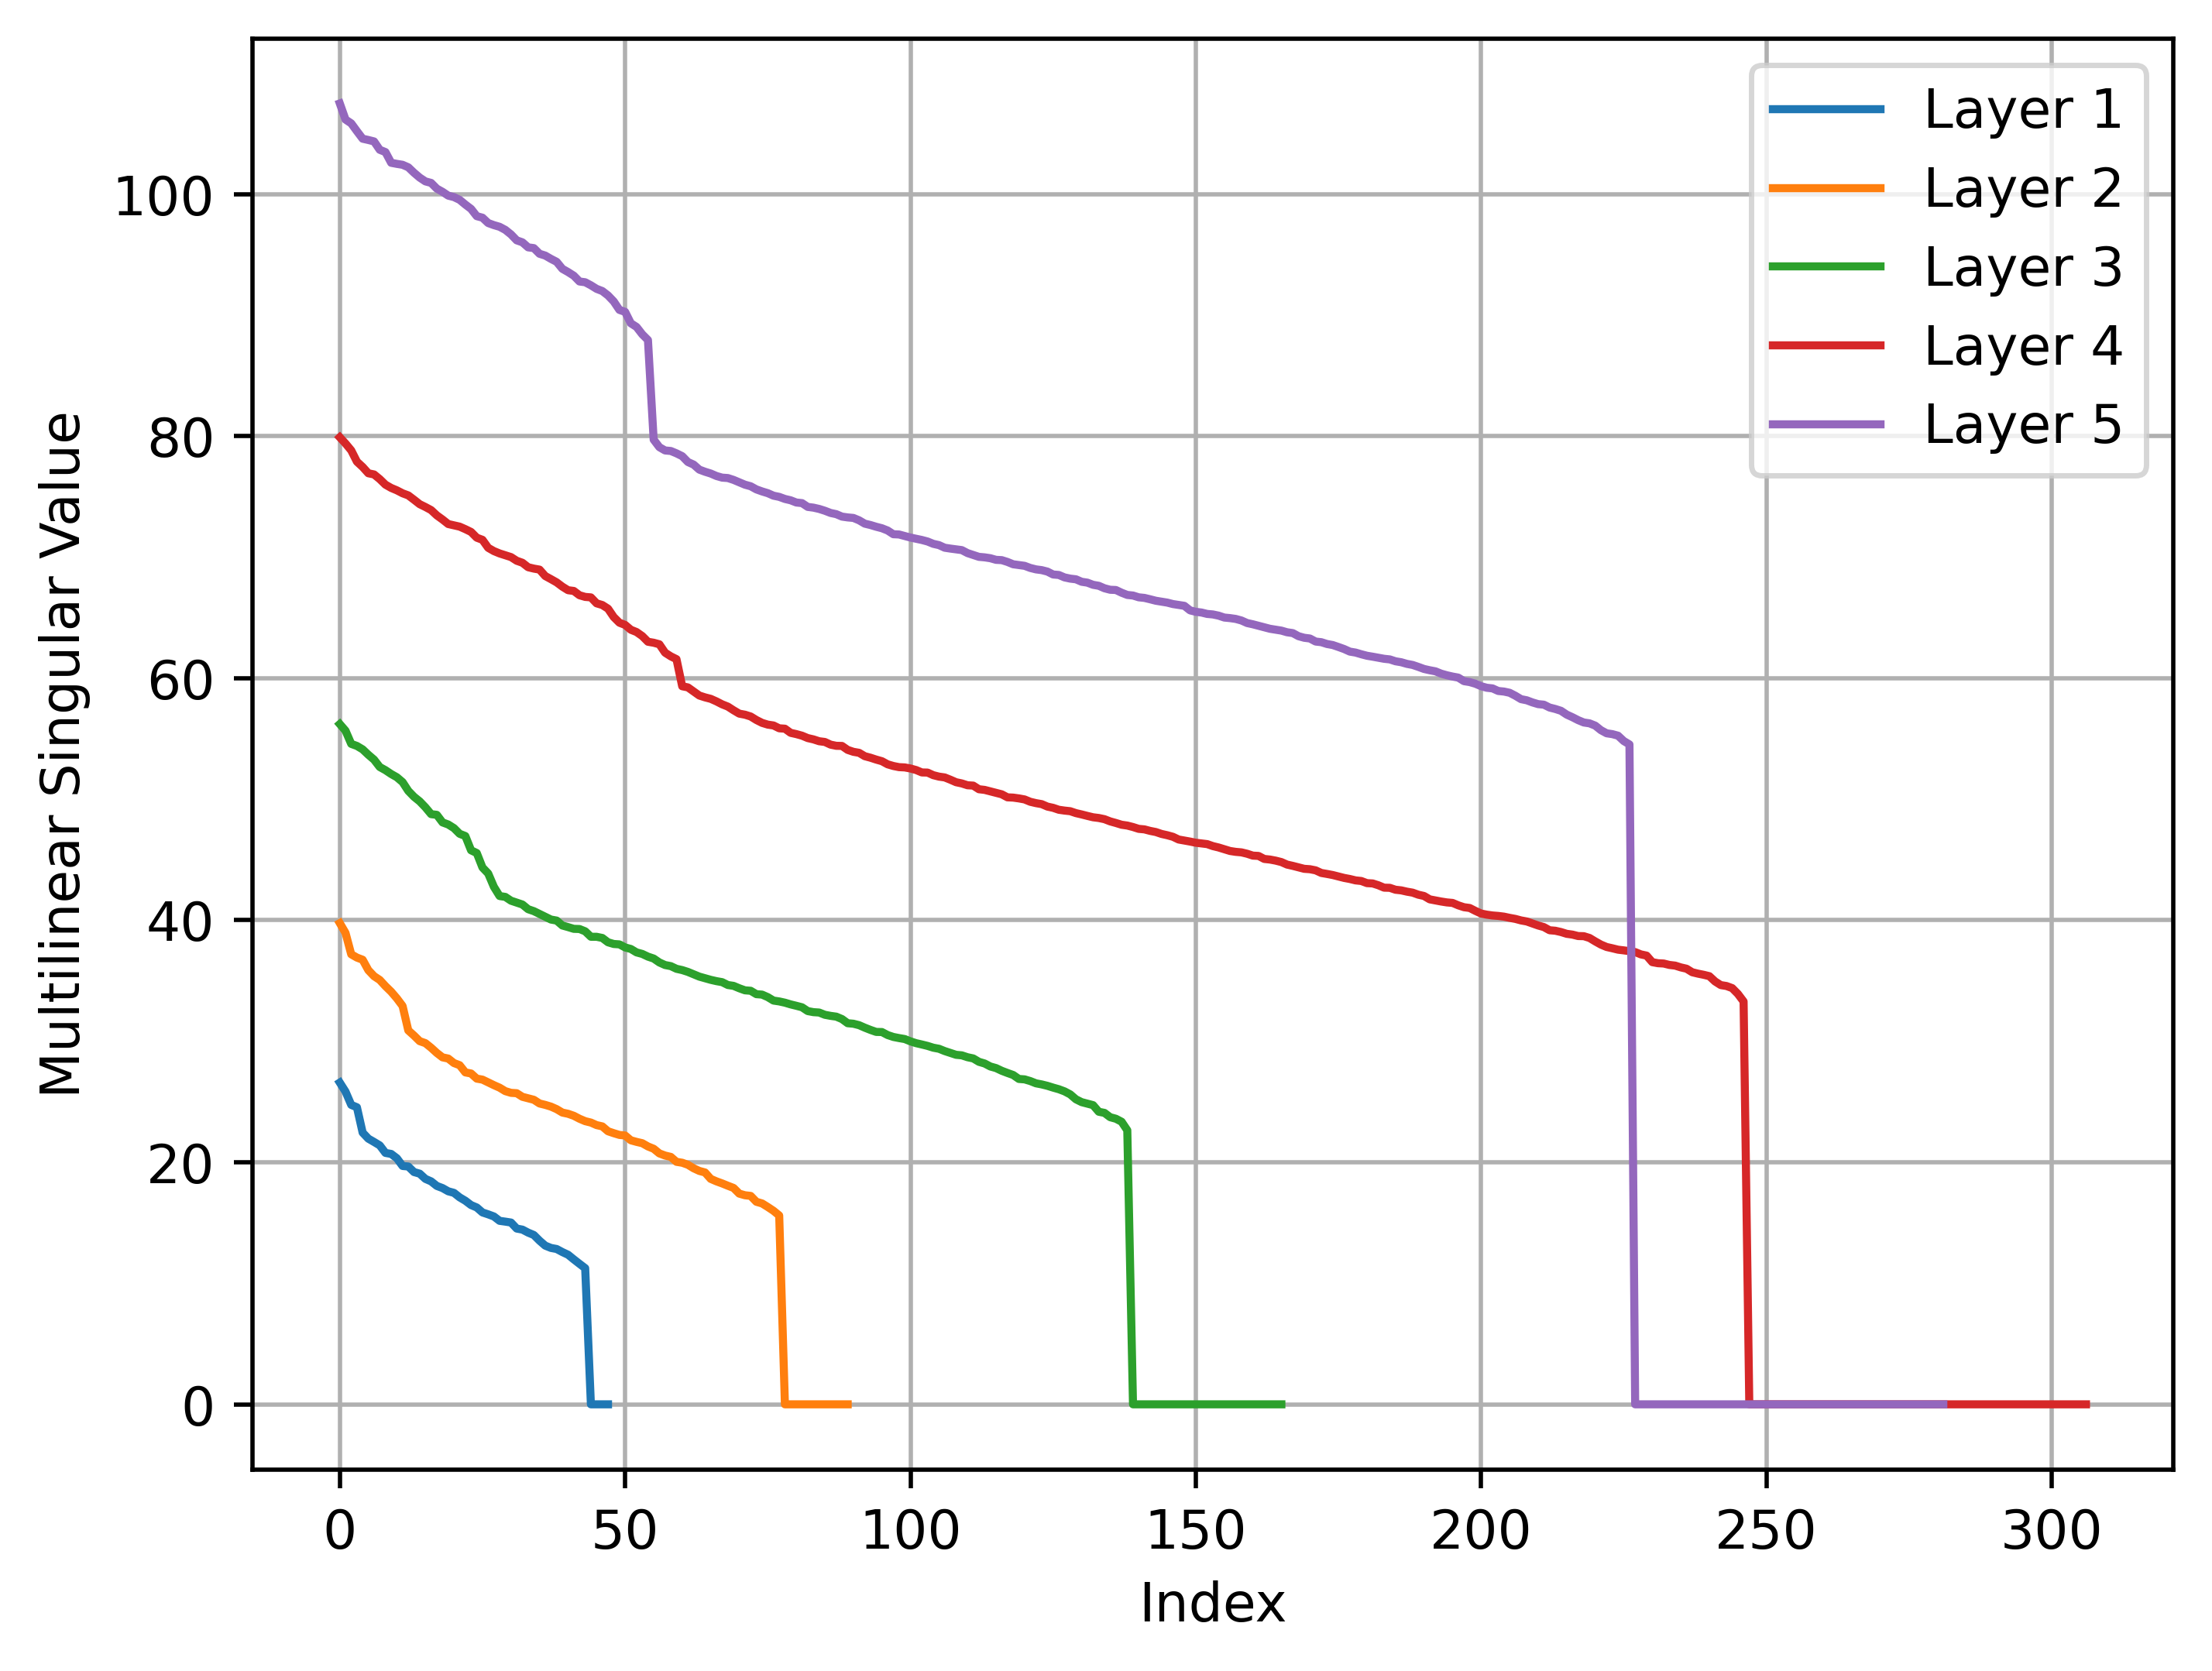

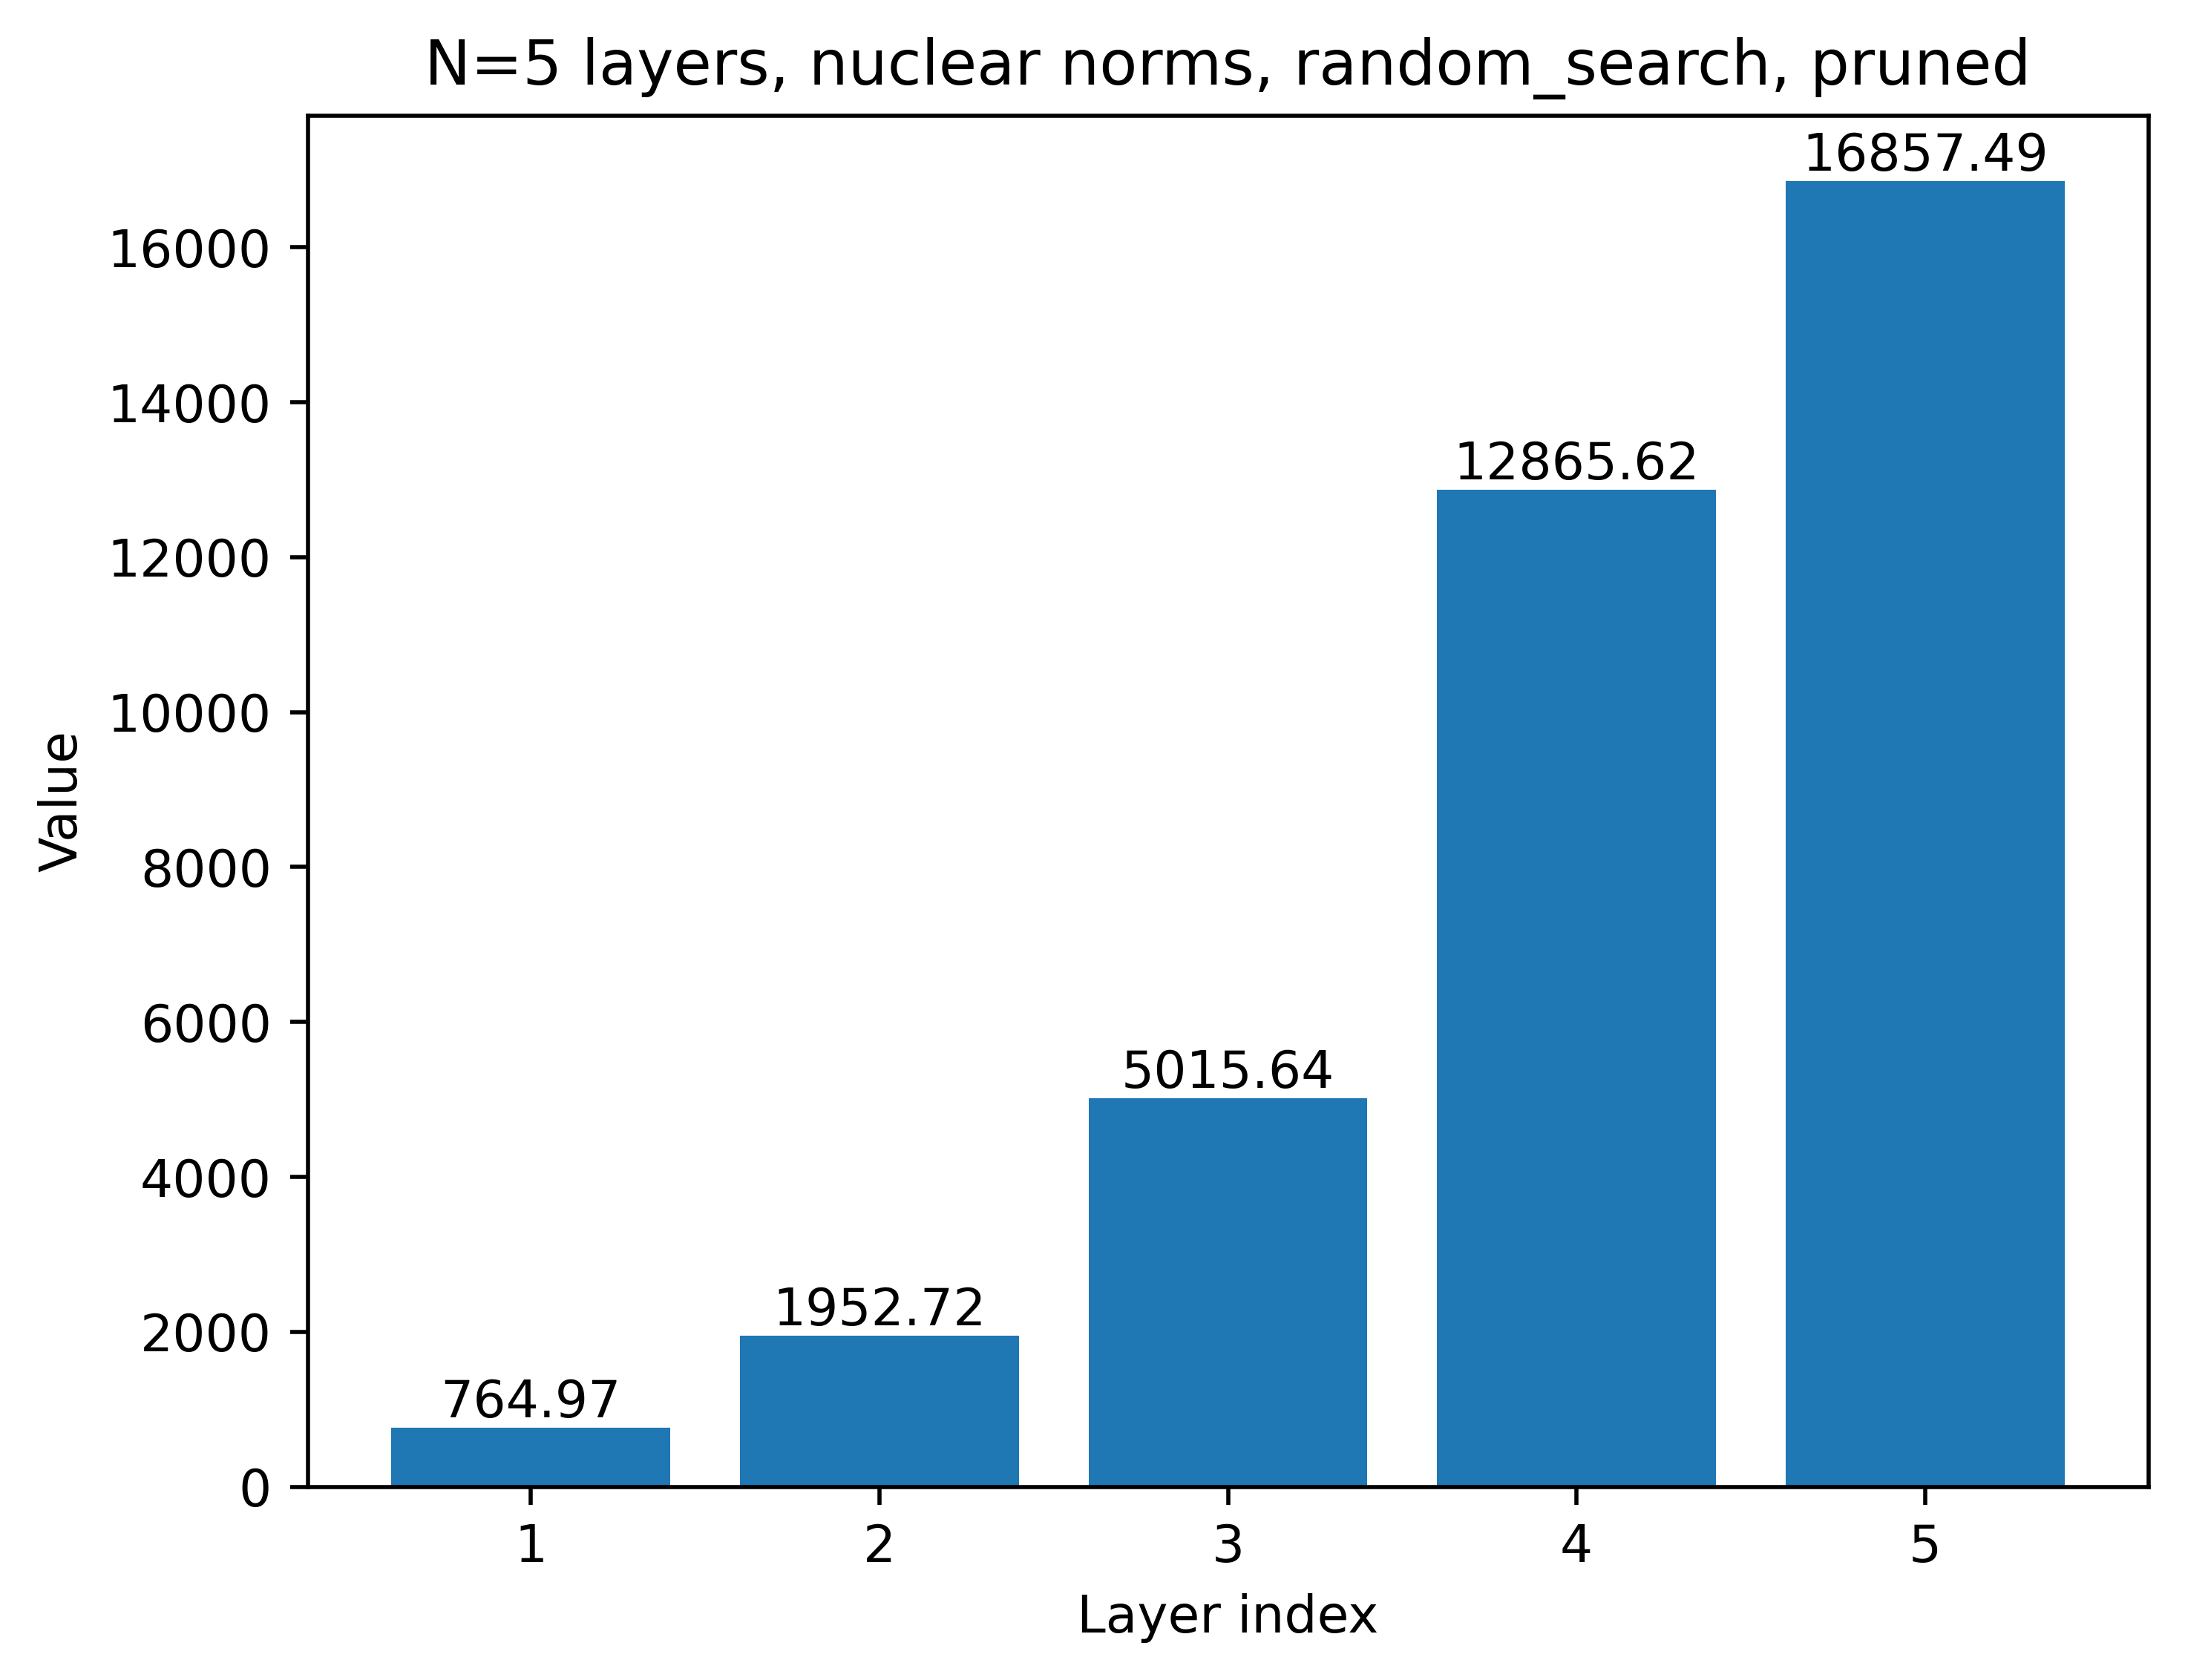

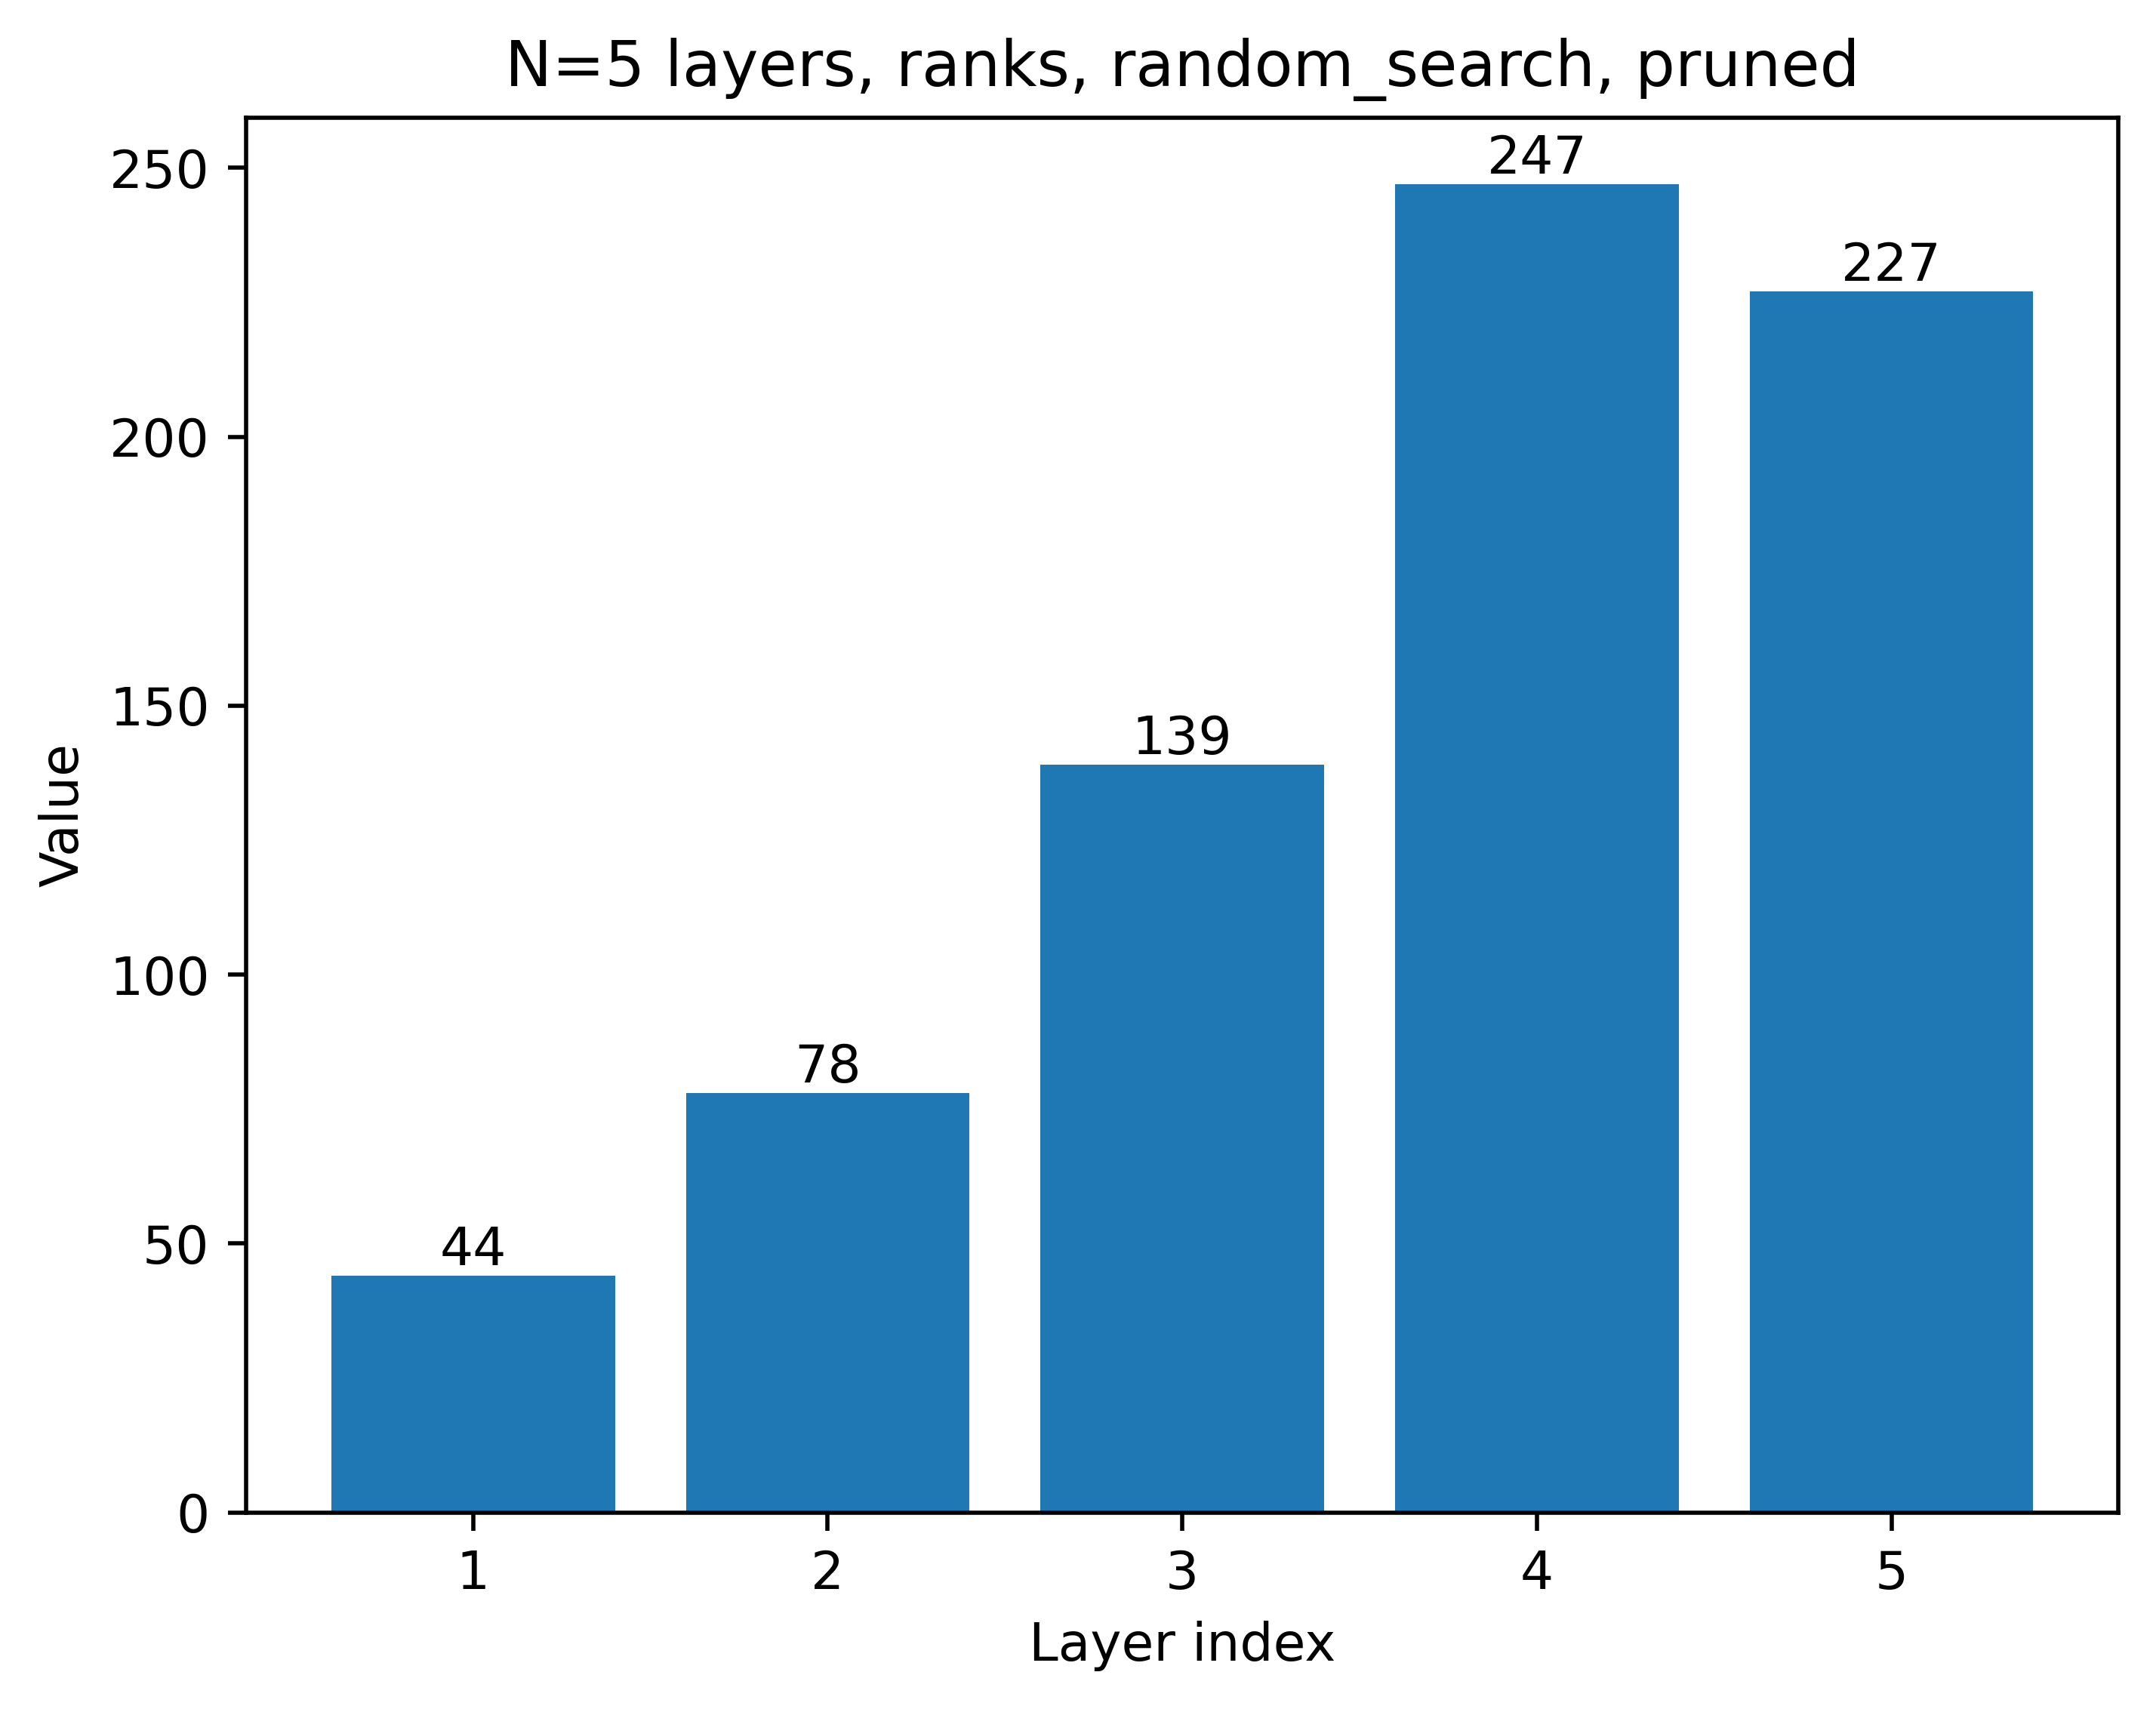

np.sum(nuclear_norms) 37456.45001220703


In [12]:
best_vgg_layers, best_nuclear_norms = apply_random_search_to_layers(
    vgg_layers, optimal_channels, num_trials=1000
)
random_search_singular_values, random_search_nuclear_norms, random_search_ranks = (
    inspect_layers(best_vgg_layers, name="random_search, pruned")
)

## CHIP
https://arxiv.org/abs/2110.13981

In [13]:
def compute_saliency(tensor):
    """ """

    full_nuclear_norm = nuclear_norm(tensor)
    num_filters = tensor.size(0)
    saliencies = []
    for i in range(num_filters):
        remaining = torch.cat((tensor[:i], tensor[i + 1 :]))
        saliency = full_nuclear_norm - nuclear_norm(remaining)
        saliencies.append(saliency)

    return saliencies


def apply_chip_to_layers(vgg_layers, optimal_channels):
    """
    Apply CHIP to each layer in vgg_layers based on the optimal_channels.

    Parameters:
    - vgg_layers: list of torch.Tensor, list of layer tensors
    - optimal_channels: list, number of filters to keep in each layer

    Returns:
    - pruned_layers: list of torch.Tensor, list of layer tensors after CHIP
    """

    pruned_layers = []

    for i, (layer_tensor, num_centroids) in enumerate(
        zip(vgg_layers, optimal_channels)
    ):
        print(f"Current layer: {i + 1}")
        saliency = compute_saliency(
            layer_tensor
        )  # is a list of float value, containing saliency of each filter from 1 to N
        # get indices of top k most important filters among N filters
        top_k_indices = (-np.array(saliency)).argsort()[
            :num_centroids
        ]  # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        pruned_layer = layer_tensor[top_k_indices]
        pruned_layers.append(pruned_layer)

    return pruned_layers

Current layer: 1
Current layer: 2
Current layer: 3
Current layer: 4
Current layer: 5


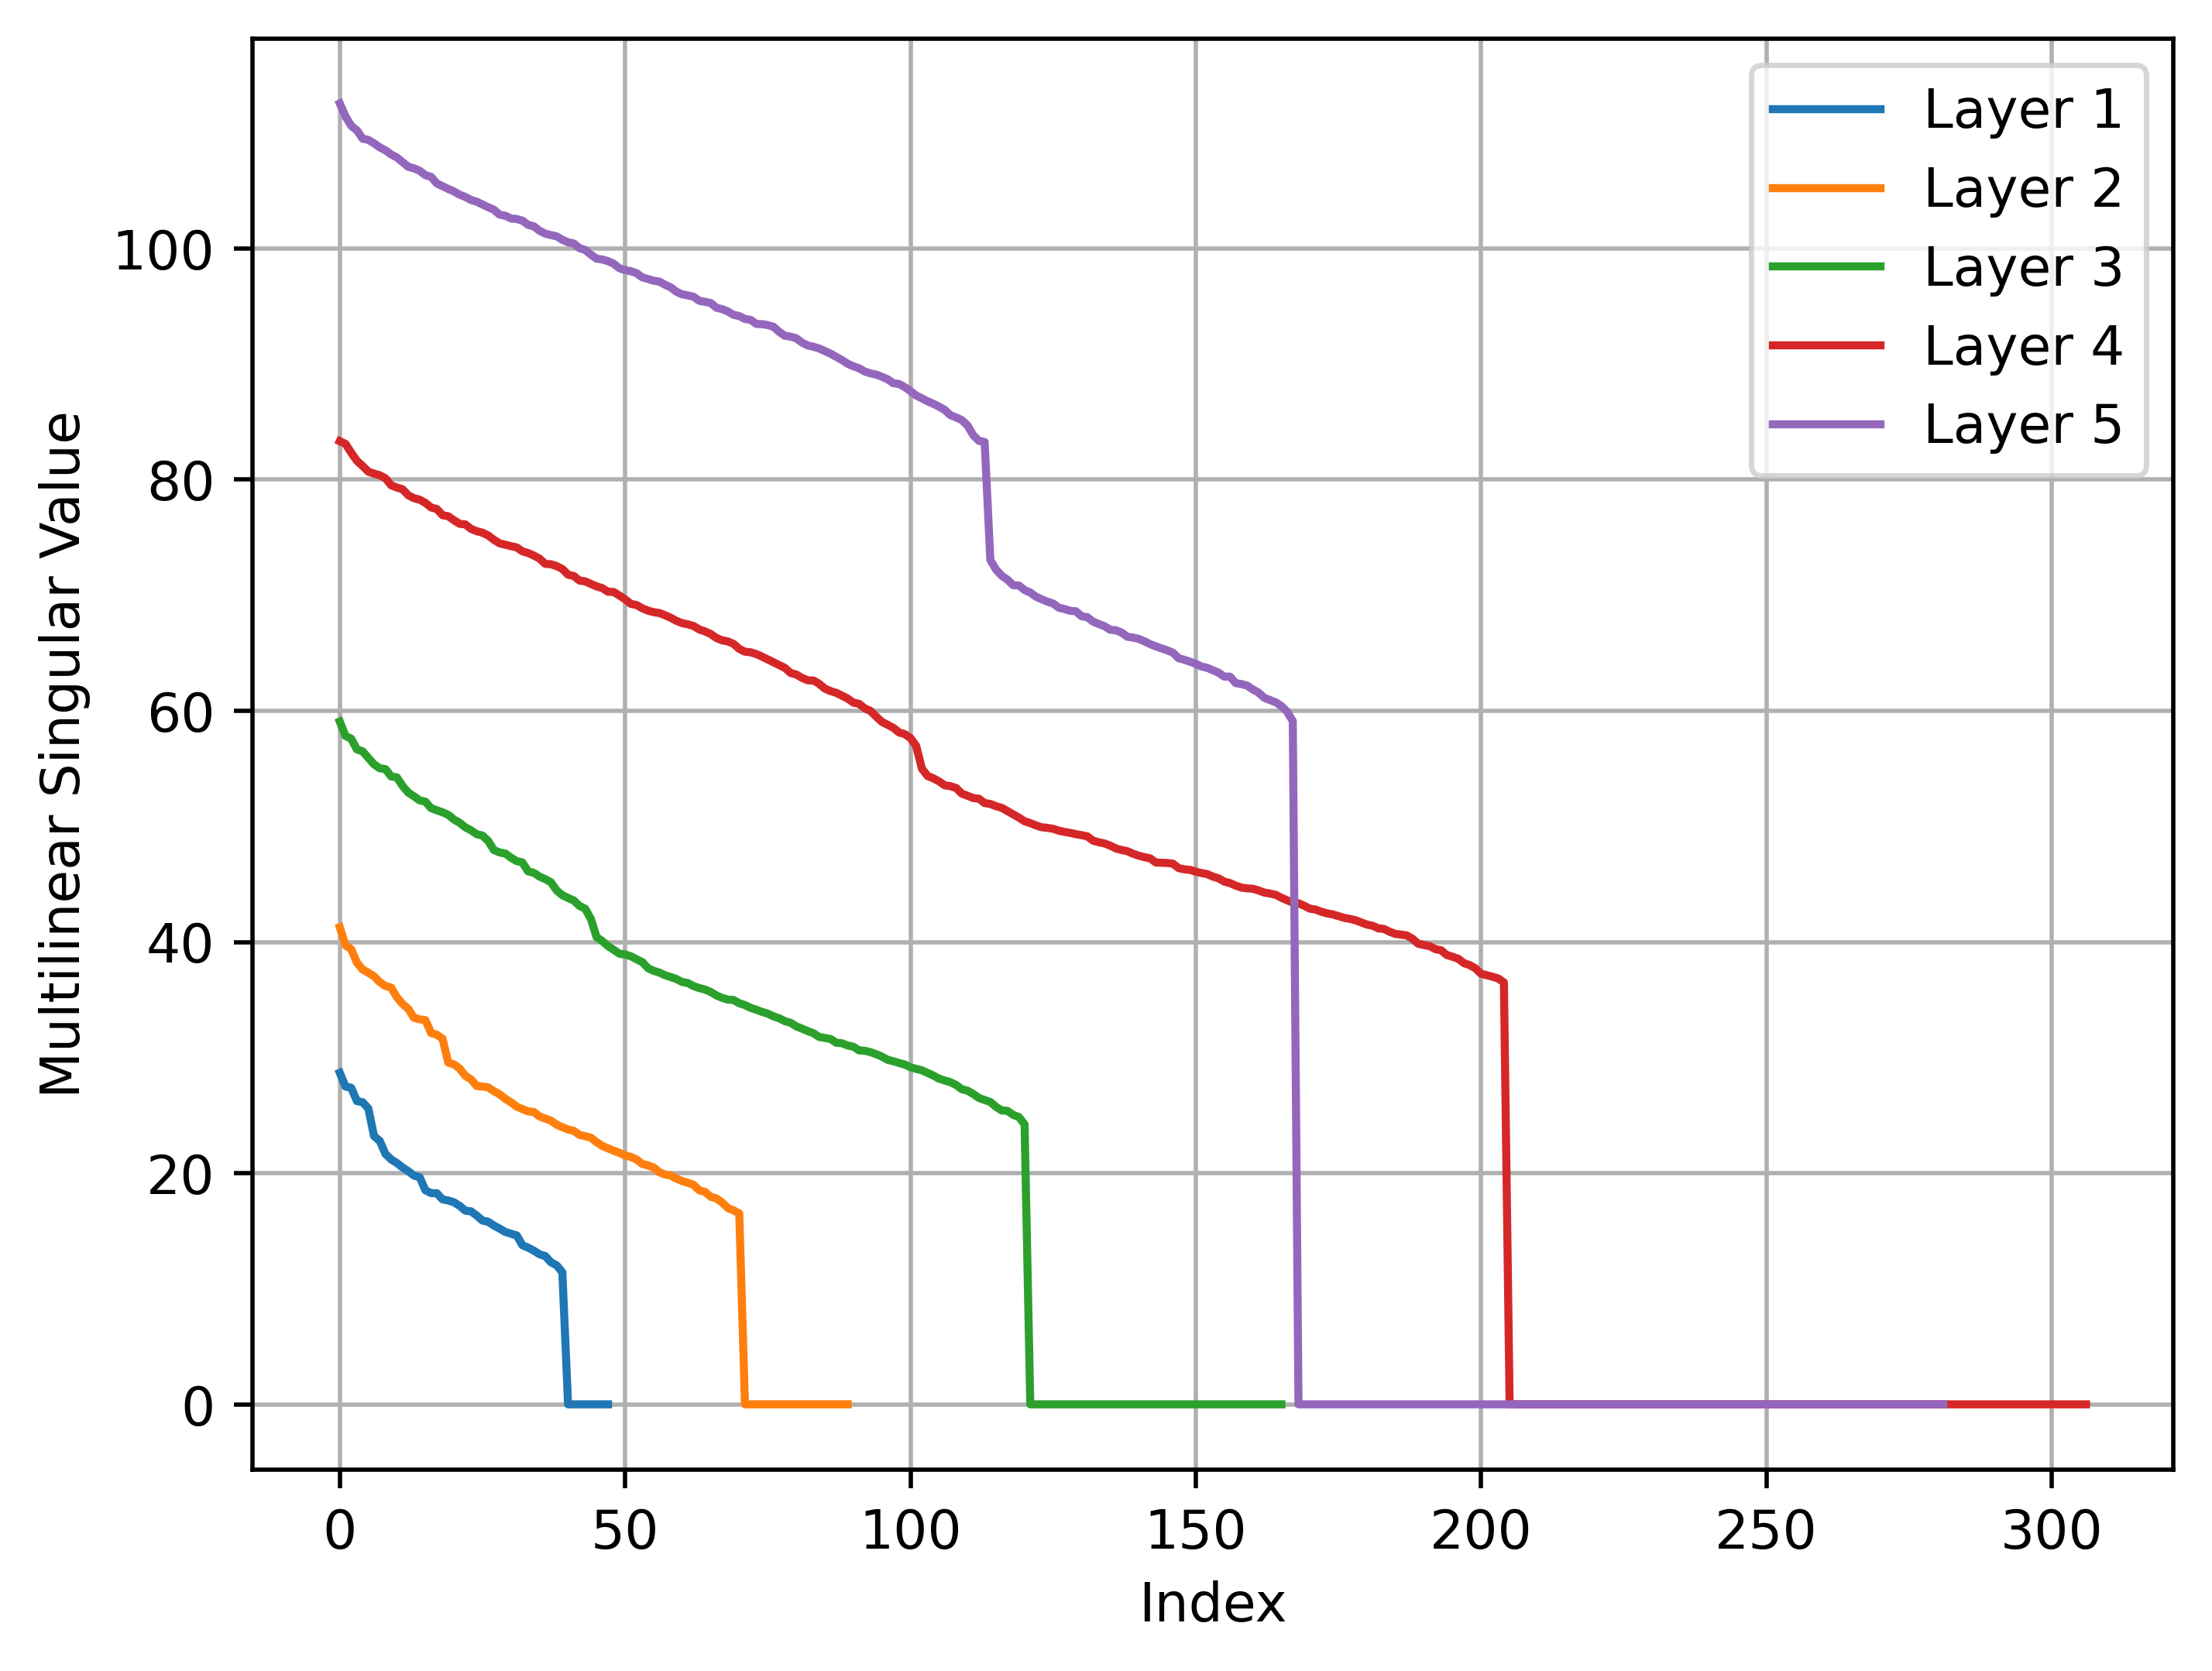

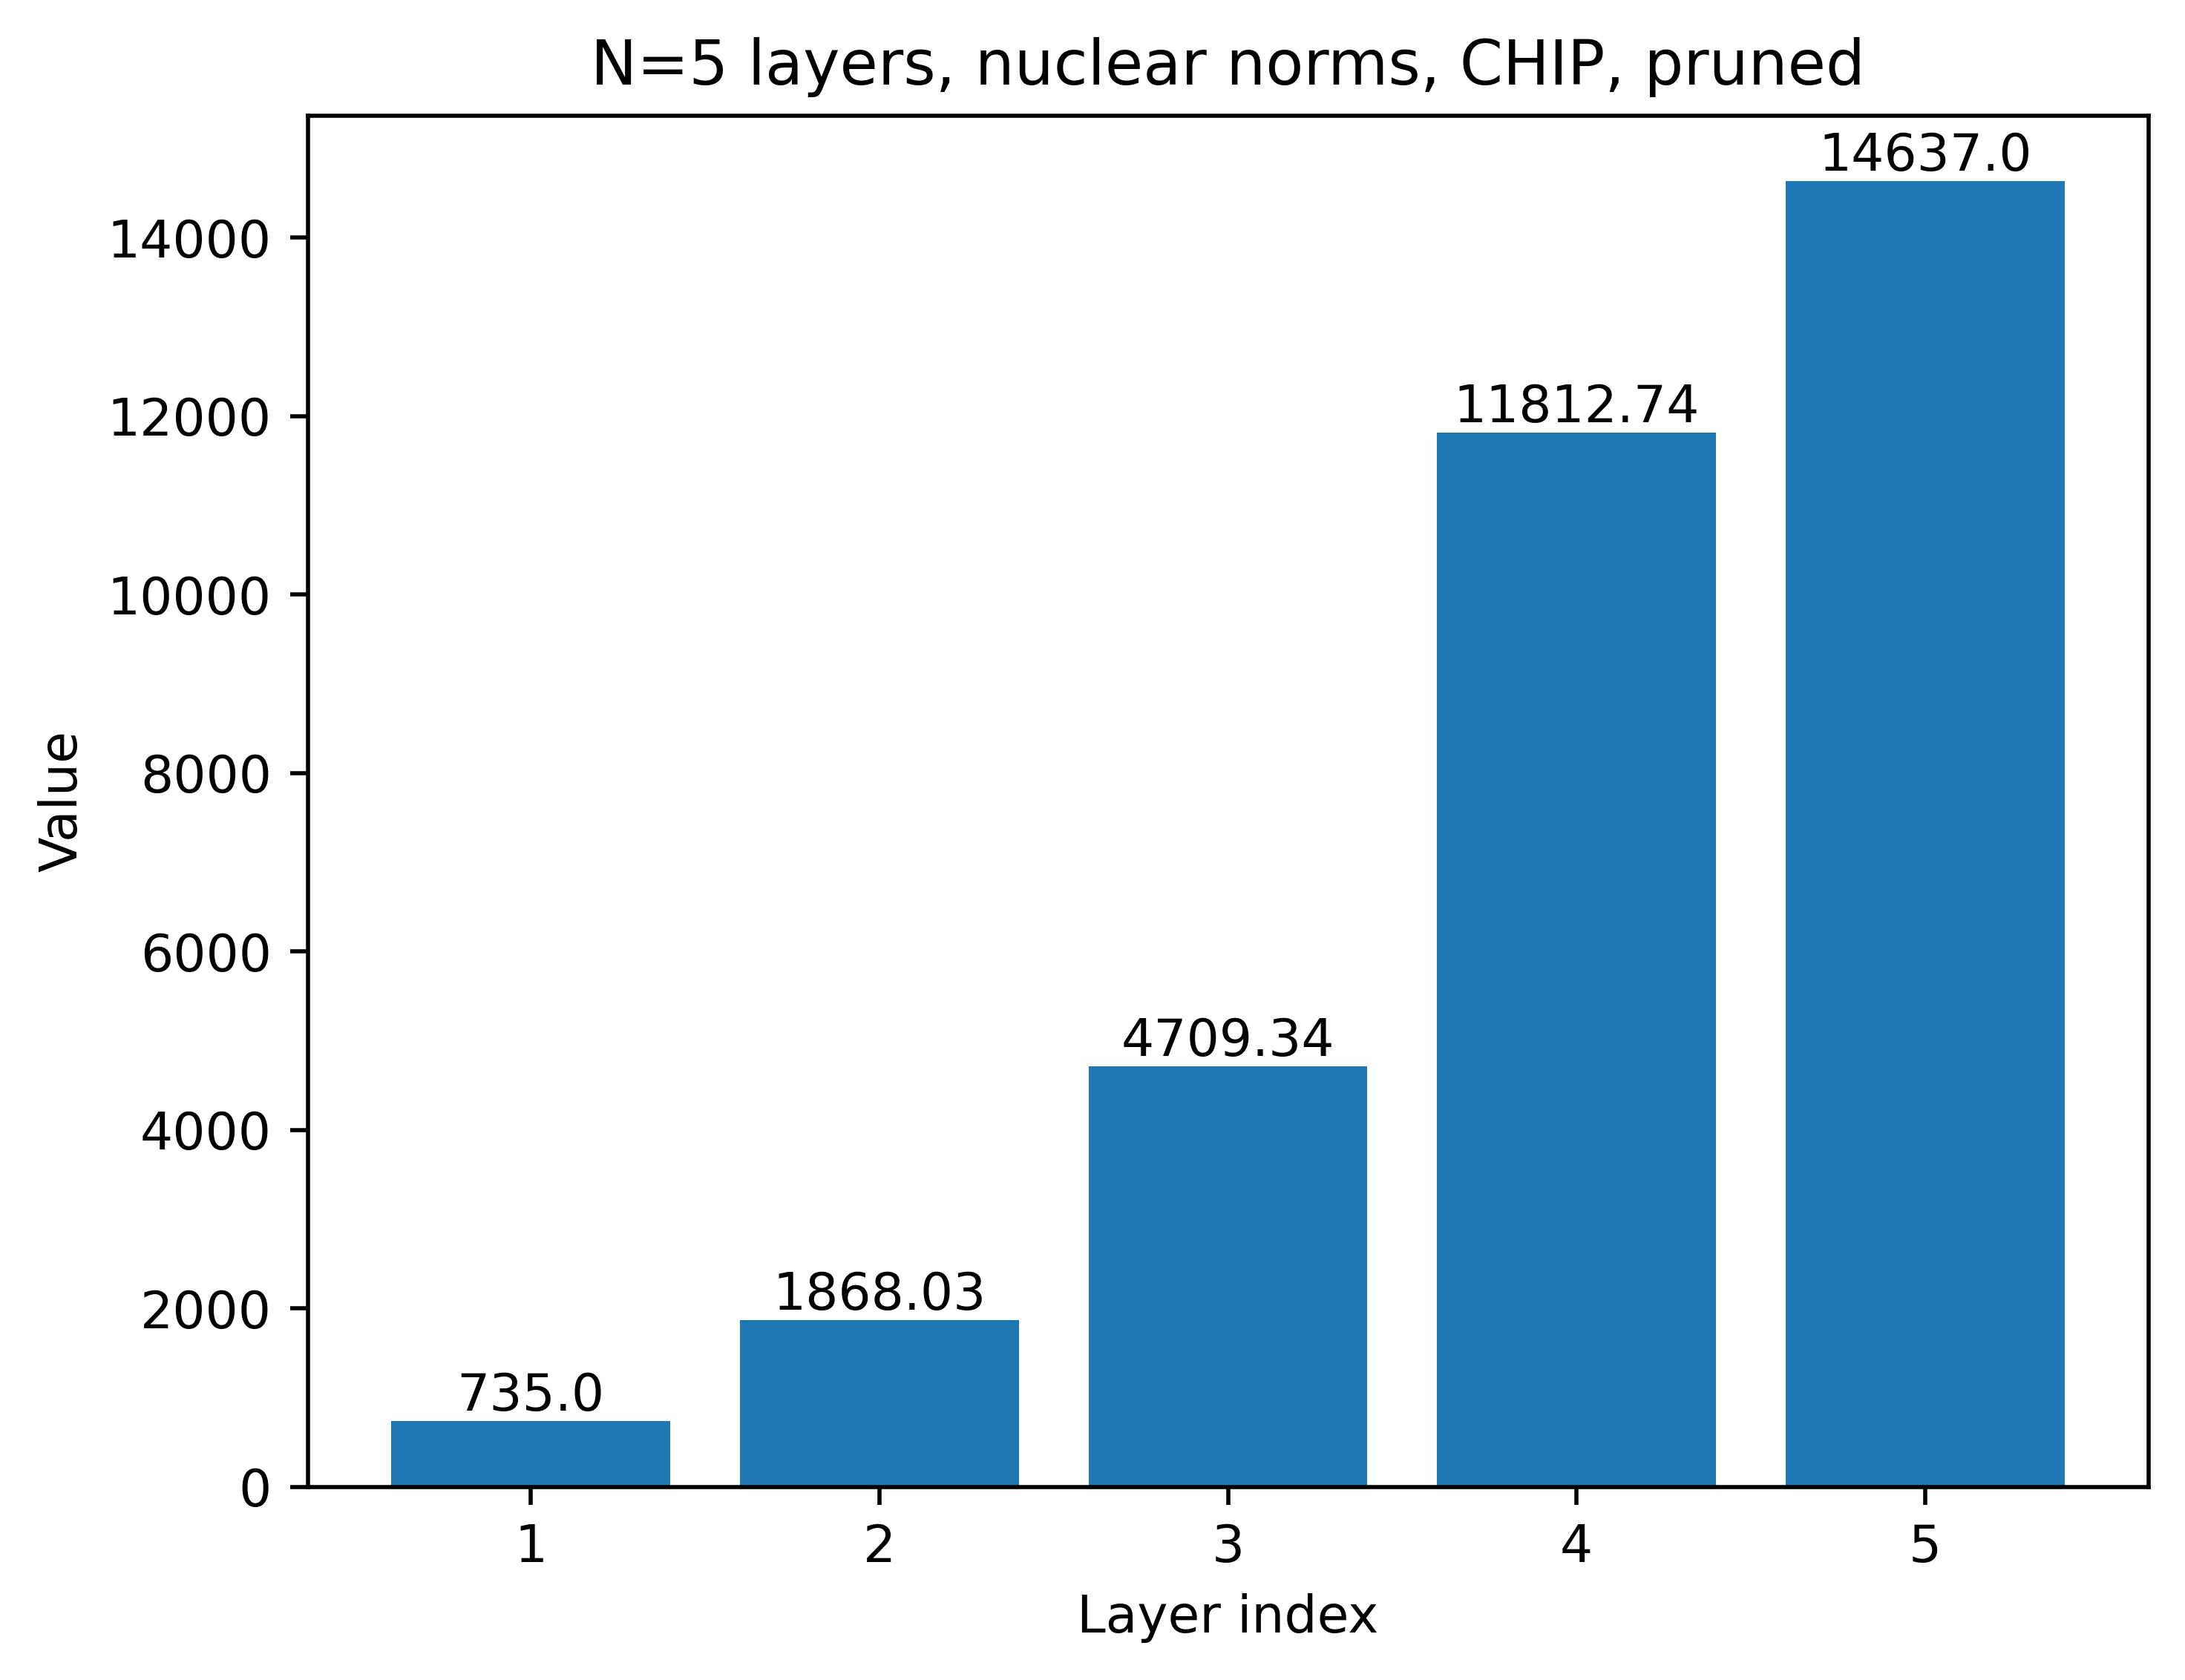

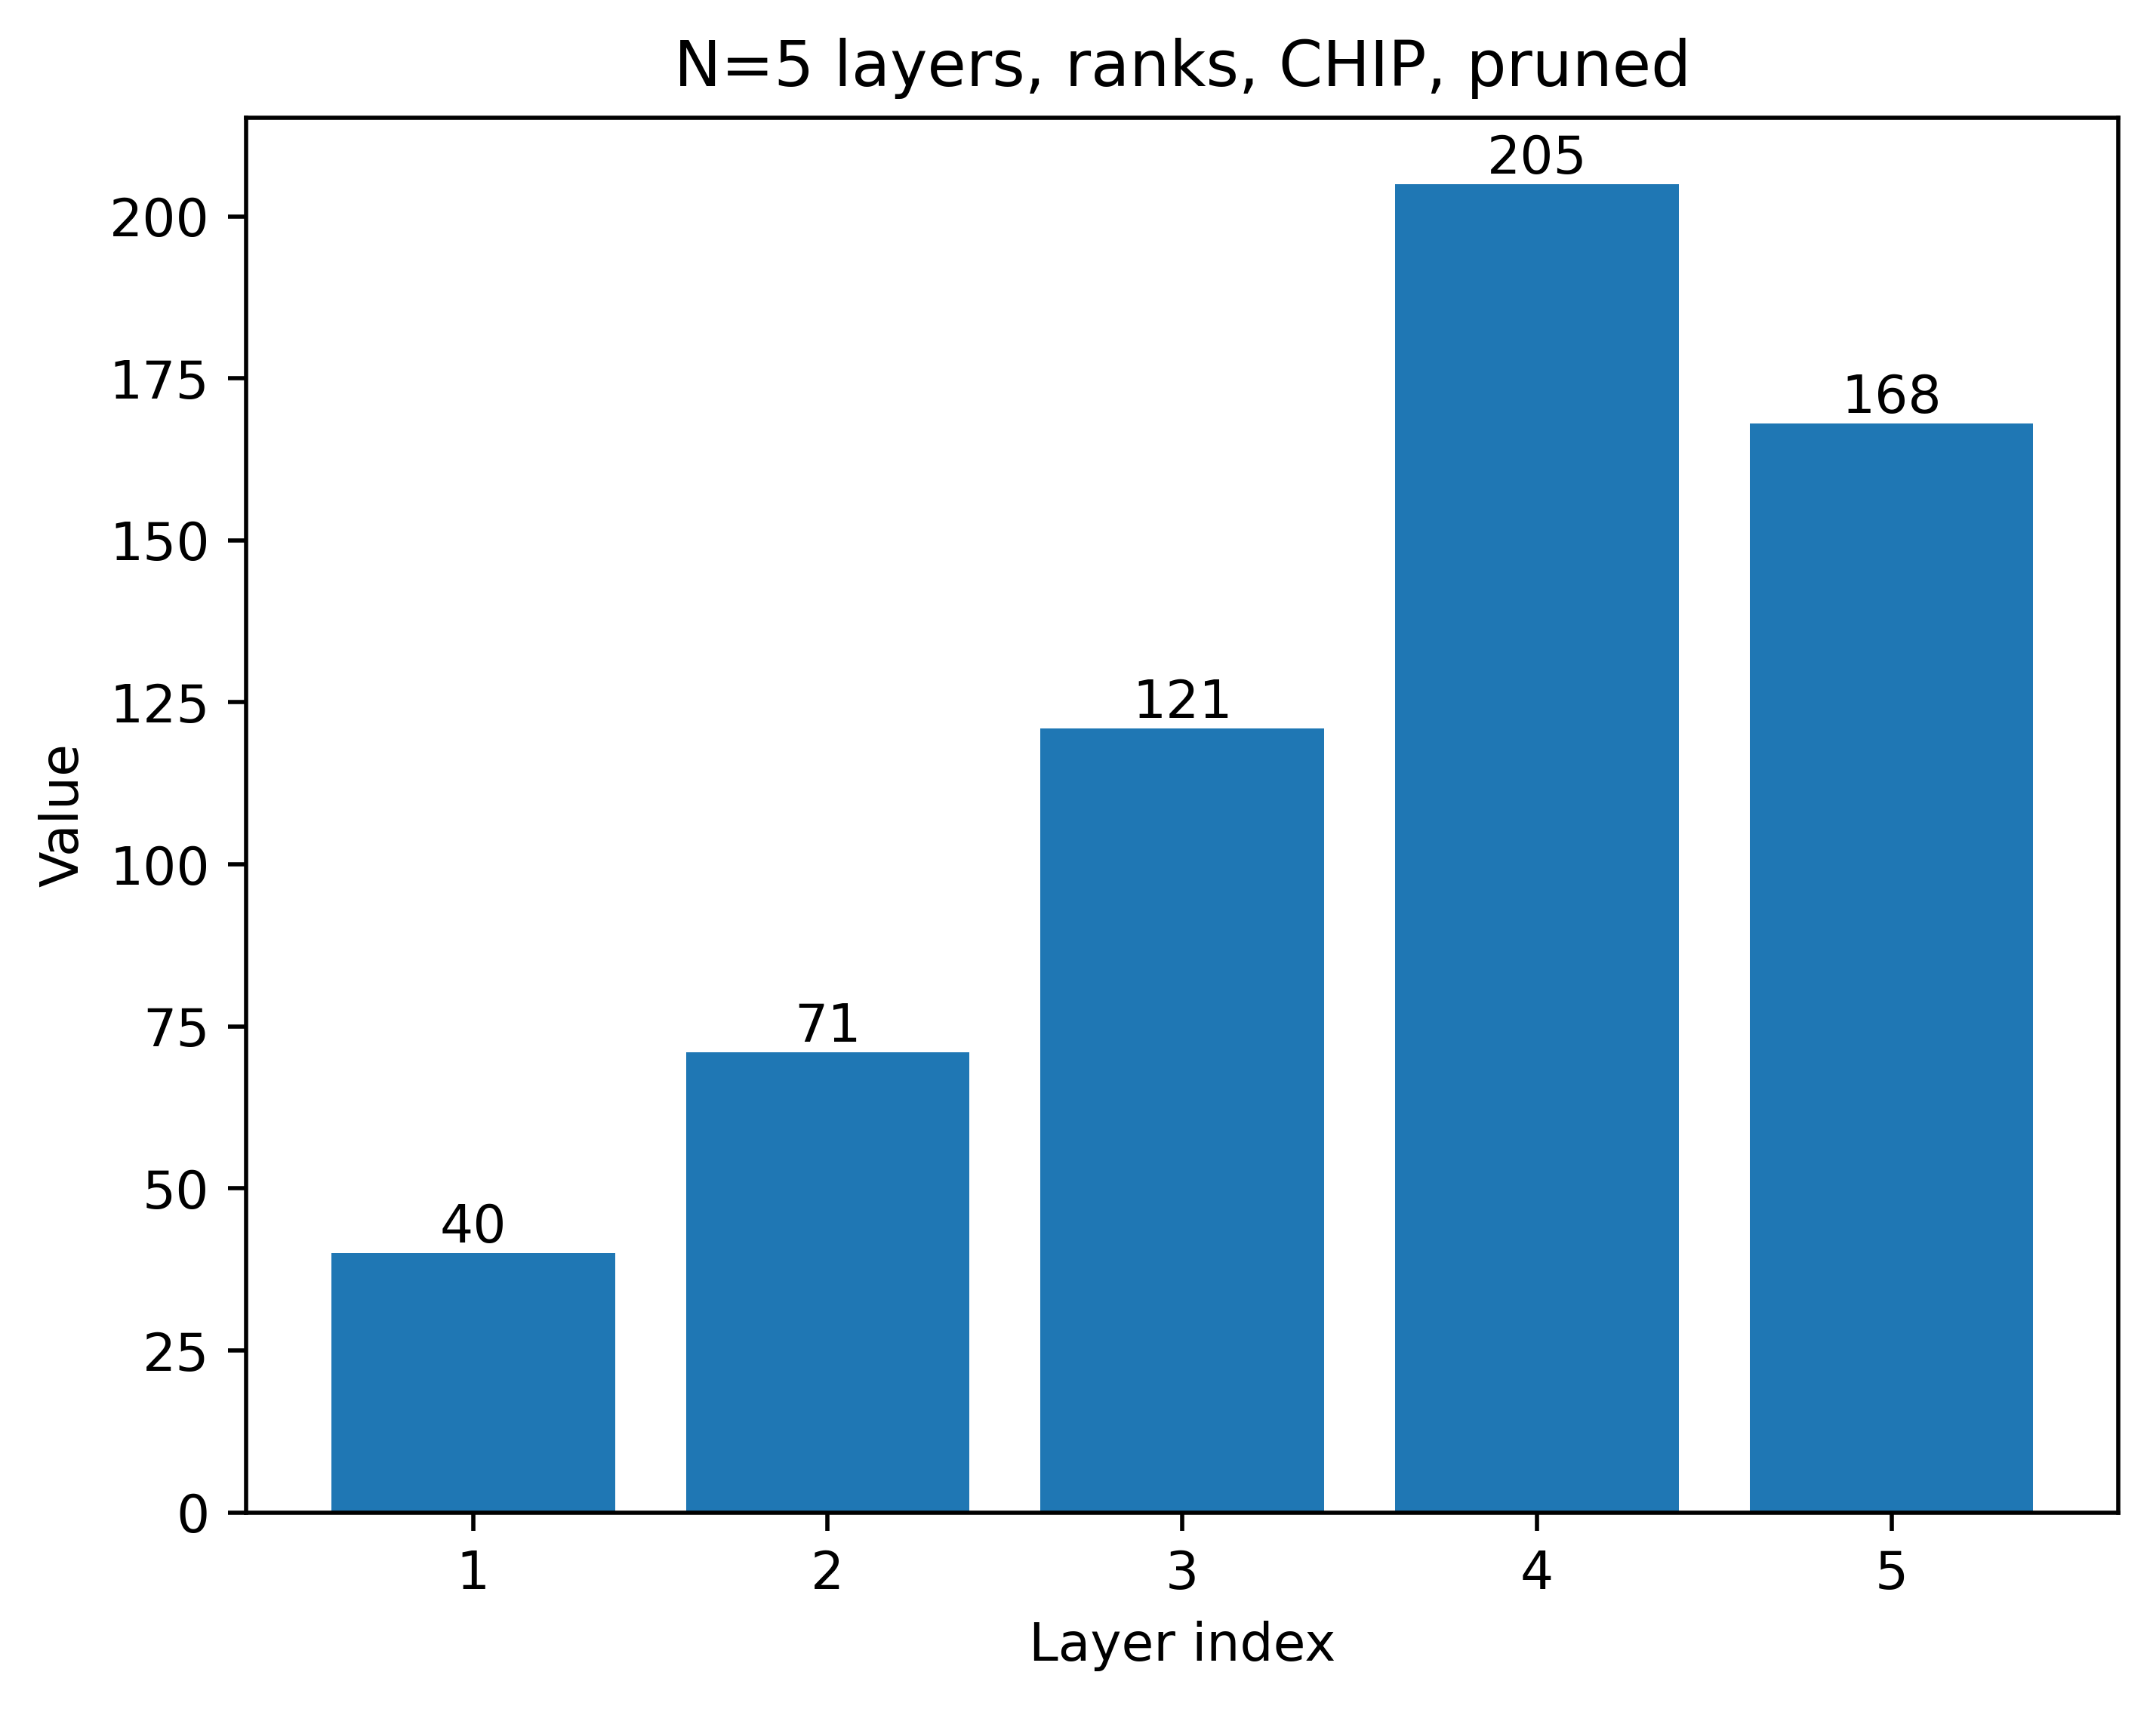

np.sum(nuclear_norms) 33762.11798095703


In [14]:
chip_pruned_layers = apply_chip_to_layers(vgg_layers, optimal_channels)
chip_singular_values, chip_nuclear_norms, chip_ranks = inspect_layers(
    chip_pruned_layers, name="CHIP, pruned"
)

## FPC
https://www.sciencedirect.com/science/article/pii/S0950705121010492

In [15]:
def compute_saliency_fpc(tensor):
    """ """

    num_filters = tensor.size(0)
    saliencies = []
    for i in range(num_filters):
        saliency = nuclear_norm(tensor[i])
        saliencies.append(saliency)

    return saliencies


def apply_fpc_to_layers(vgg_layers, optimal_channels):
    """
    Apply FPC to each layer in vgg_layers based on the optimal_channels.

    Parameters:
    - vgg_layers: list of torch.Tensor, list of layer tensors
    - optimal_channels: list, number of filters to keep in each layer

    Returns:
    - pruned_layers: list of torch.Tensor, list of layer tensors after FPC
    """

    pruned_layers = []

    for i, (layer_tensor, num_centroids) in enumerate(
        zip(vgg_layers, optimal_channels)
    ):
        print(f"Current layer: {i + 1}")
        saliency = compute_saliency_fpc(
            layer_tensor
        )  # is a list of float value, containing saliency of each filter from 1 to N
        # get indices of top k most important filters among N filters
        top_k_indices = (-np.array(saliency)).argsort()[
            :num_centroids
        ]  # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        pruned_layer = layer_tensor[top_k_indices]
        pruned_layers.append(pruned_layer)

    return pruned_layers

Current layer: 1
Current layer: 2
Current layer: 3
Current layer: 4
Current layer: 5


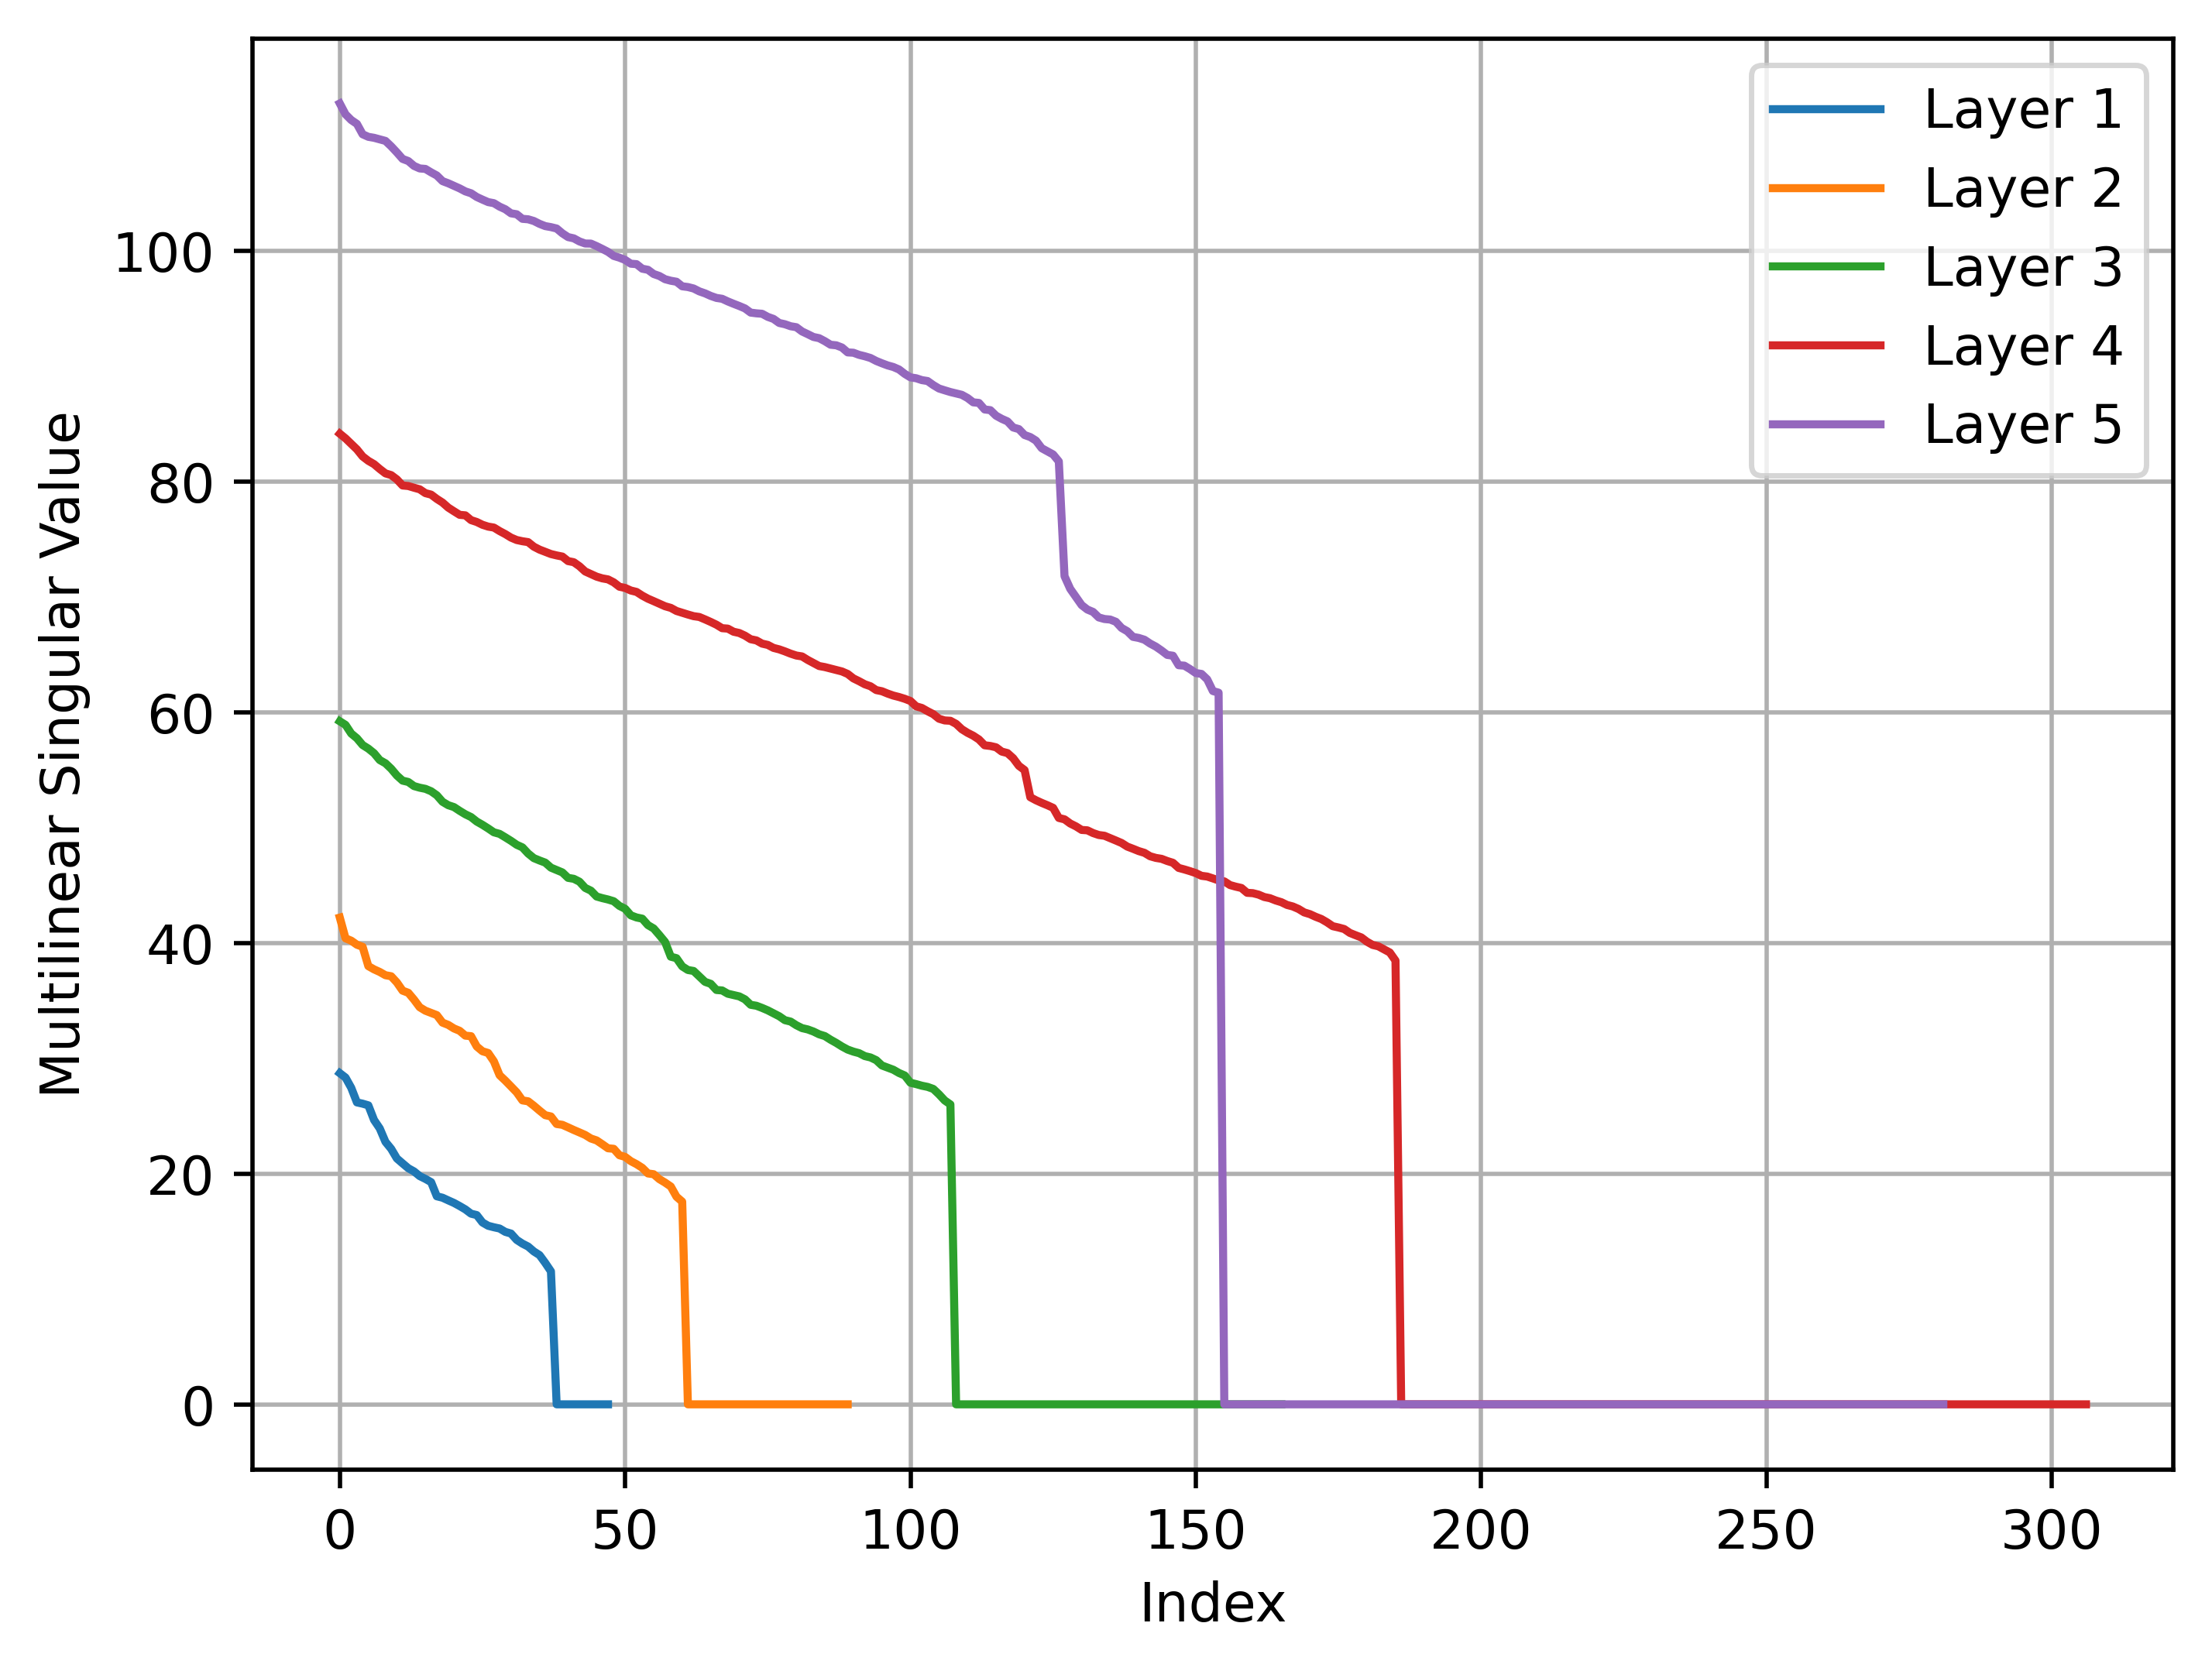

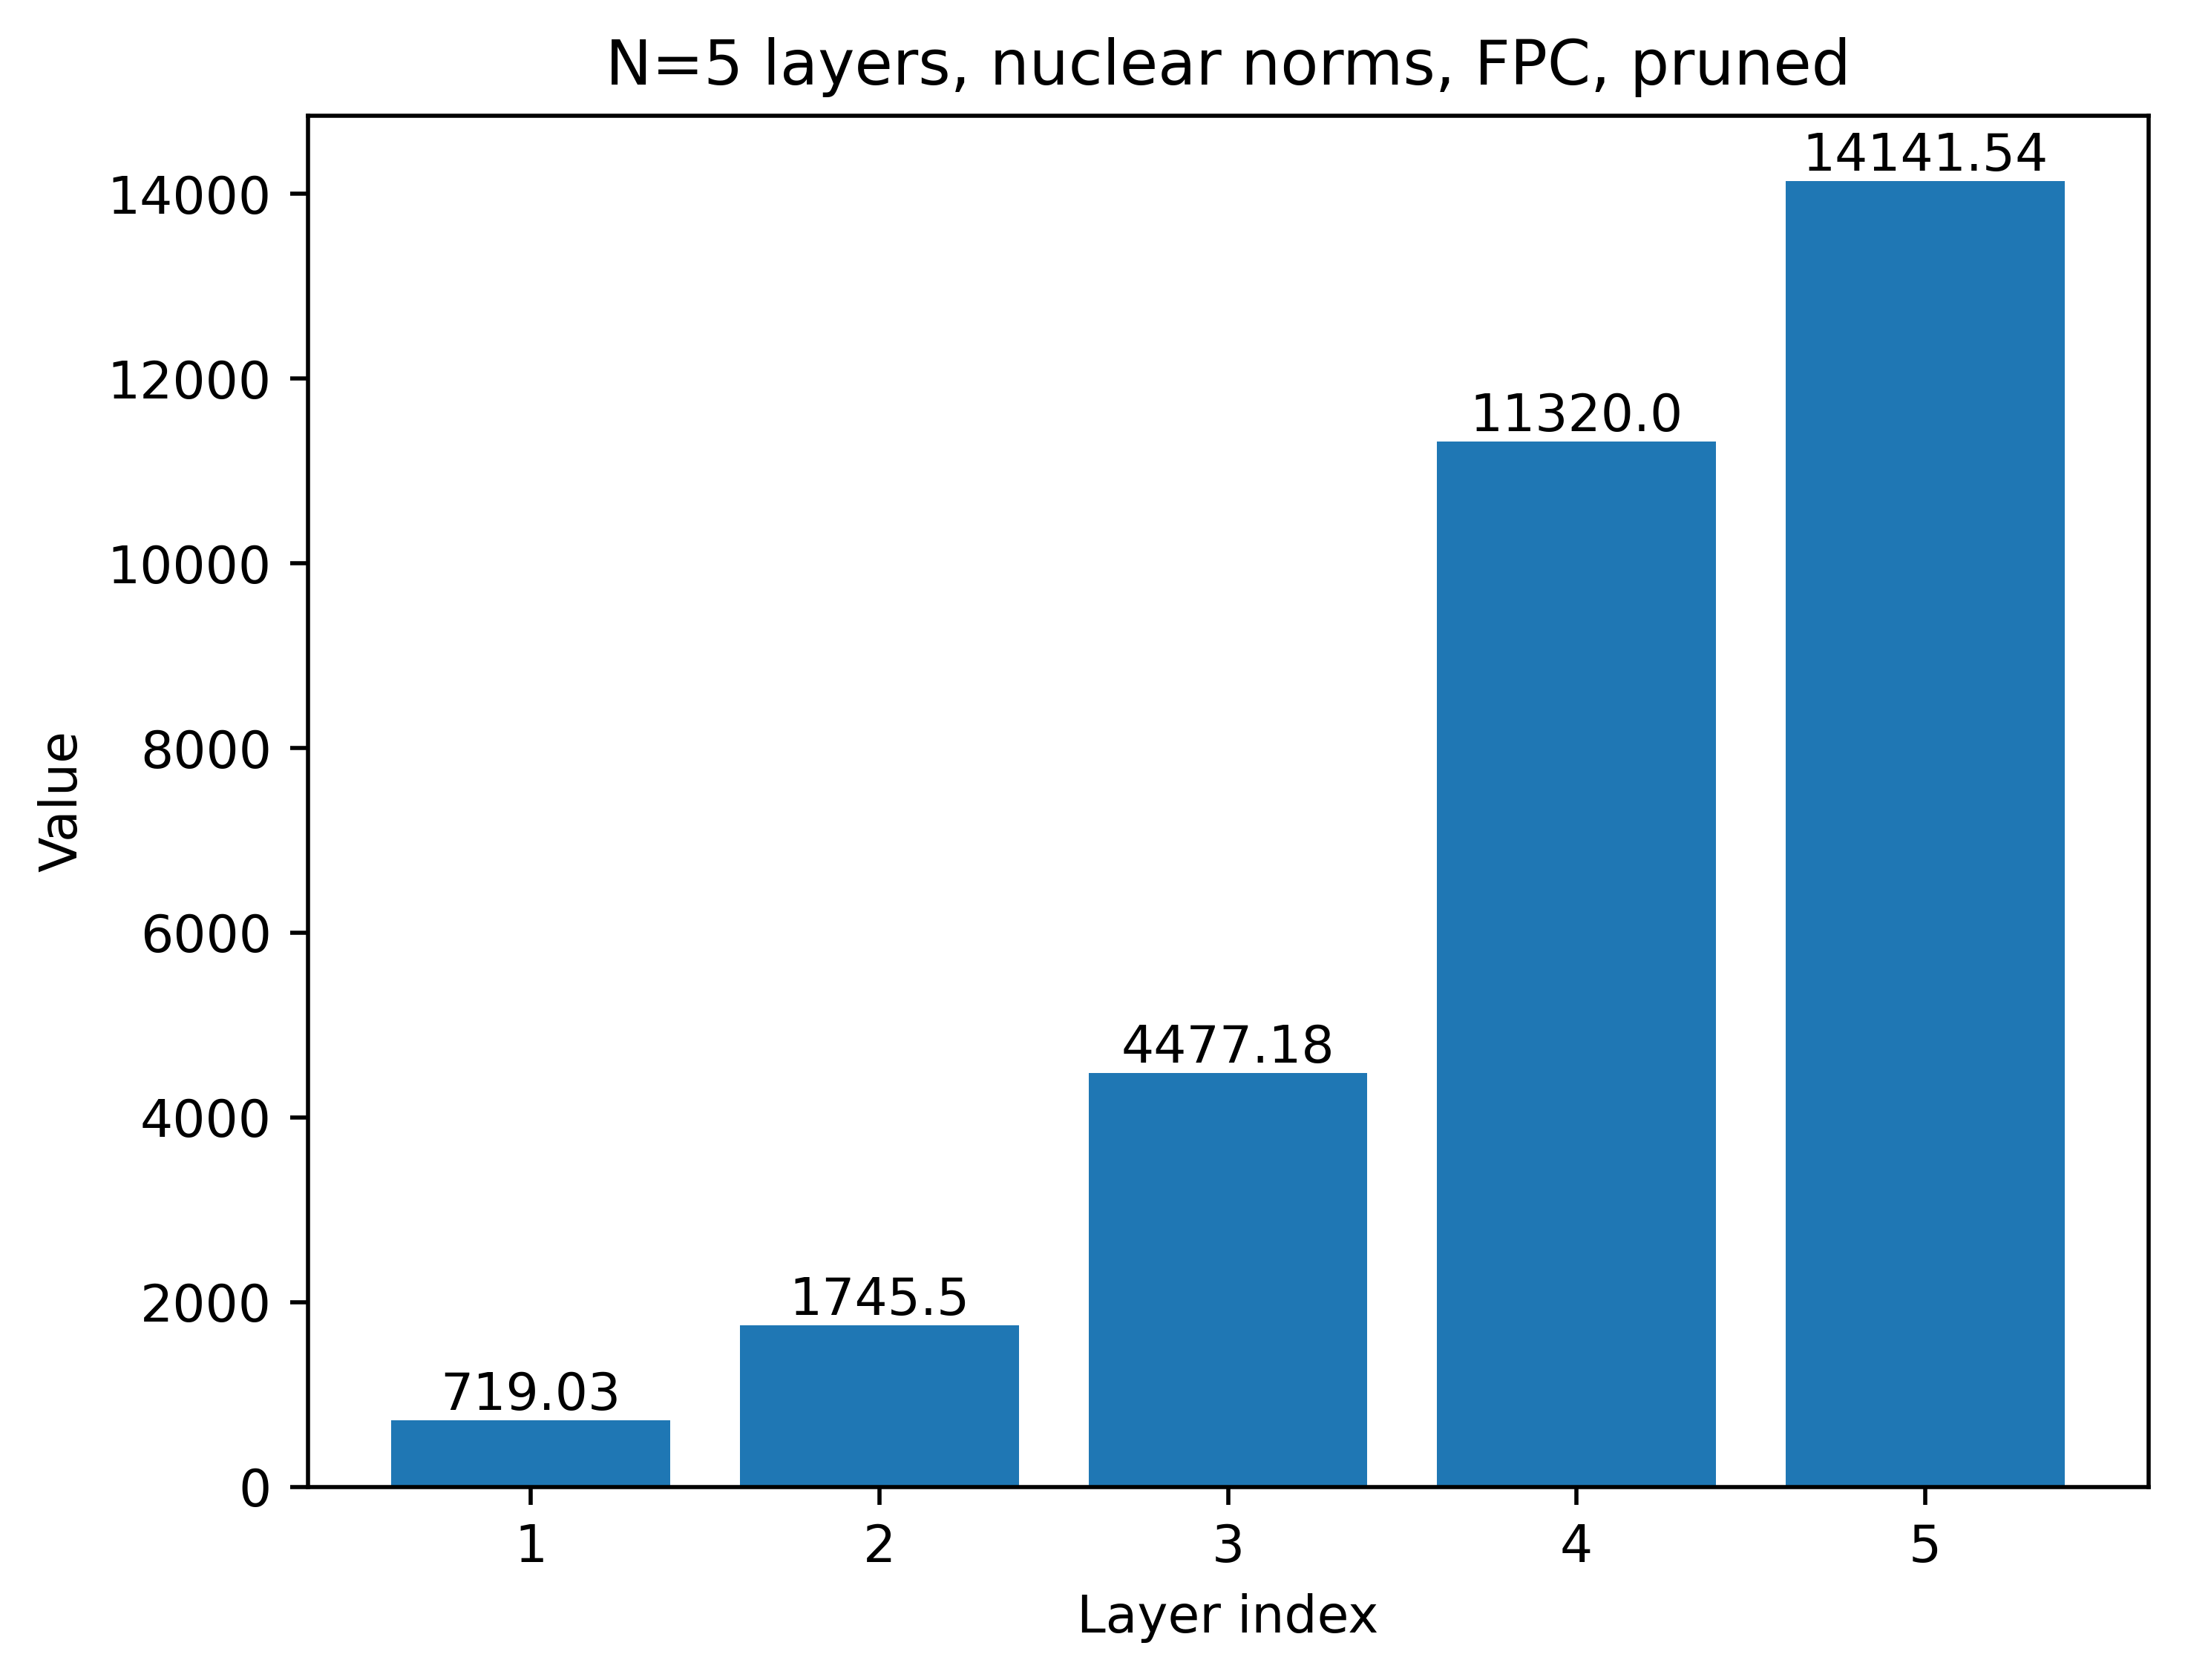

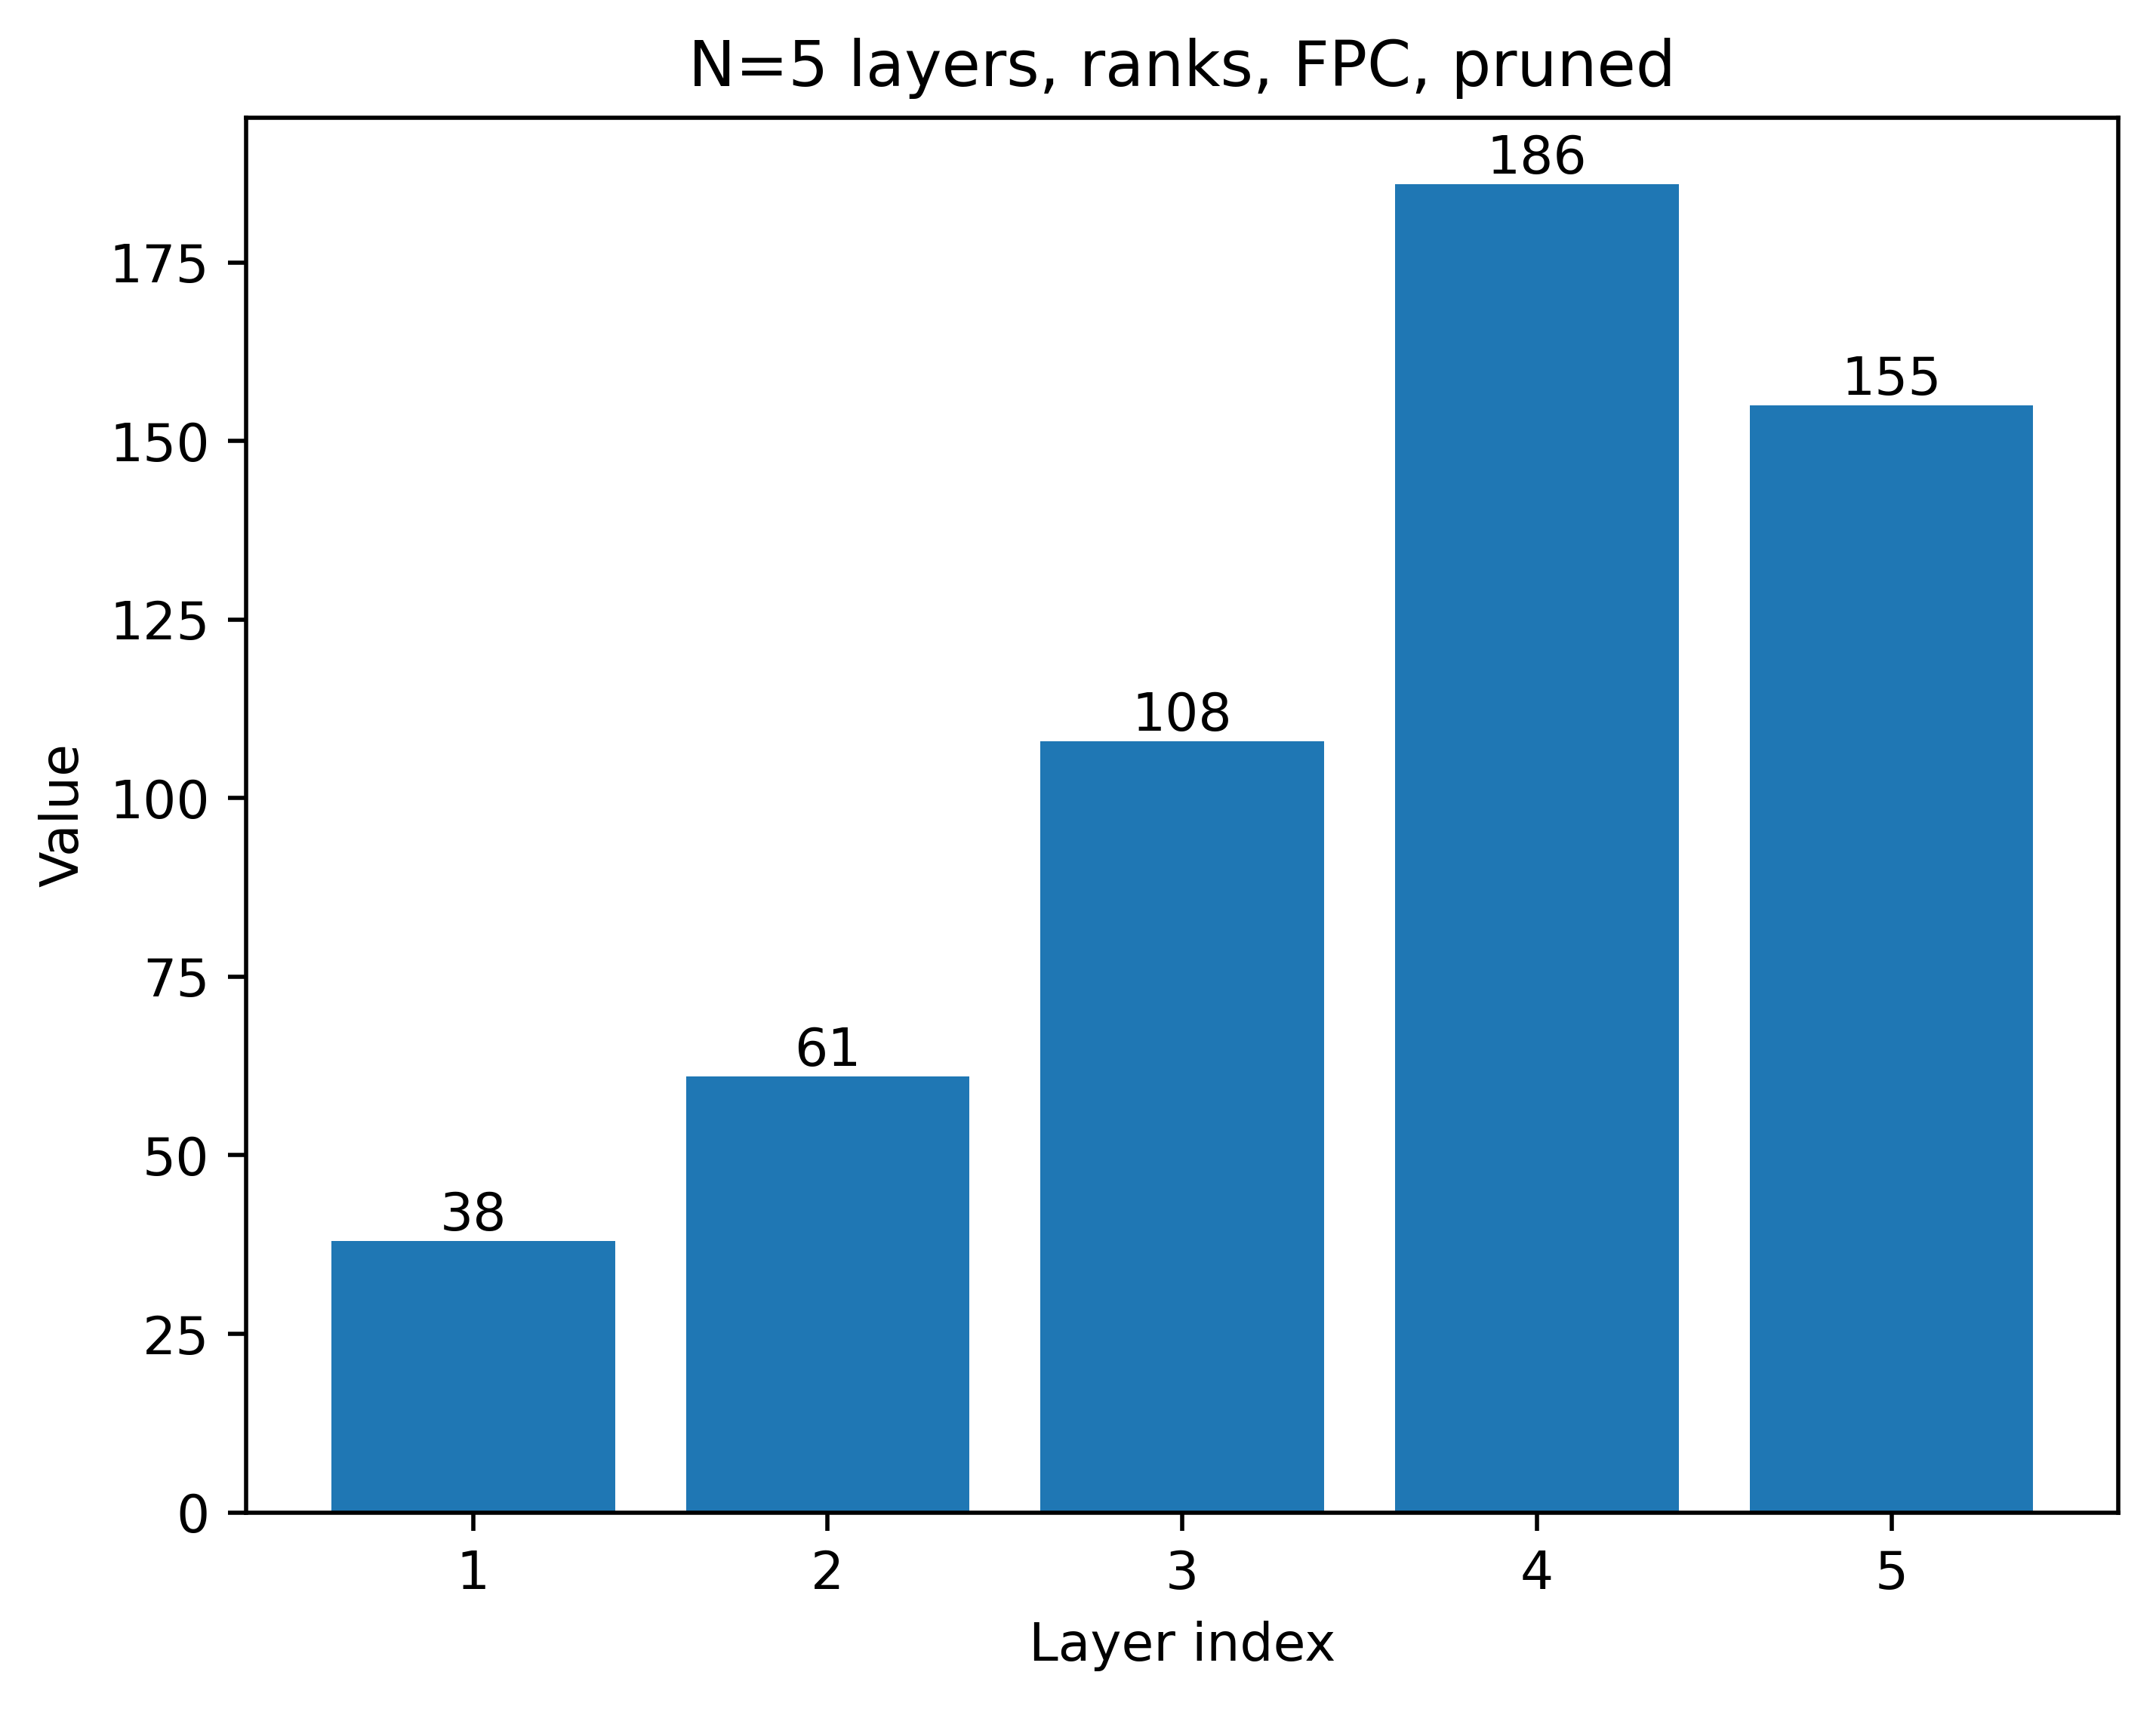

np.sum(nuclear_norms) 32403.2470703125


In [16]:
fpc_pruned_layers = apply_fpc_to_layers(vgg_layers, optimal_channels)
fpc_singular_values, fpc_nuclear_norms, fpc_ranks = inspect_layers(
    fpc_pruned_layers, name="FPC, pruned"
)

## SPSRC
https://openaccess.thecvf.com/content/WACV2024/papers/Sun_Towards_Better_Structured_Pruning_Saliency_by_Reorganizing_Convolution_WACV_2024_paper.pdf

In [17]:
def reorganize_kernel(x):
    """
    Reorganize kernel by SPSRC.

    Parameters:
    - x: torch.Tensor, size 3x3.

    Return:
    - y: torch.Tensor, size 9x9.
    """

    y = torch.eye(9) * x[1, 1]
    y[1, 0] = y[2, 1] = y[4, 3] = y[5, 4] = y[7, 6] = y[8, 7] = x[1, 0]
    y[3, 1] = y[4, 2] = y[6, 4] = y[7, 5] = x[0, 2]
    y[3, 0] = y[4, 1] = y[5, 2] = y[6, 3] = y[7, 4] = y[8, 5] = x[0, 1]
    y[4, 0] = y[5, 1] = y[7, 3] = y[8, 4] = x[0, 0]

    y[0, 1] = y[1, 2] = y[3, 4] = y[4, 5] = y[6, 7] = y[7, 8] = x[1, 2]
    y[1, 3] = y[2, 4] = y[4, 6] = y[5, 7] = x[2, 0]
    y[0, 3] = y[1, 4] = y[2, 5] = y[3, 6] = y[4, 7] = y[5, 8] = x[2, 1]
    y[0, 4] = y[1, 5] = y[3, 7] = y[4, 8] = x[2, 2]

    return y


def reorganize_filter(filter):
    """
    Reorganize filter by SPSRC.
    """

    num_kernels = filter.size(0)
    output = torch.zeros((num_kernels, 9, 9))

    for i in range(num_kernels):
        output[i] = reorganize_kernel(filter[i])

    return output


def compute_saliency_spsrc(tensor, criterion="spectral"):
    """ """

    num_filters = tensor.size(0)
    saliencies = []
    for i in range(num_filters):
        filter = tensor[i]
        filter_reorganized = reorganize_filter(filter)
        if criterion == "nuclear":
            saliency = nuclear_norm(filter_reorganized)
        elif criterion == "spectral":
            saliency = spectral_norm(filter_reorganized)
        elif criterion == "frobenius":
            saliency = frobenius_norm(filter_reorganized)
        saliencies.append(saliency)

    return saliencies


def apply_spsrc_to_layers(vgg_layers, optimal_channels, criterion="spectral"):
    """
    Apply SPSRC to each layer in vgg_layers based on the optimal_channels.

    Parameters:
    - vgg_layers: list of torch.Tensor, list of layer tensors
    - optimal_channels: list, number of filters to keep in each layer
    - criterion: str, spectral, nuclear or frobenius

    Returns:
    - pruned_layers: list of torch.Tensor, list of layer tensors after SPSRC
    """

    pruned_layers = []

    for i, (layer_tensor, num_centroids) in enumerate(
        zip(vgg_layers, optimal_channels)
    ):
        print(f"Current layer: {i + 1}")
        saliency = compute_saliency_spsrc(
            layer_tensor, criterion=criterion
        )  # is a list of float value, containing saliency of each filter from 1 to N
        # get indices of top k most important filters among N filters
        top_k_indices = (-np.array(saliency)).argsort()[
            :num_centroids
        ]  # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        pruned_layer = layer_tensor[top_k_indices]
        pruned_layers.append(pruned_layer)

    return pruned_layers

In [18]:
ori = torch.randn((3, 3))
print(ori)
reorgannized = reorganize_kernel(ori)
print(reorgannized)

tensor([[-0.3650,  0.0252,  0.4891],
        [-2.1478,  0.9632,  0.0083],
        [-0.0855,  1.5118, -0.0073]])
tensor([[ 0.9632,  0.0083,  0.0000,  1.5118, -0.0073,  0.0000,  0.0000,  0.0000,
          0.0000],
        [-2.1478,  0.9632,  0.0083, -0.0855,  1.5118, -0.0073,  0.0000,  0.0000,
          0.0000],
        [ 0.0000, -2.1478,  0.9632,  0.0000, -0.0855,  1.5118,  0.0000,  0.0000,
          0.0000],
        [ 0.0252,  0.4891,  0.0000,  0.9632,  0.0083,  0.0000,  1.5118, -0.0073,
          0.0000],
        [-0.3650,  0.0252,  0.4891, -2.1478,  0.9632,  0.0083, -0.0855,  1.5118,
         -0.0073],
        [ 0.0000, -0.3650,  0.0252,  0.0000, -2.1478,  0.9632,  0.0000, -0.0855,
          1.5118],
        [ 0.0000,  0.0000,  0.0000,  0.0252,  0.4891,  0.0000,  0.9632,  0.0083,
          0.0000],
        [ 0.0000,  0.0000,  0.0000, -0.3650,  0.0252,  0.4891, -2.1478,  0.9632,
          0.0083],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.3650,  0.0252,  0.0000, -2.1478,
       

### nuclear

Current layer: 1
Current layer: 2
Current layer: 3
Current layer: 4
Current layer: 5


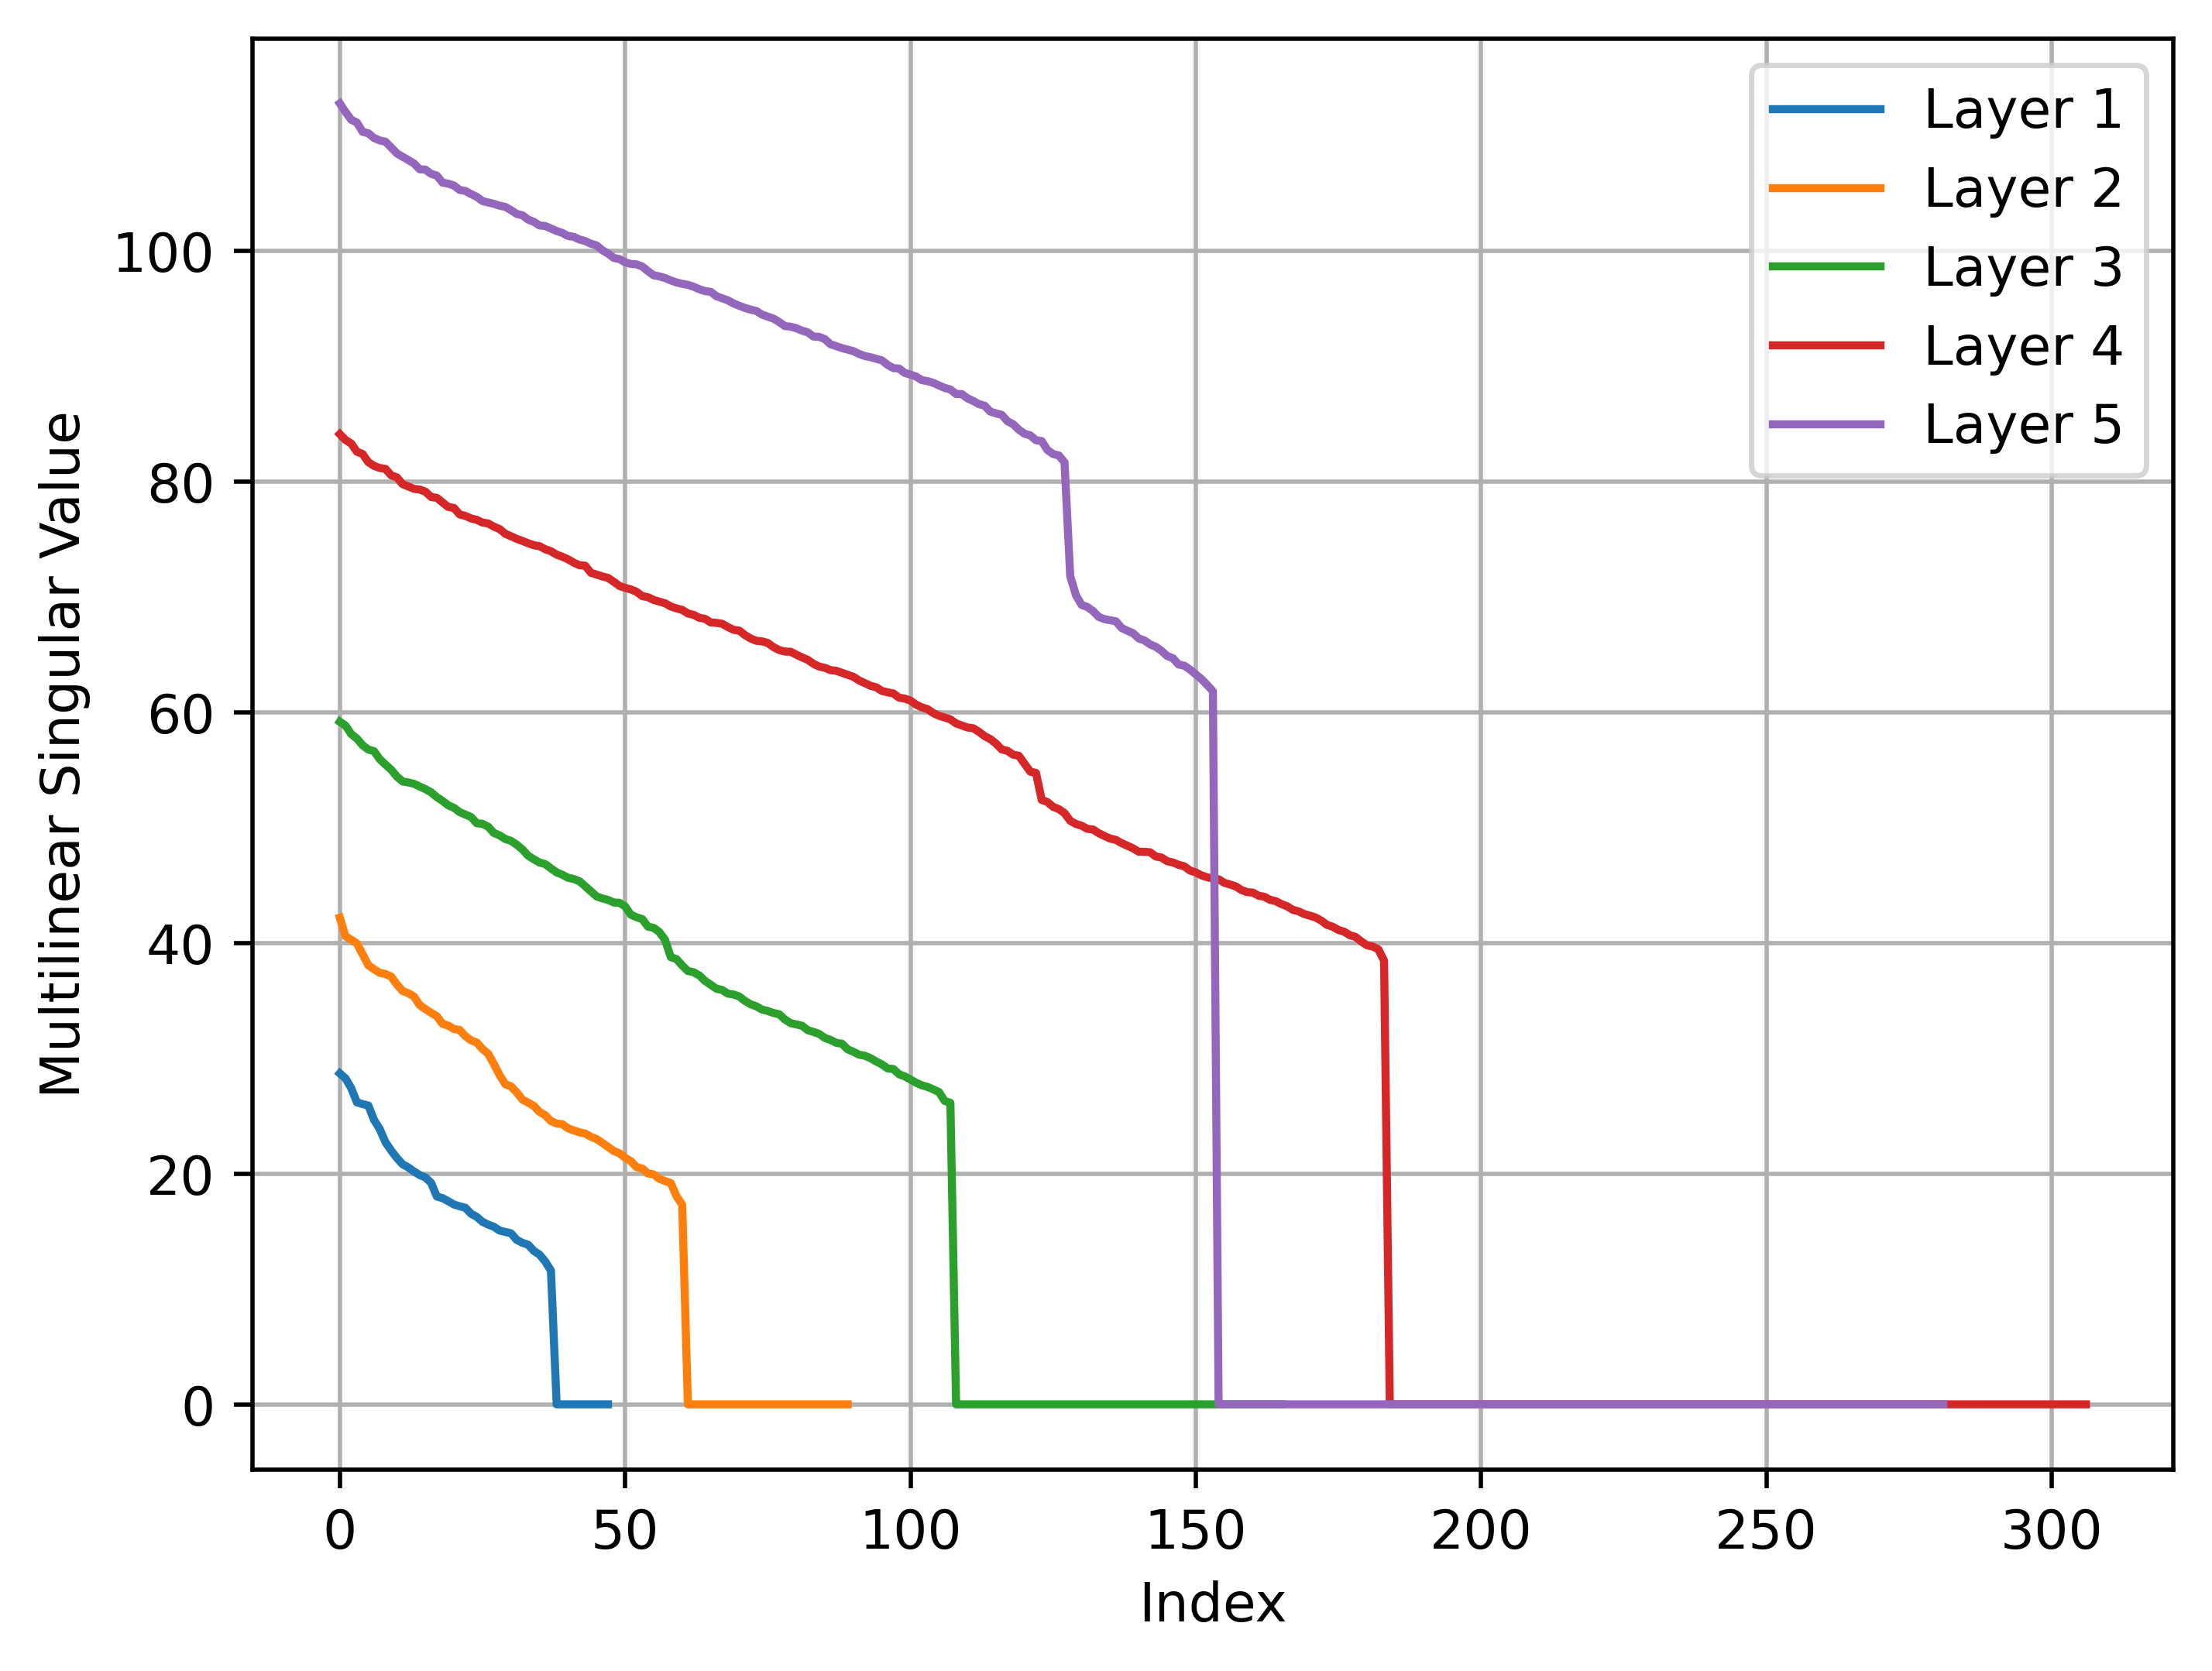

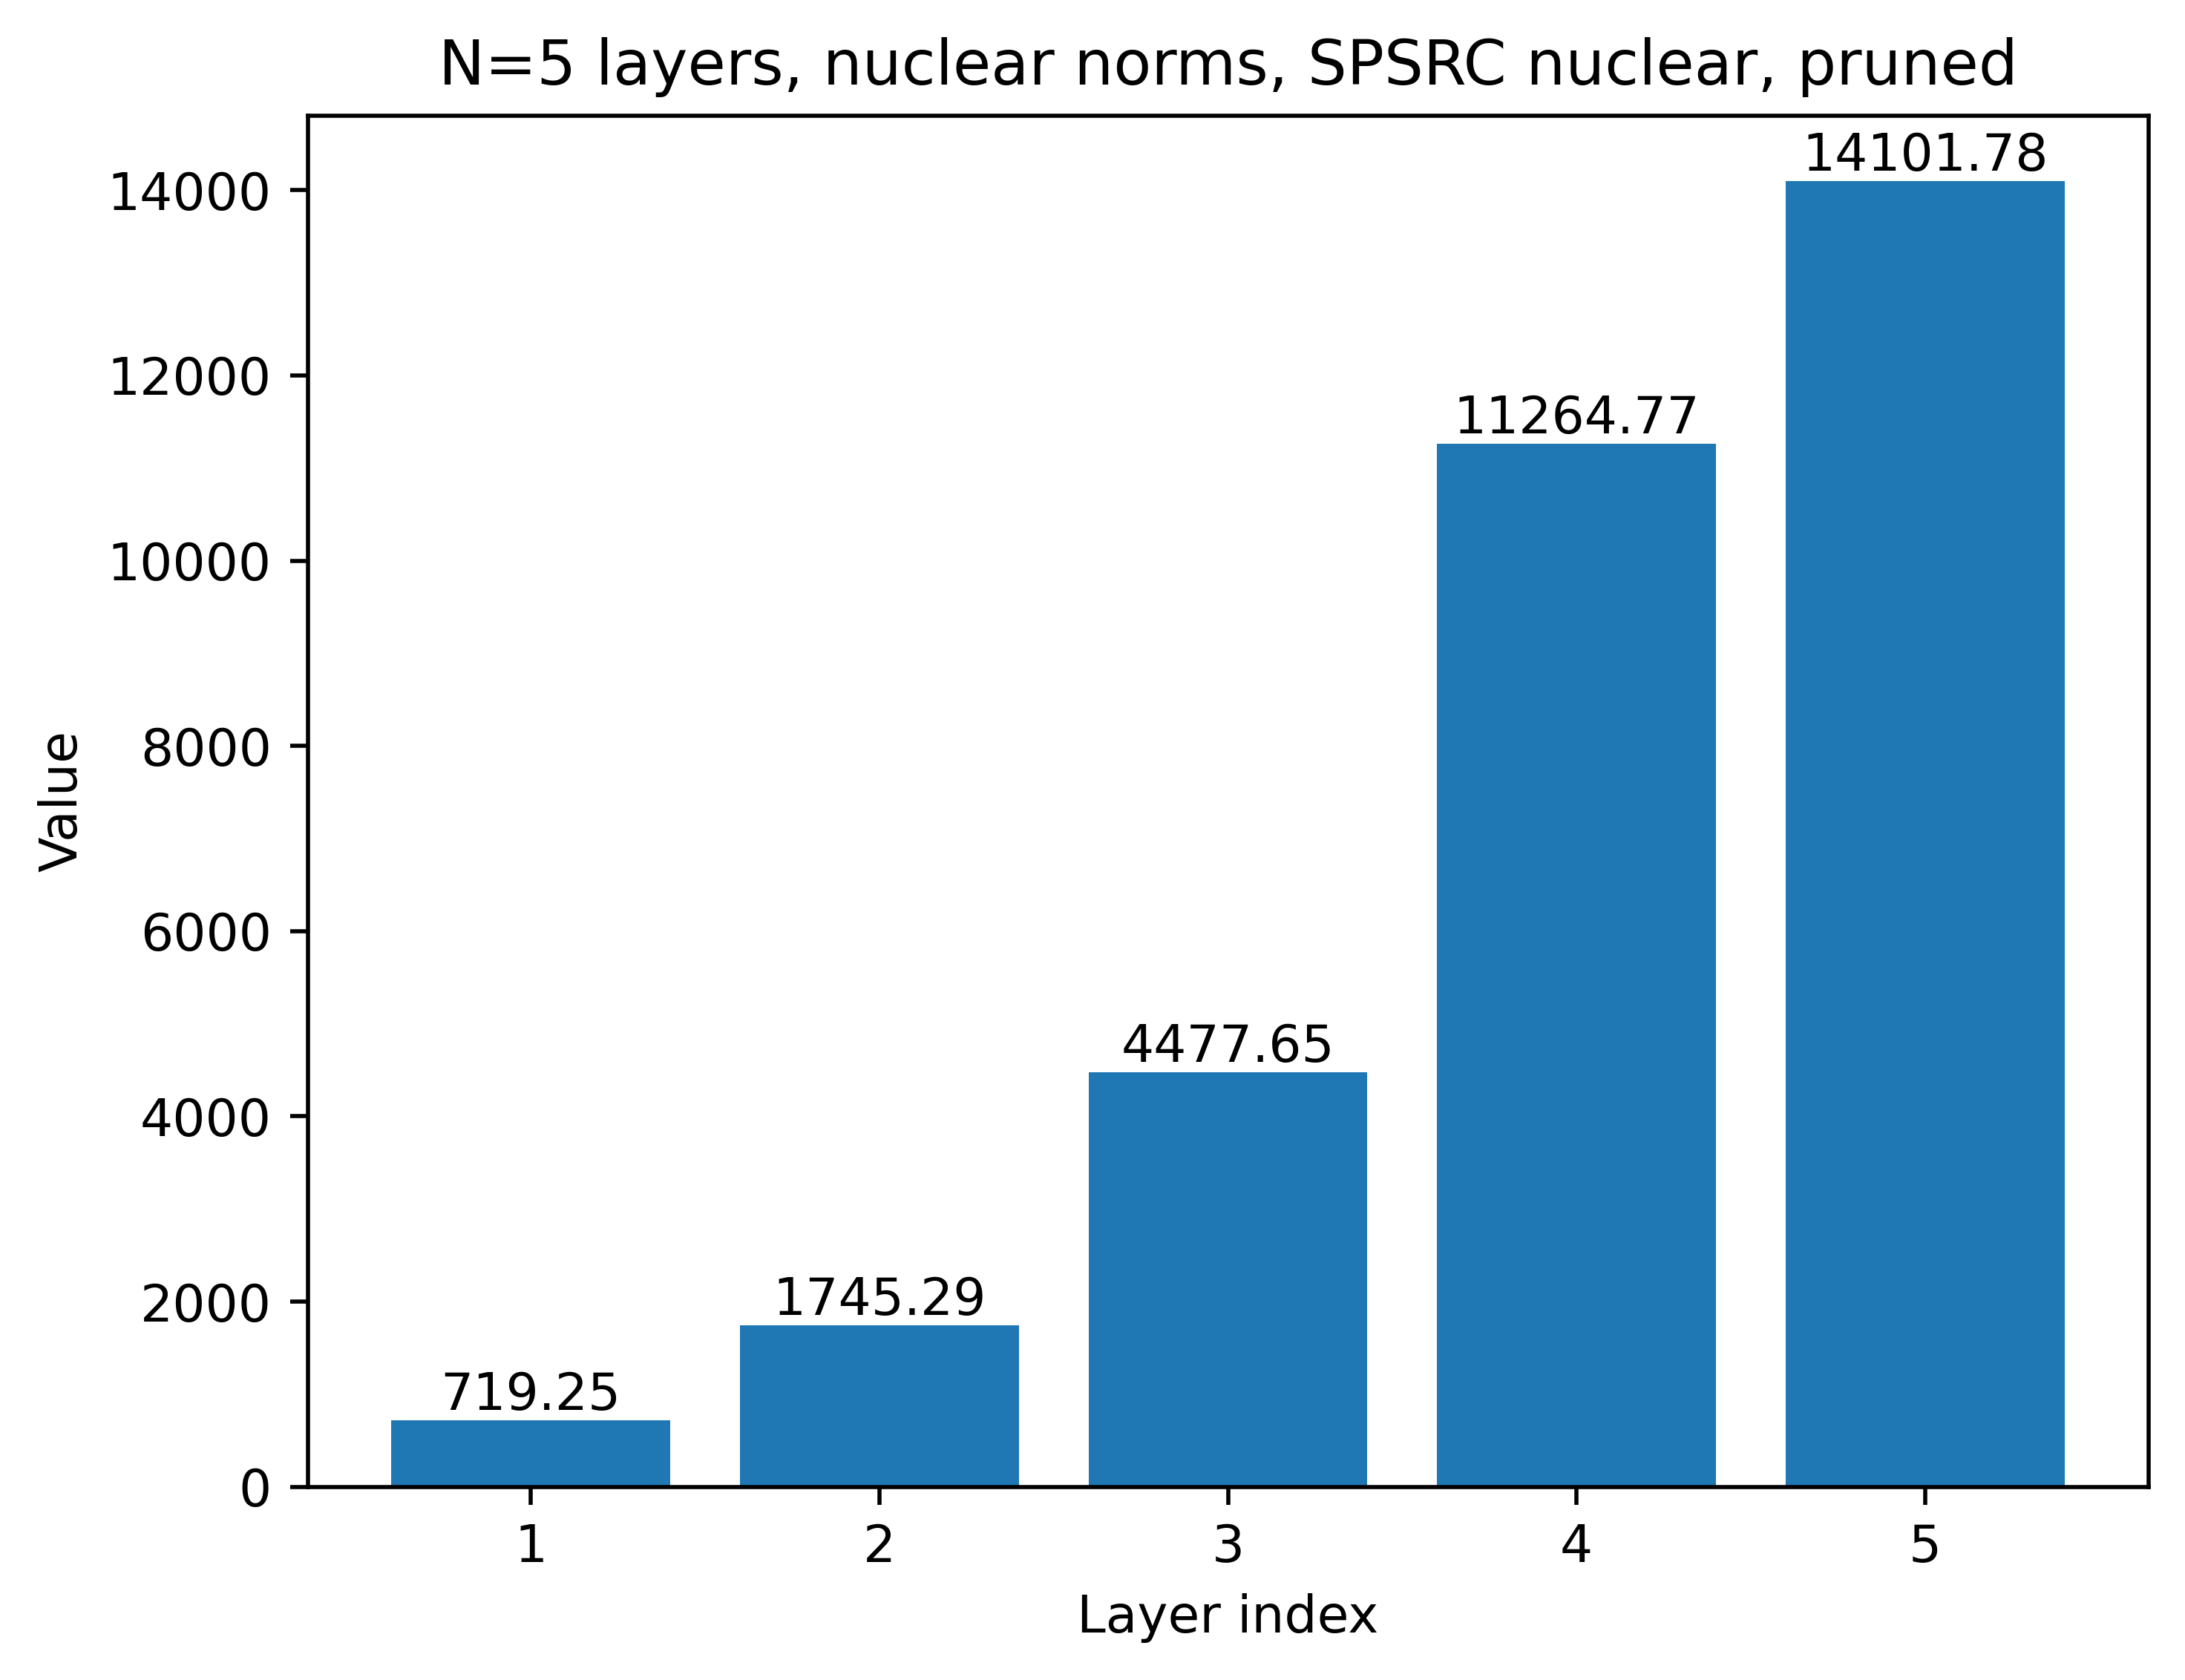

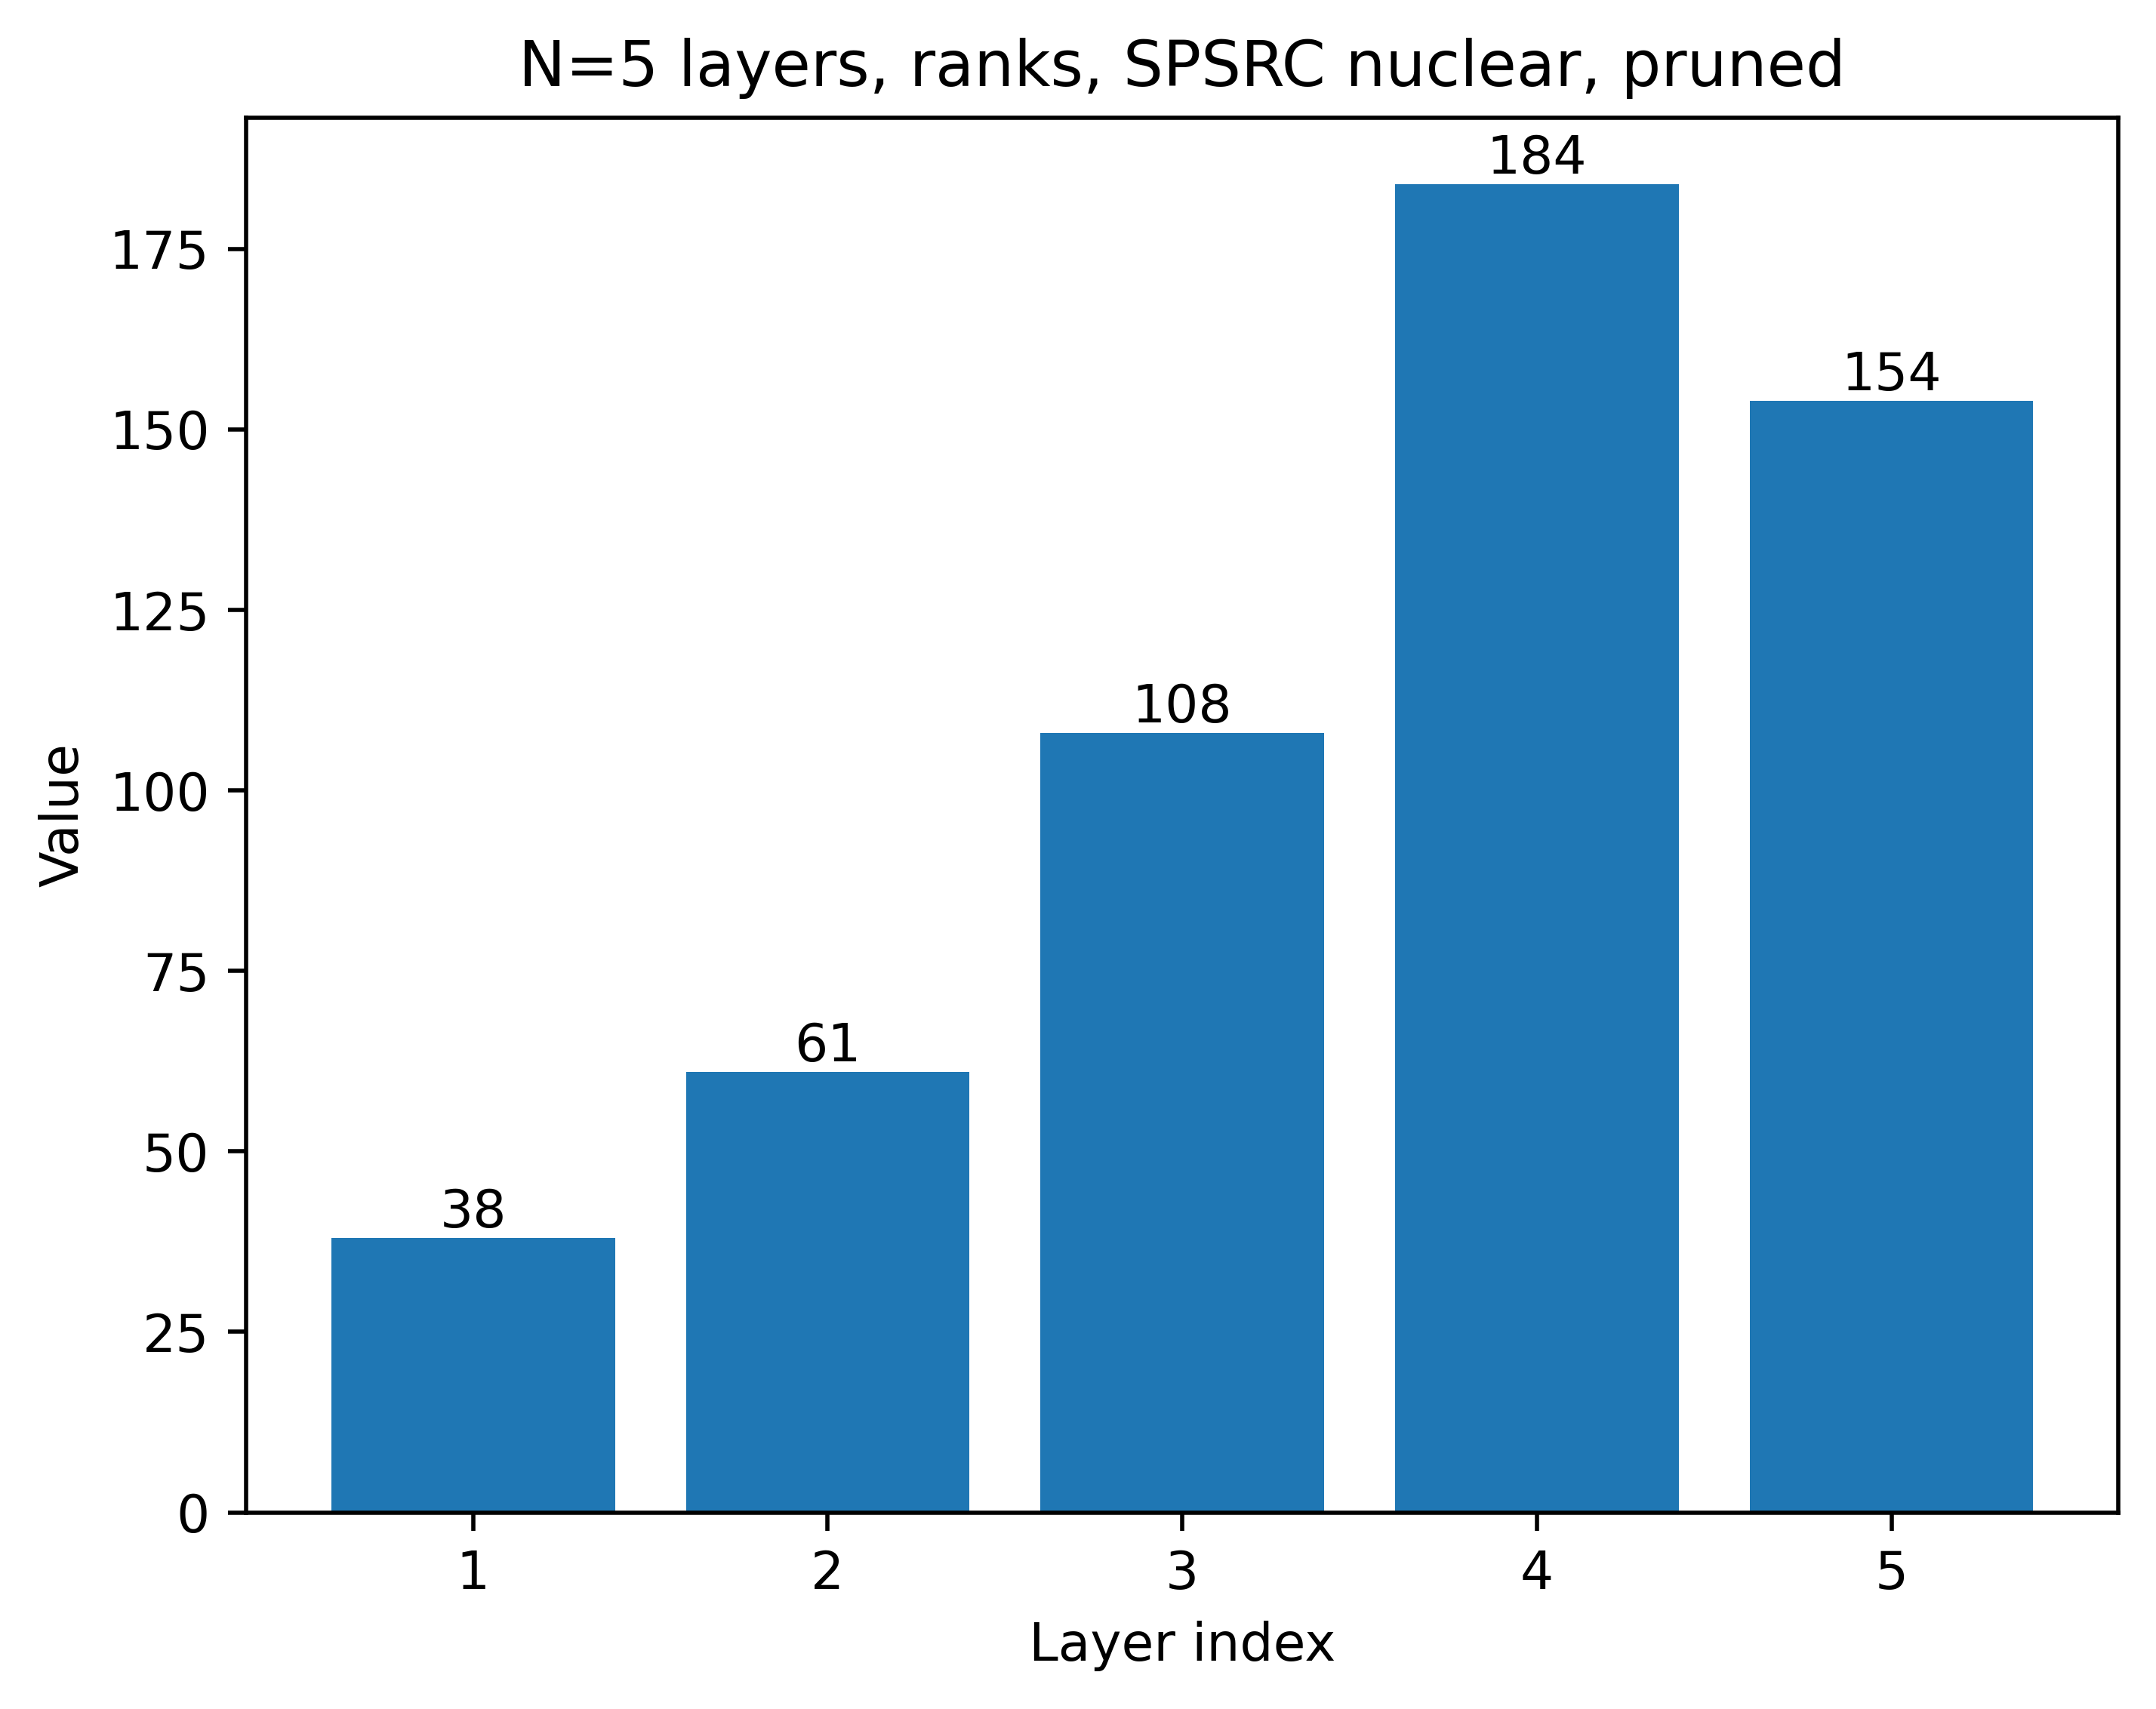

np.sum(nuclear_norms) 32308.740295410156


In [19]:
spsrc_nuclear_pruned_layers = apply_spsrc_to_layers(
    vgg_layers, optimal_channels, criterion="nuclear"
)
spsrc_nuclear_singular_values, spsrc_nuclear_nuclear_norms, spsrc_nuclear_ranks = (
    inspect_layers(spsrc_nuclear_pruned_layers, name="SPSRC nuclear, pruned")
)

### spectral

Current layer: 1
Current layer: 2
Current layer: 3
Current layer: 4
Current layer: 5


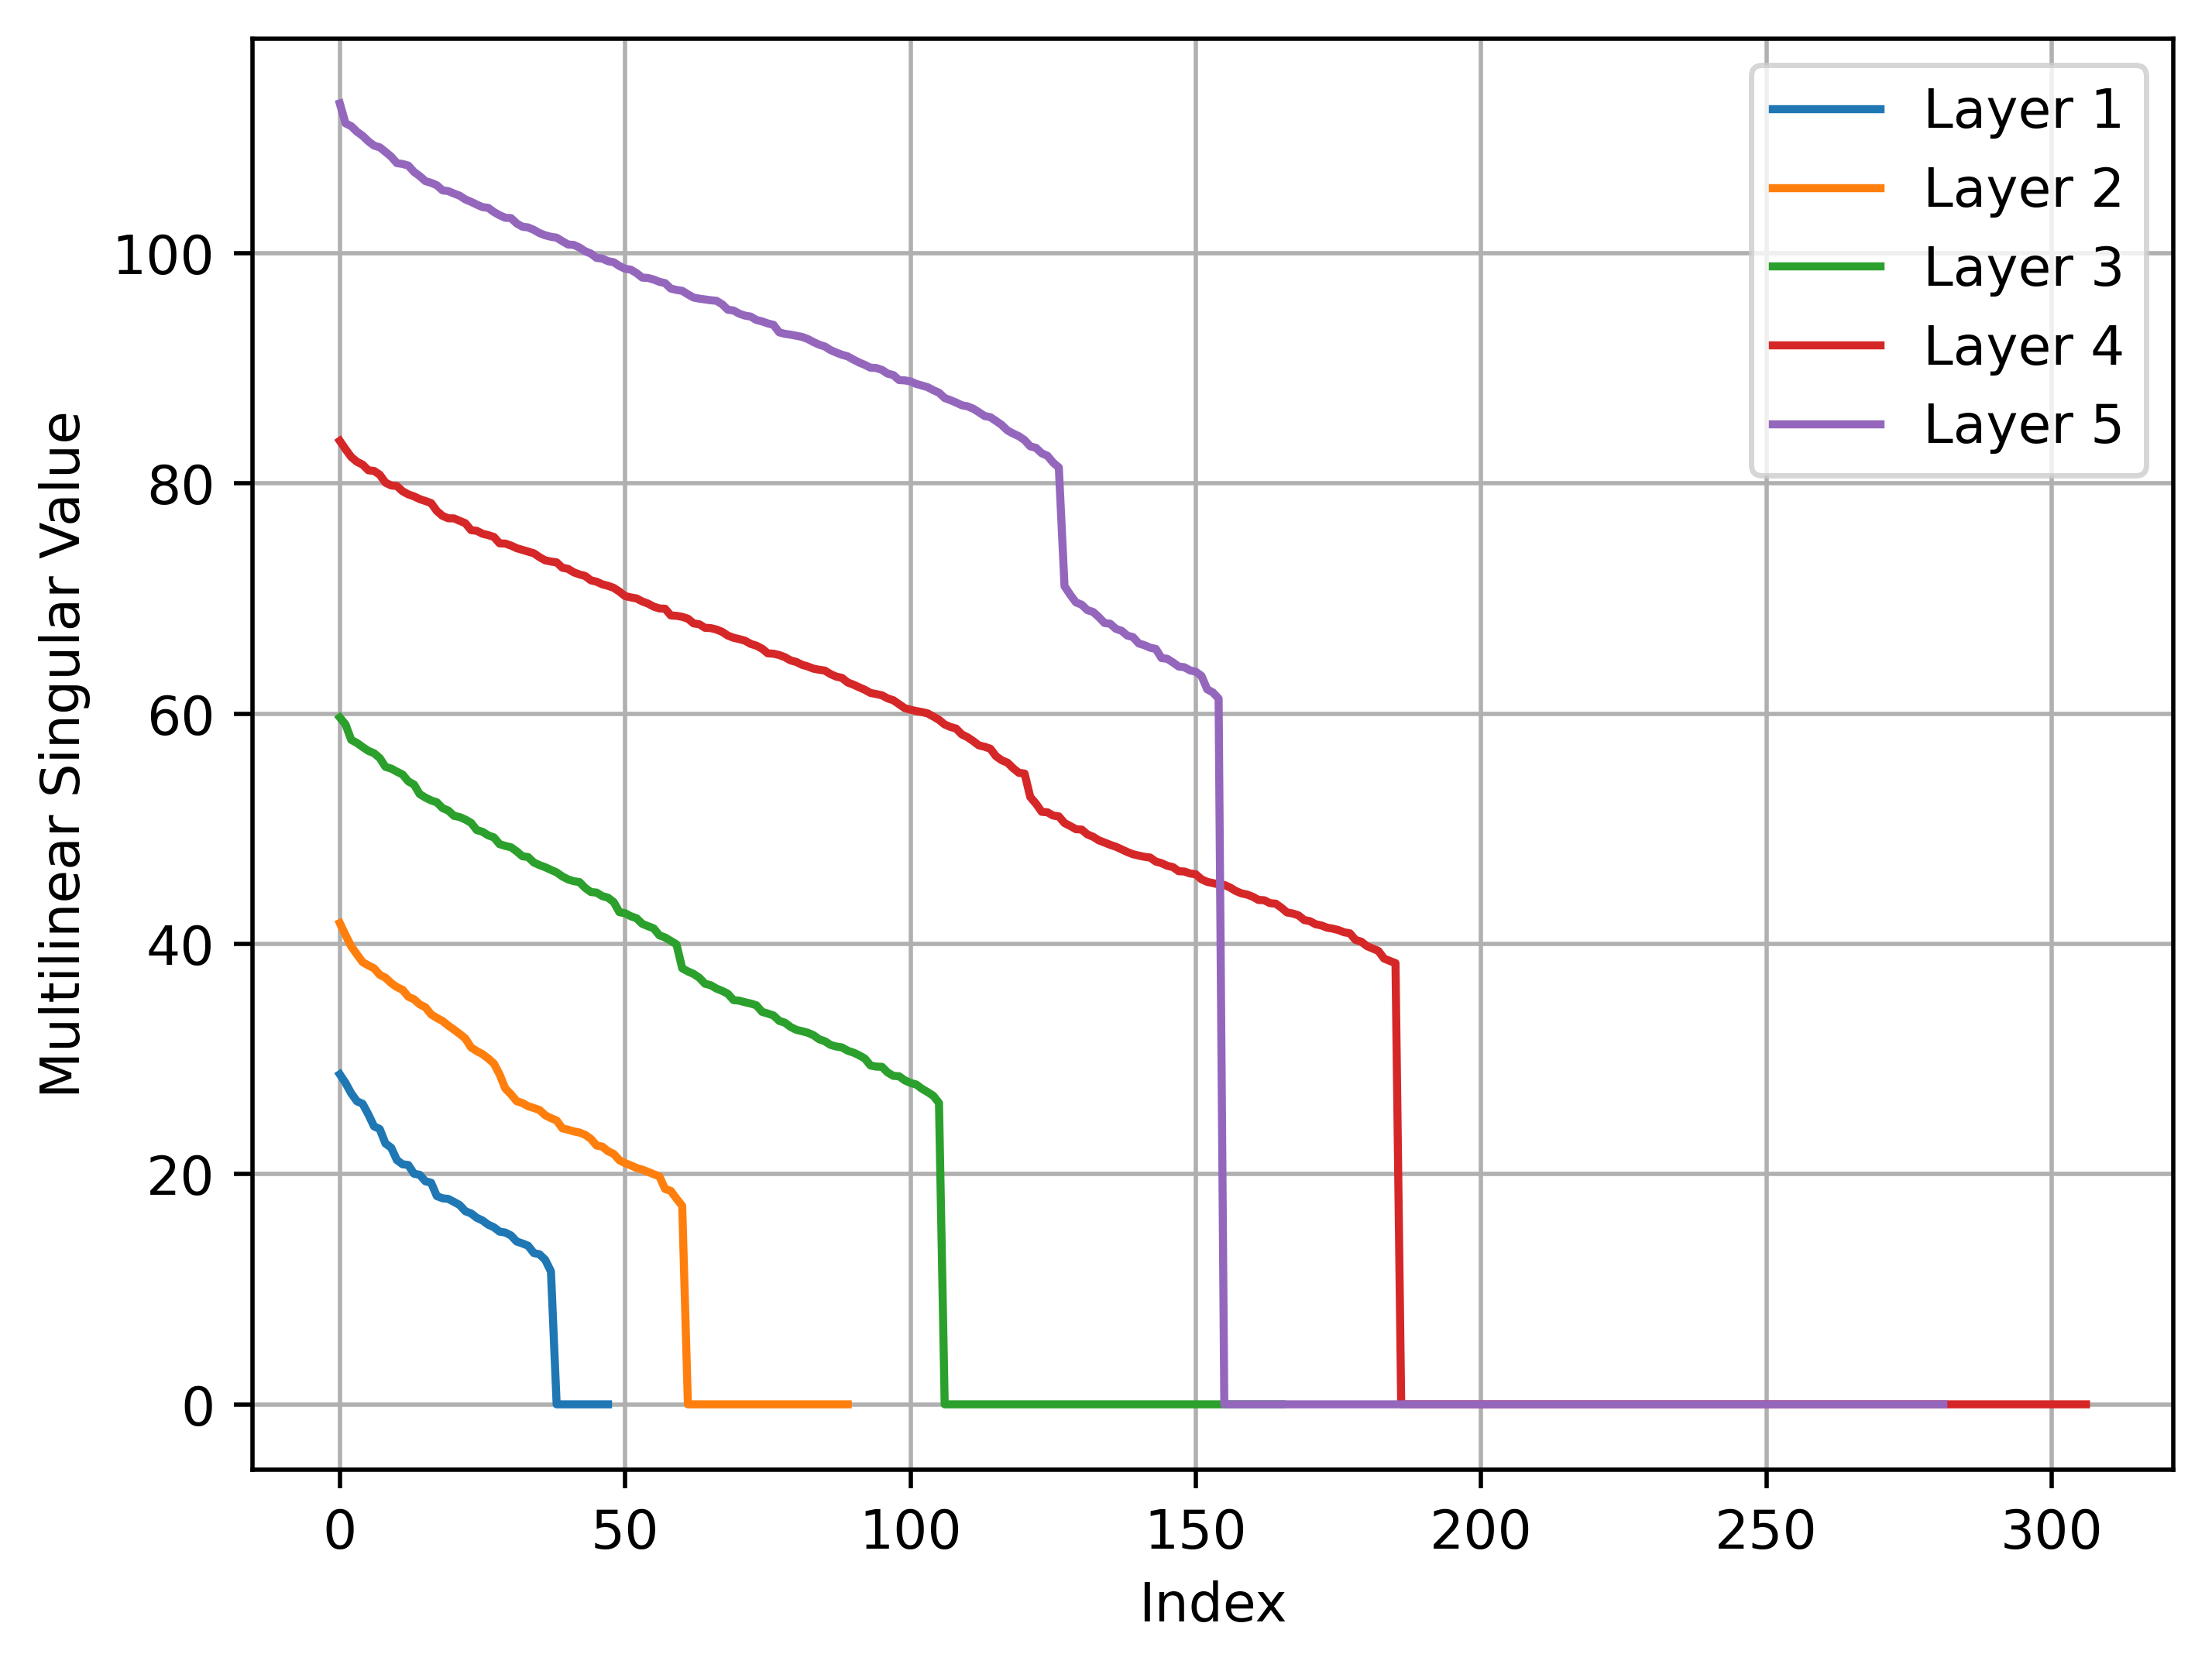

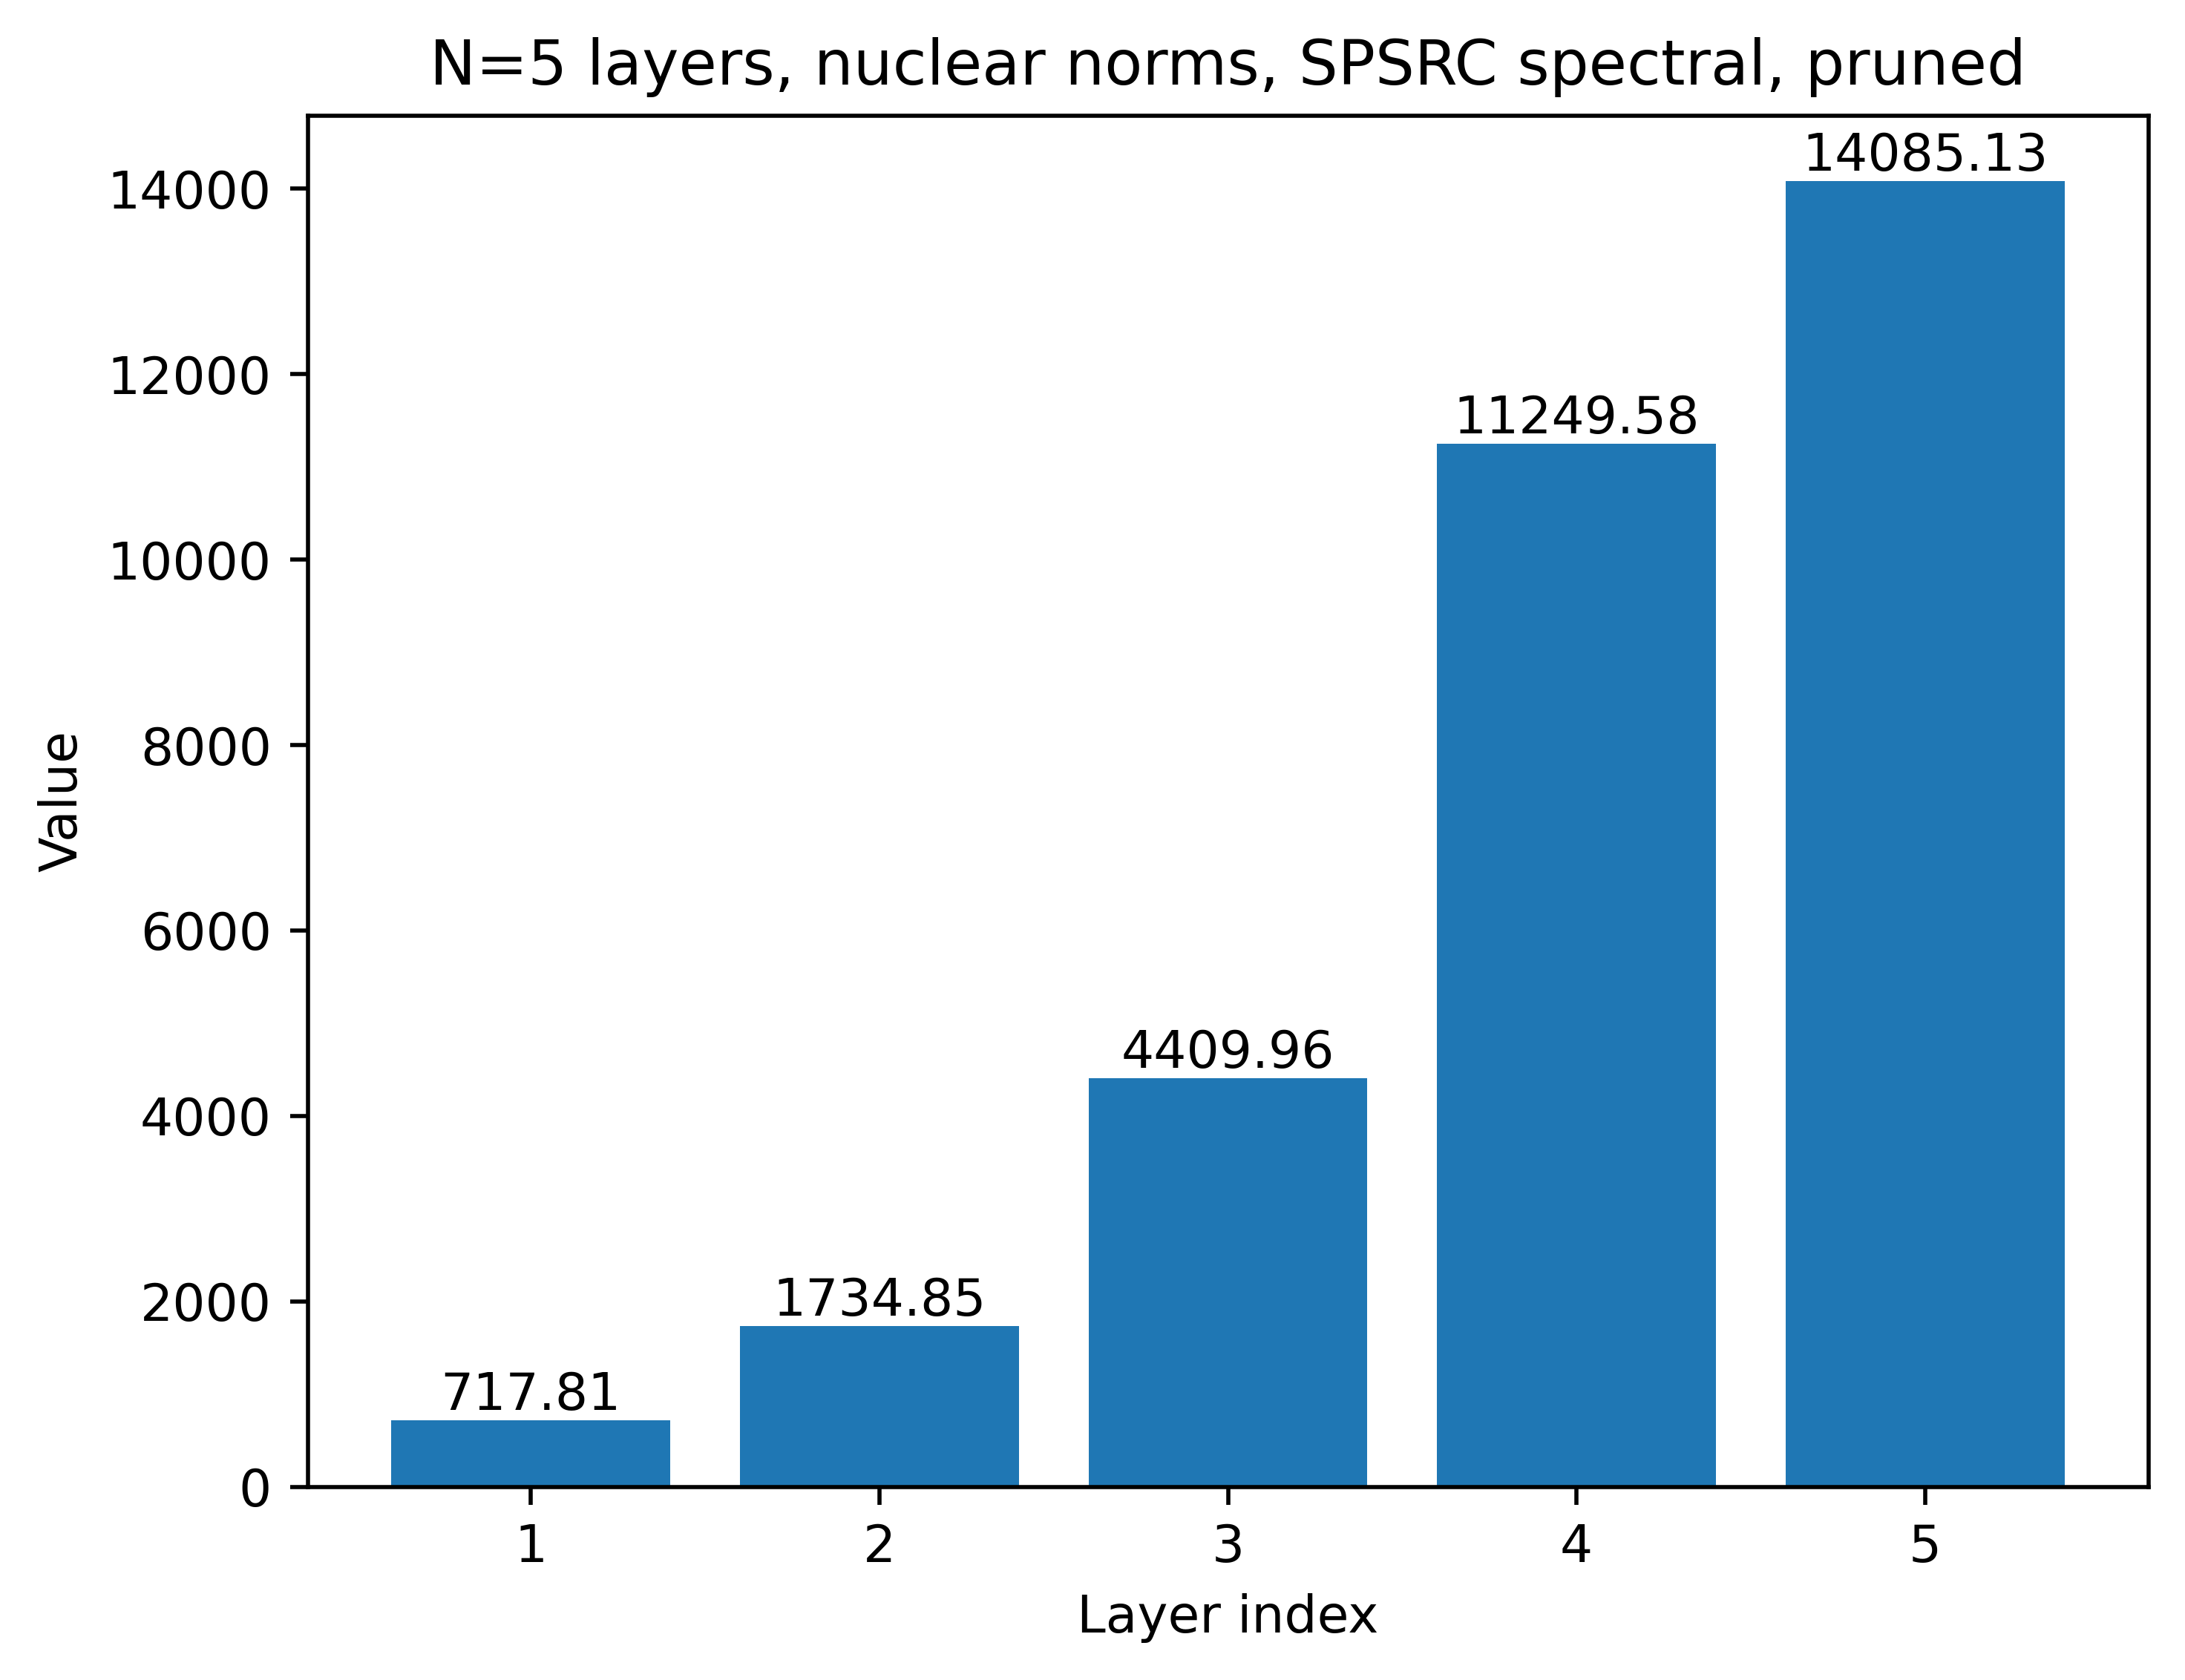

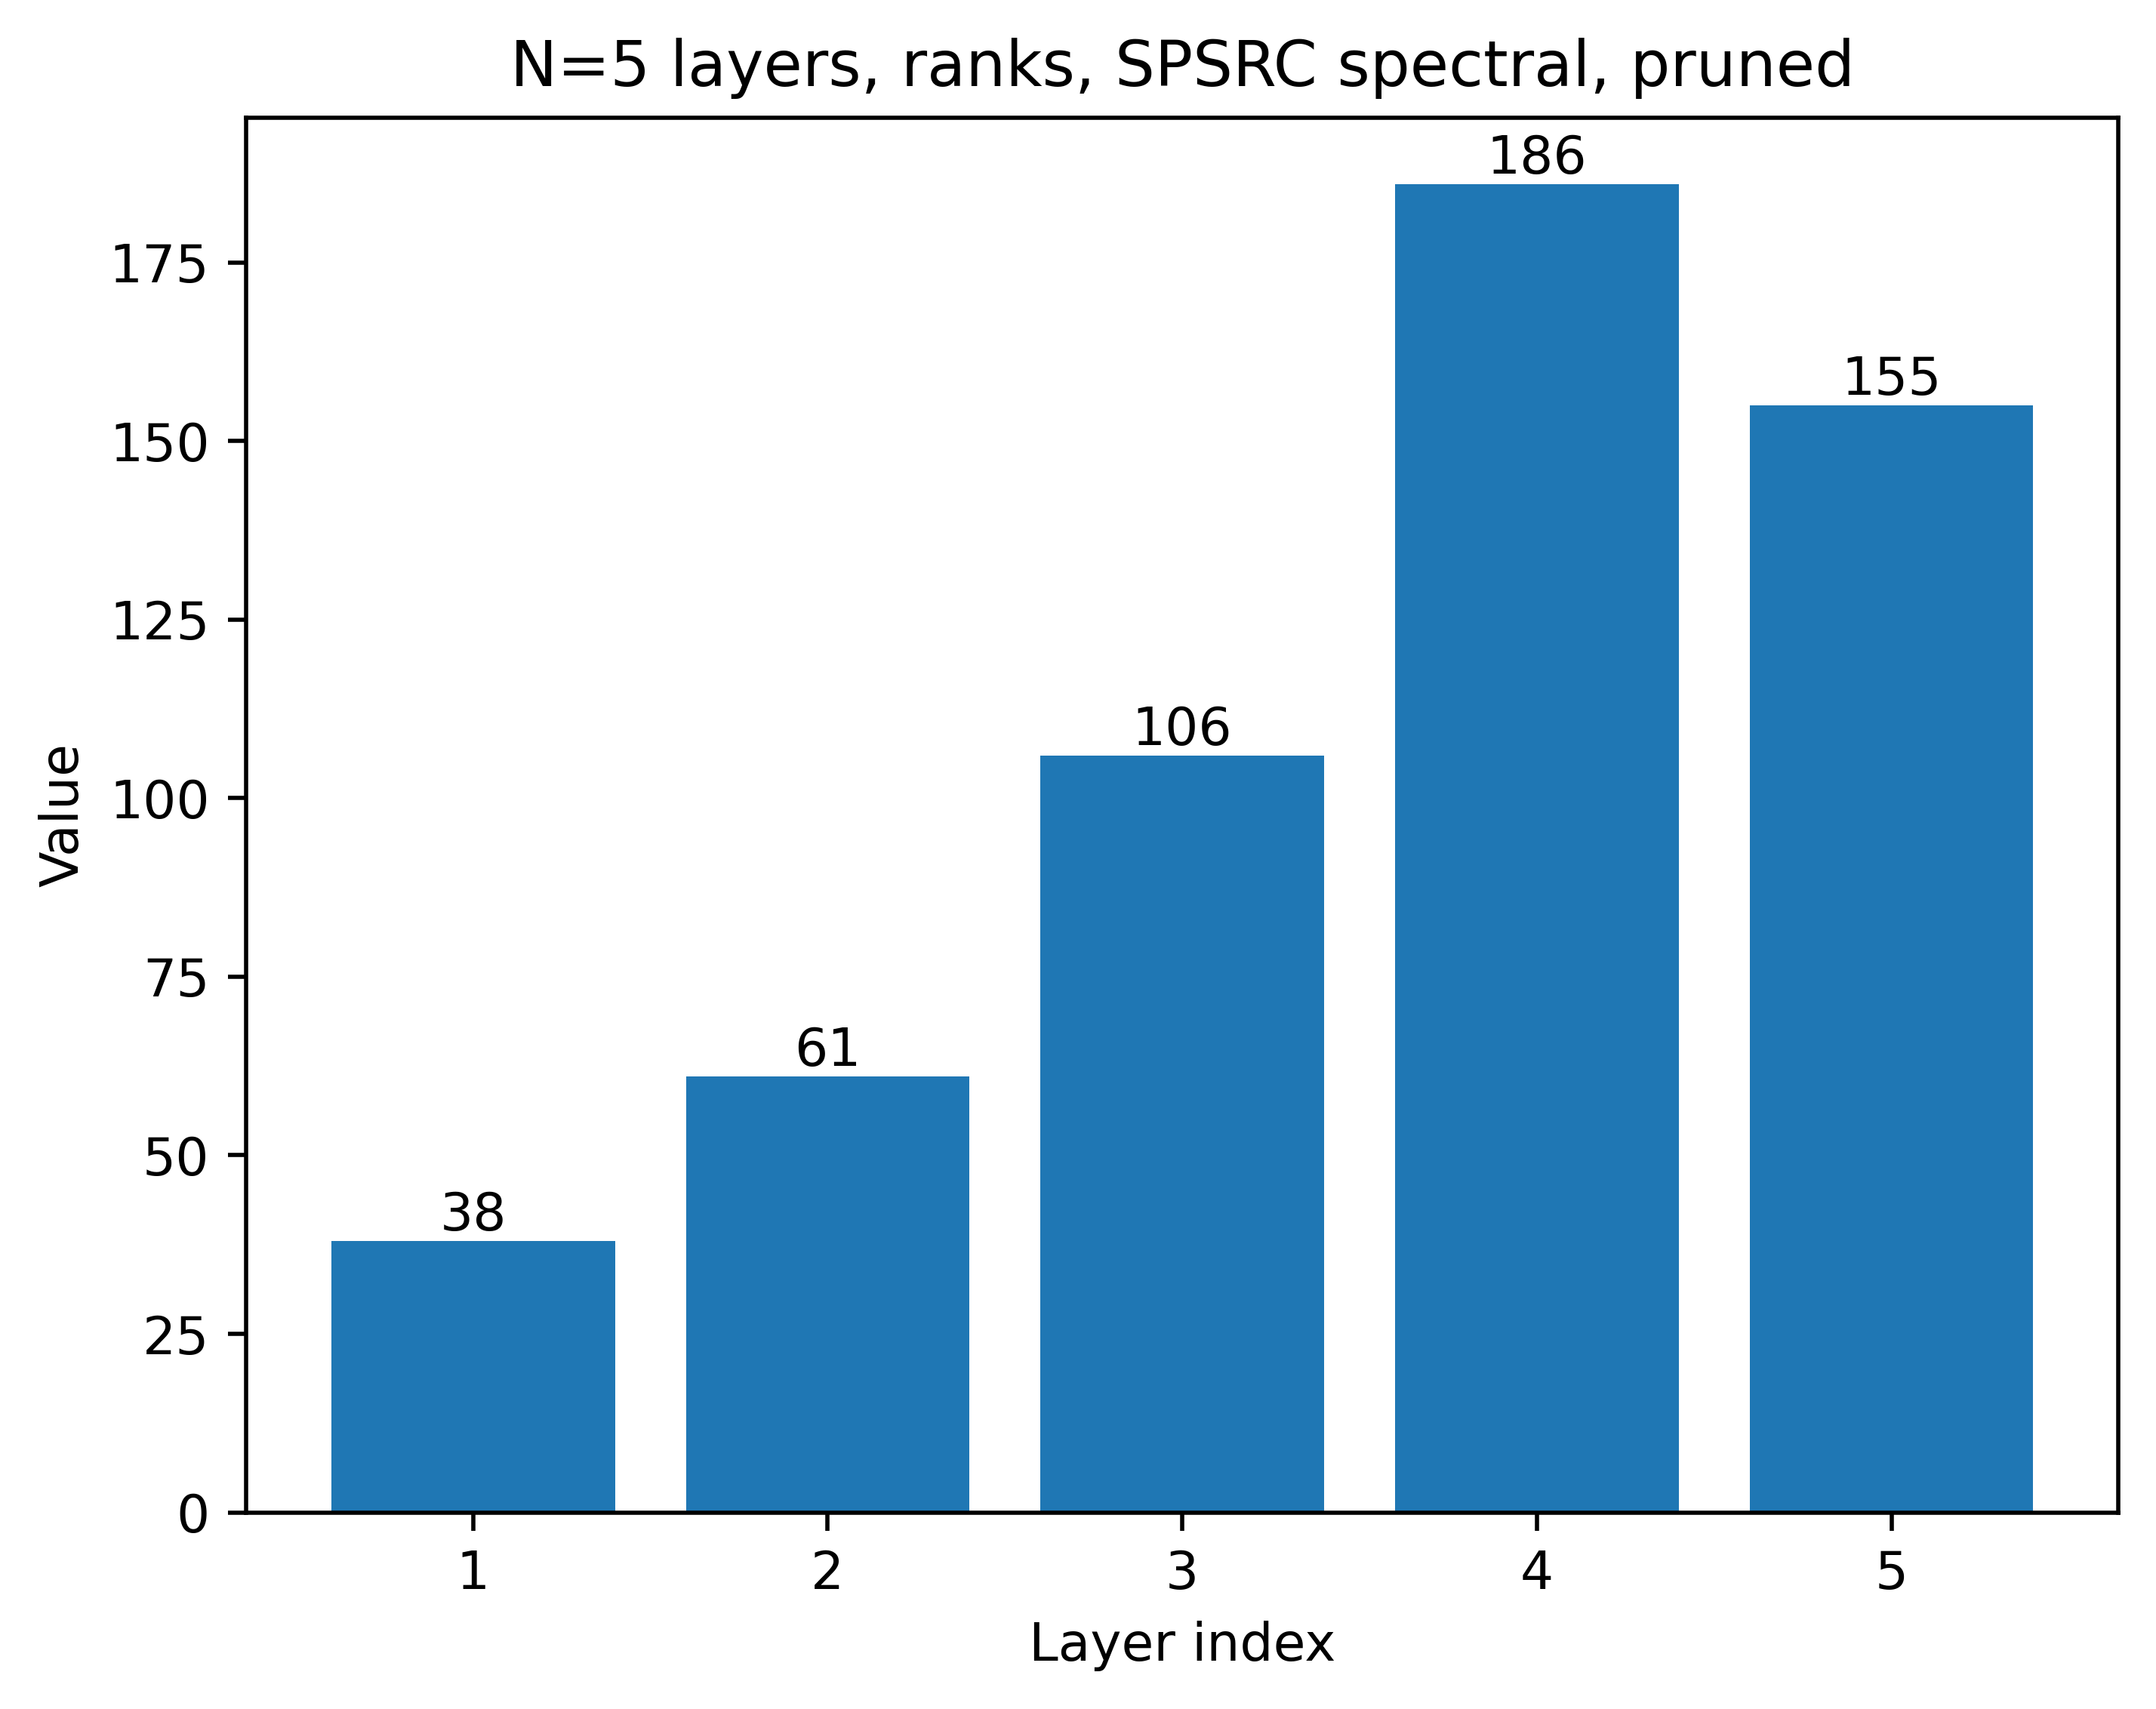

np.sum(nuclear_norms) 32197.328002929688


In [20]:
spsrc_spectral_pruned_layers = apply_spsrc_to_layers(
    vgg_layers, optimal_channels, criterion="spectral"
)
spsrc_spectral_singular_values, spsrc_spectral_nuclear_norms, spsrc_spectral_ranks = (
    inspect_layers(spsrc_spectral_pruned_layers, name="SPSRC spectral, pruned")
)

### frobenius

Current layer: 1
Current layer: 2
Current layer: 3
Current layer: 4
Current layer: 5


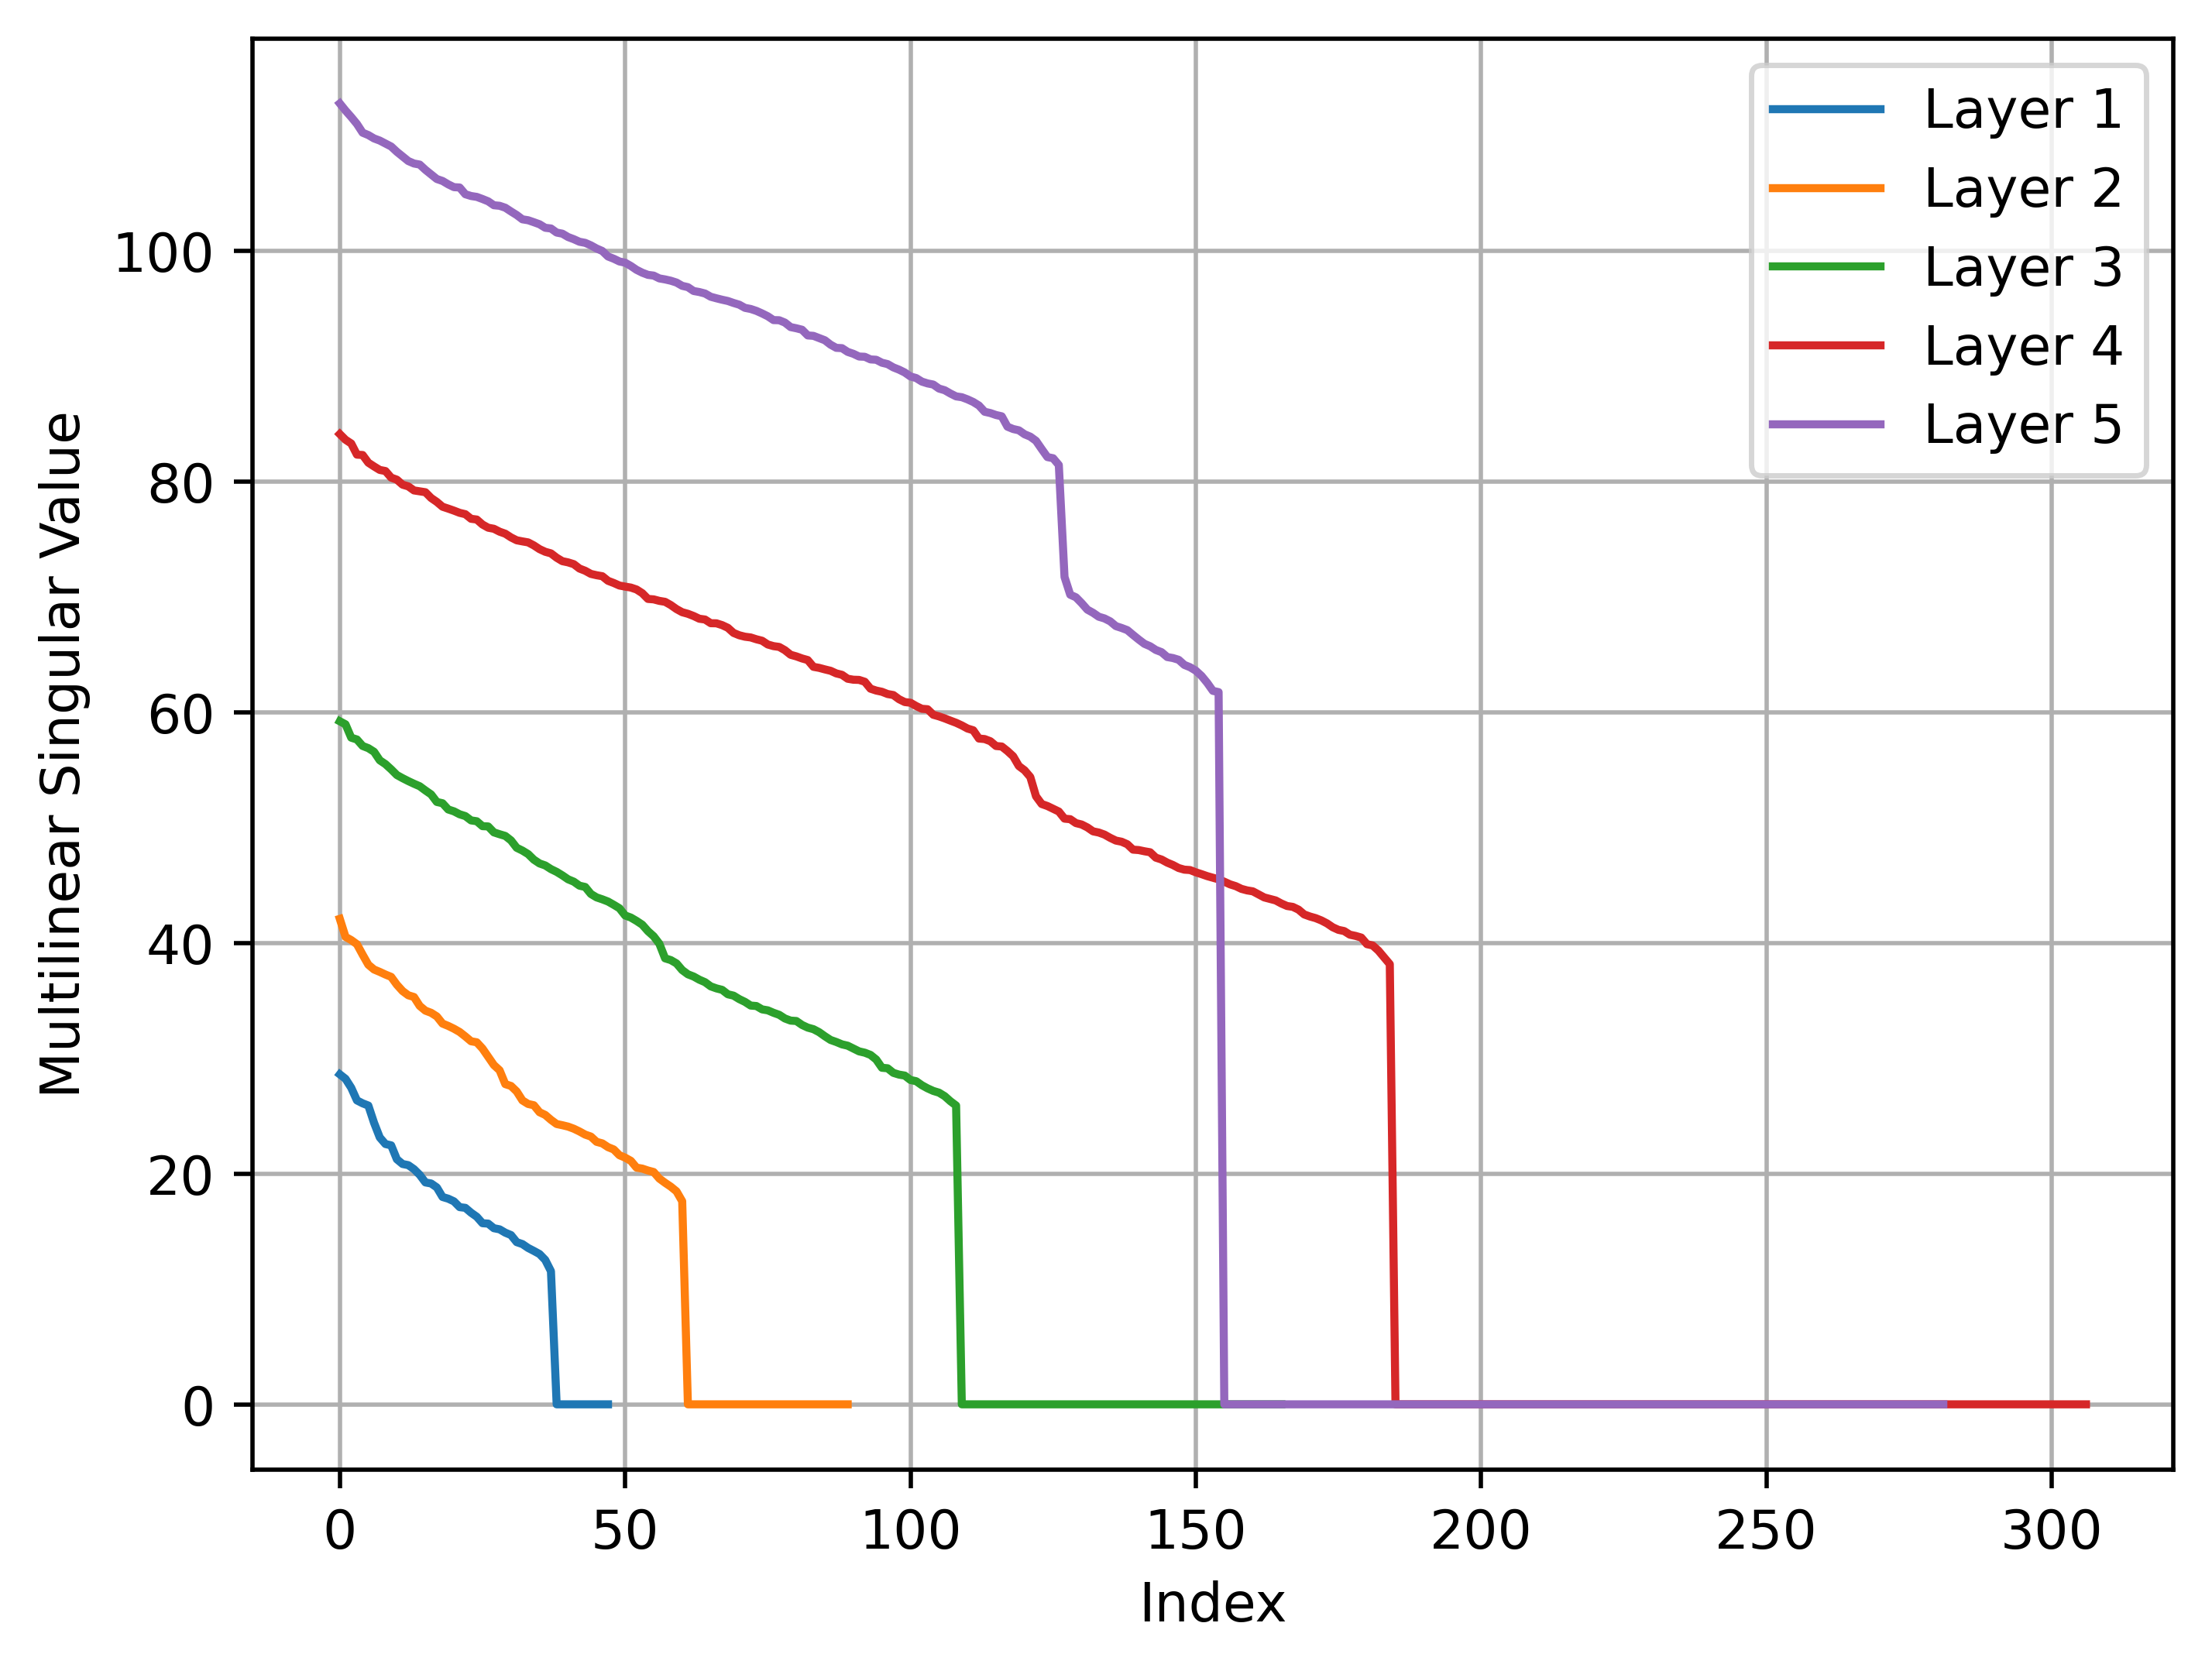

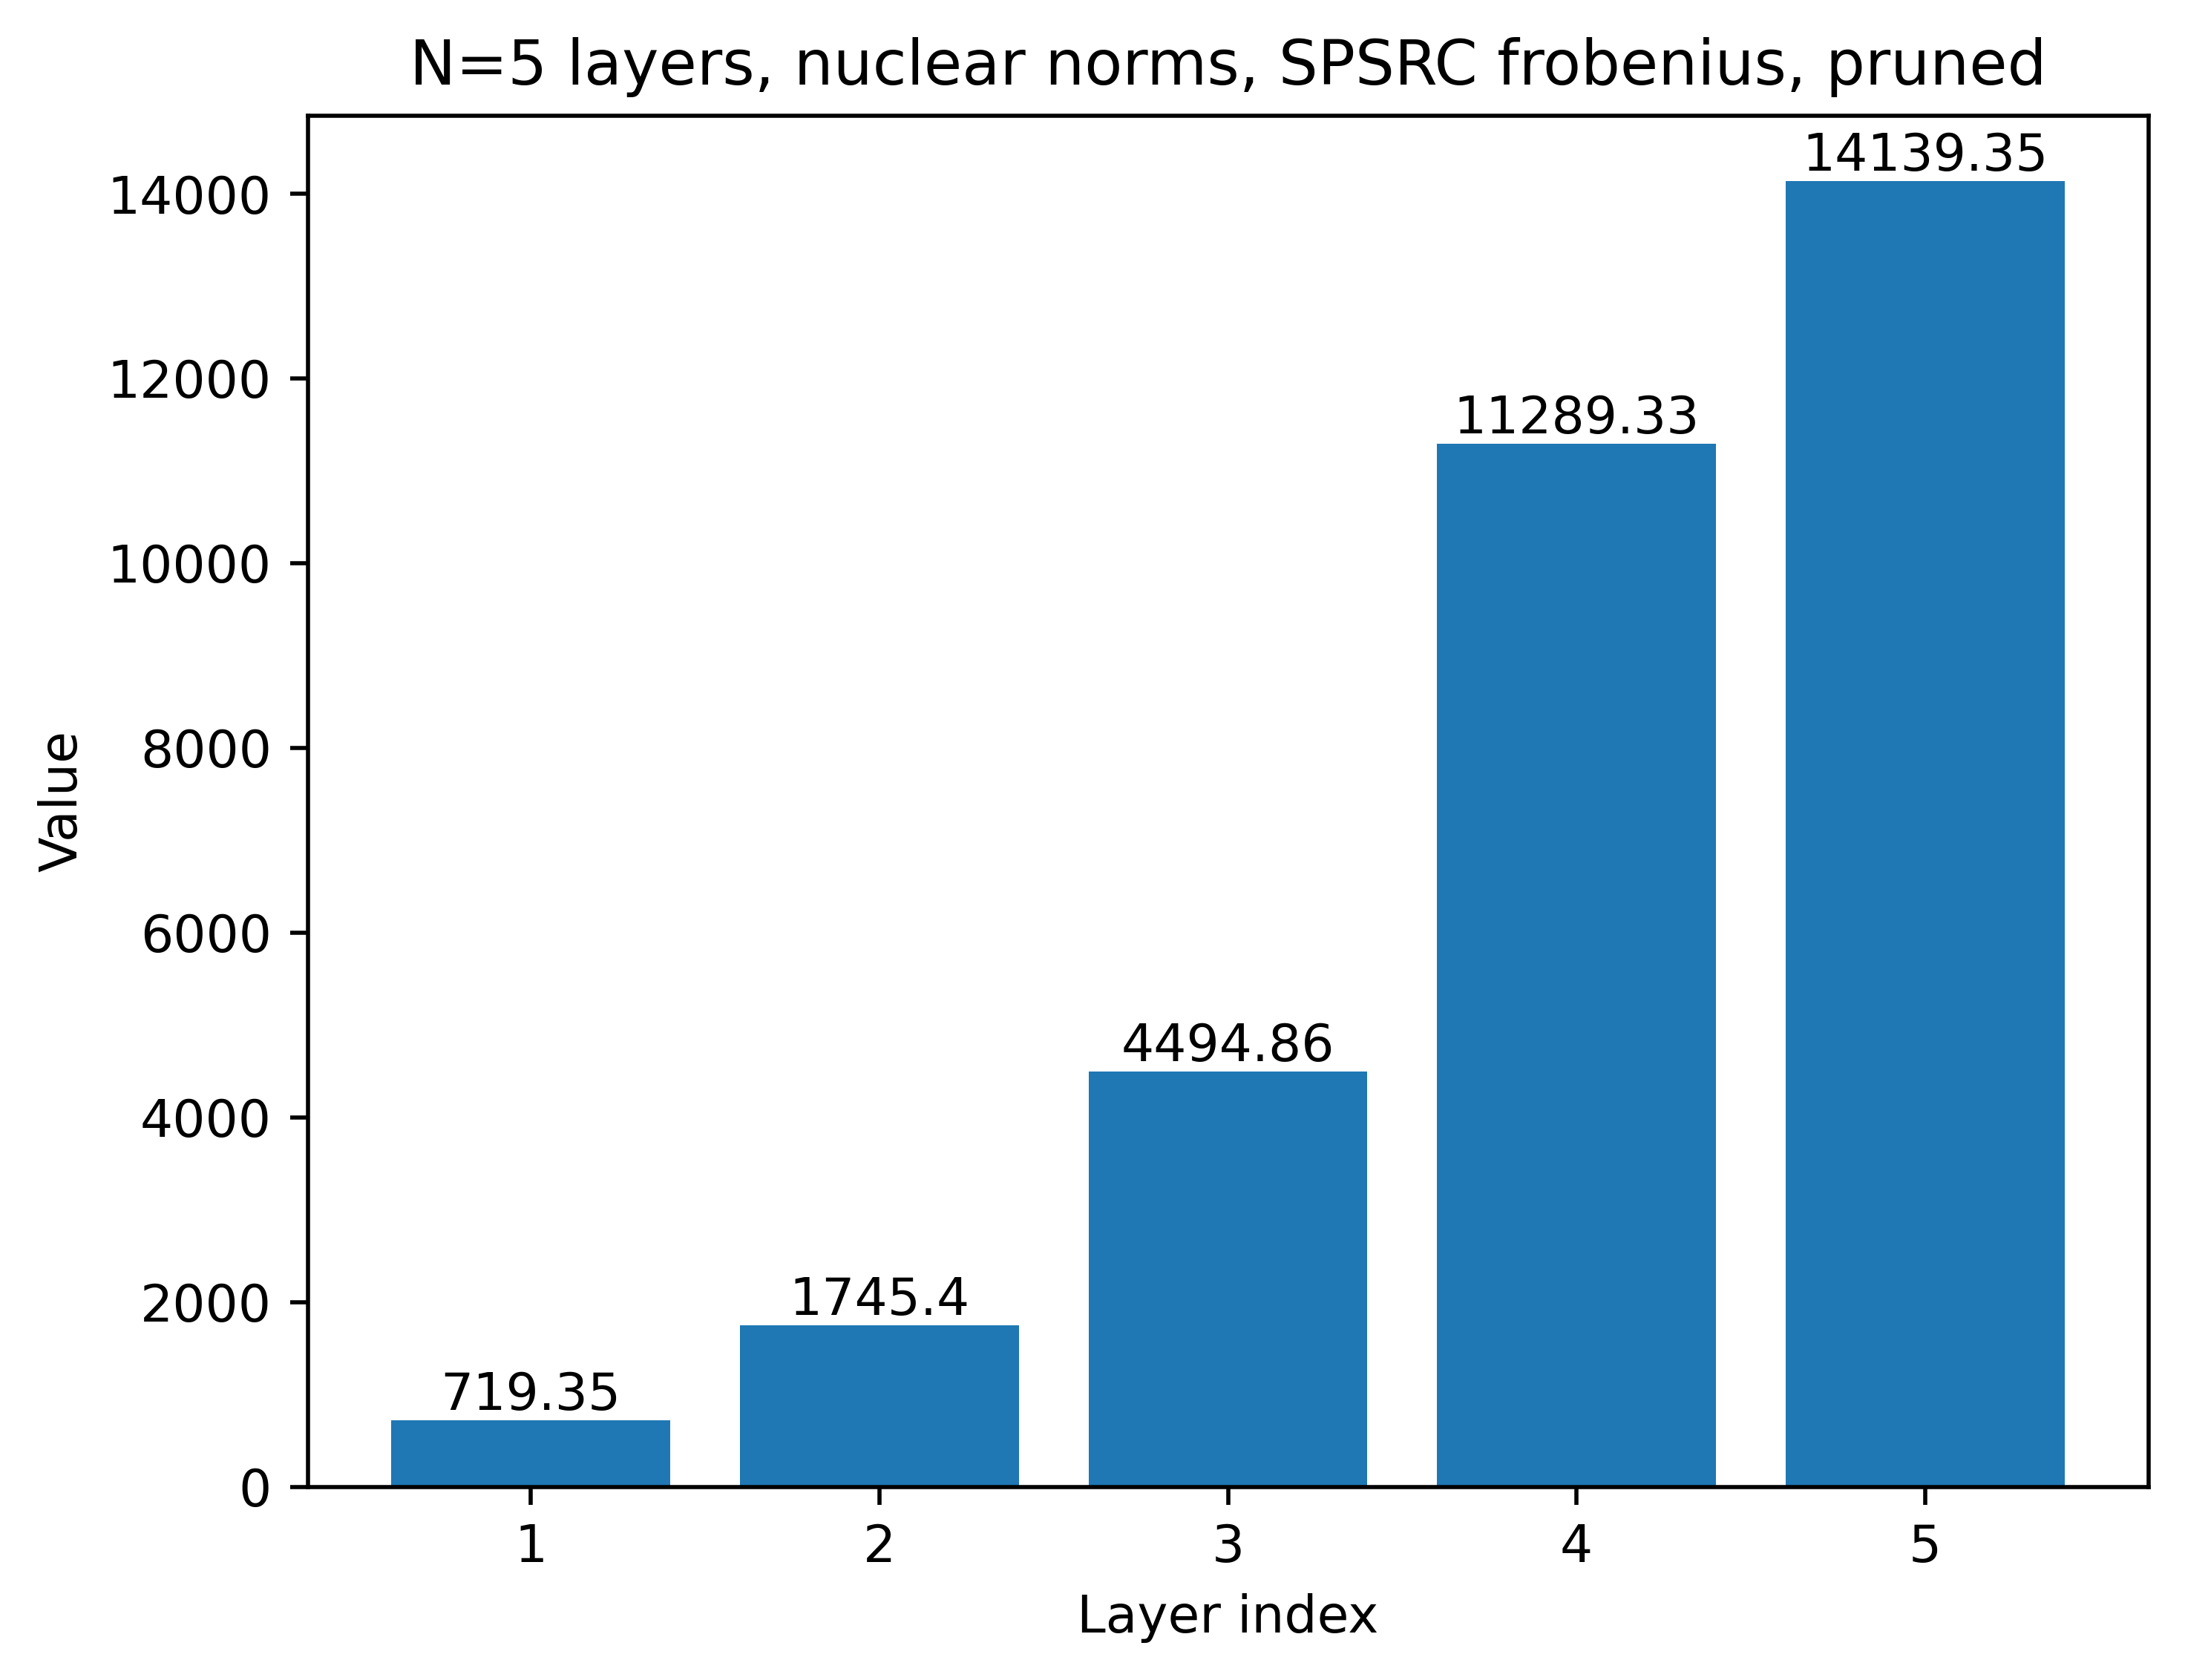

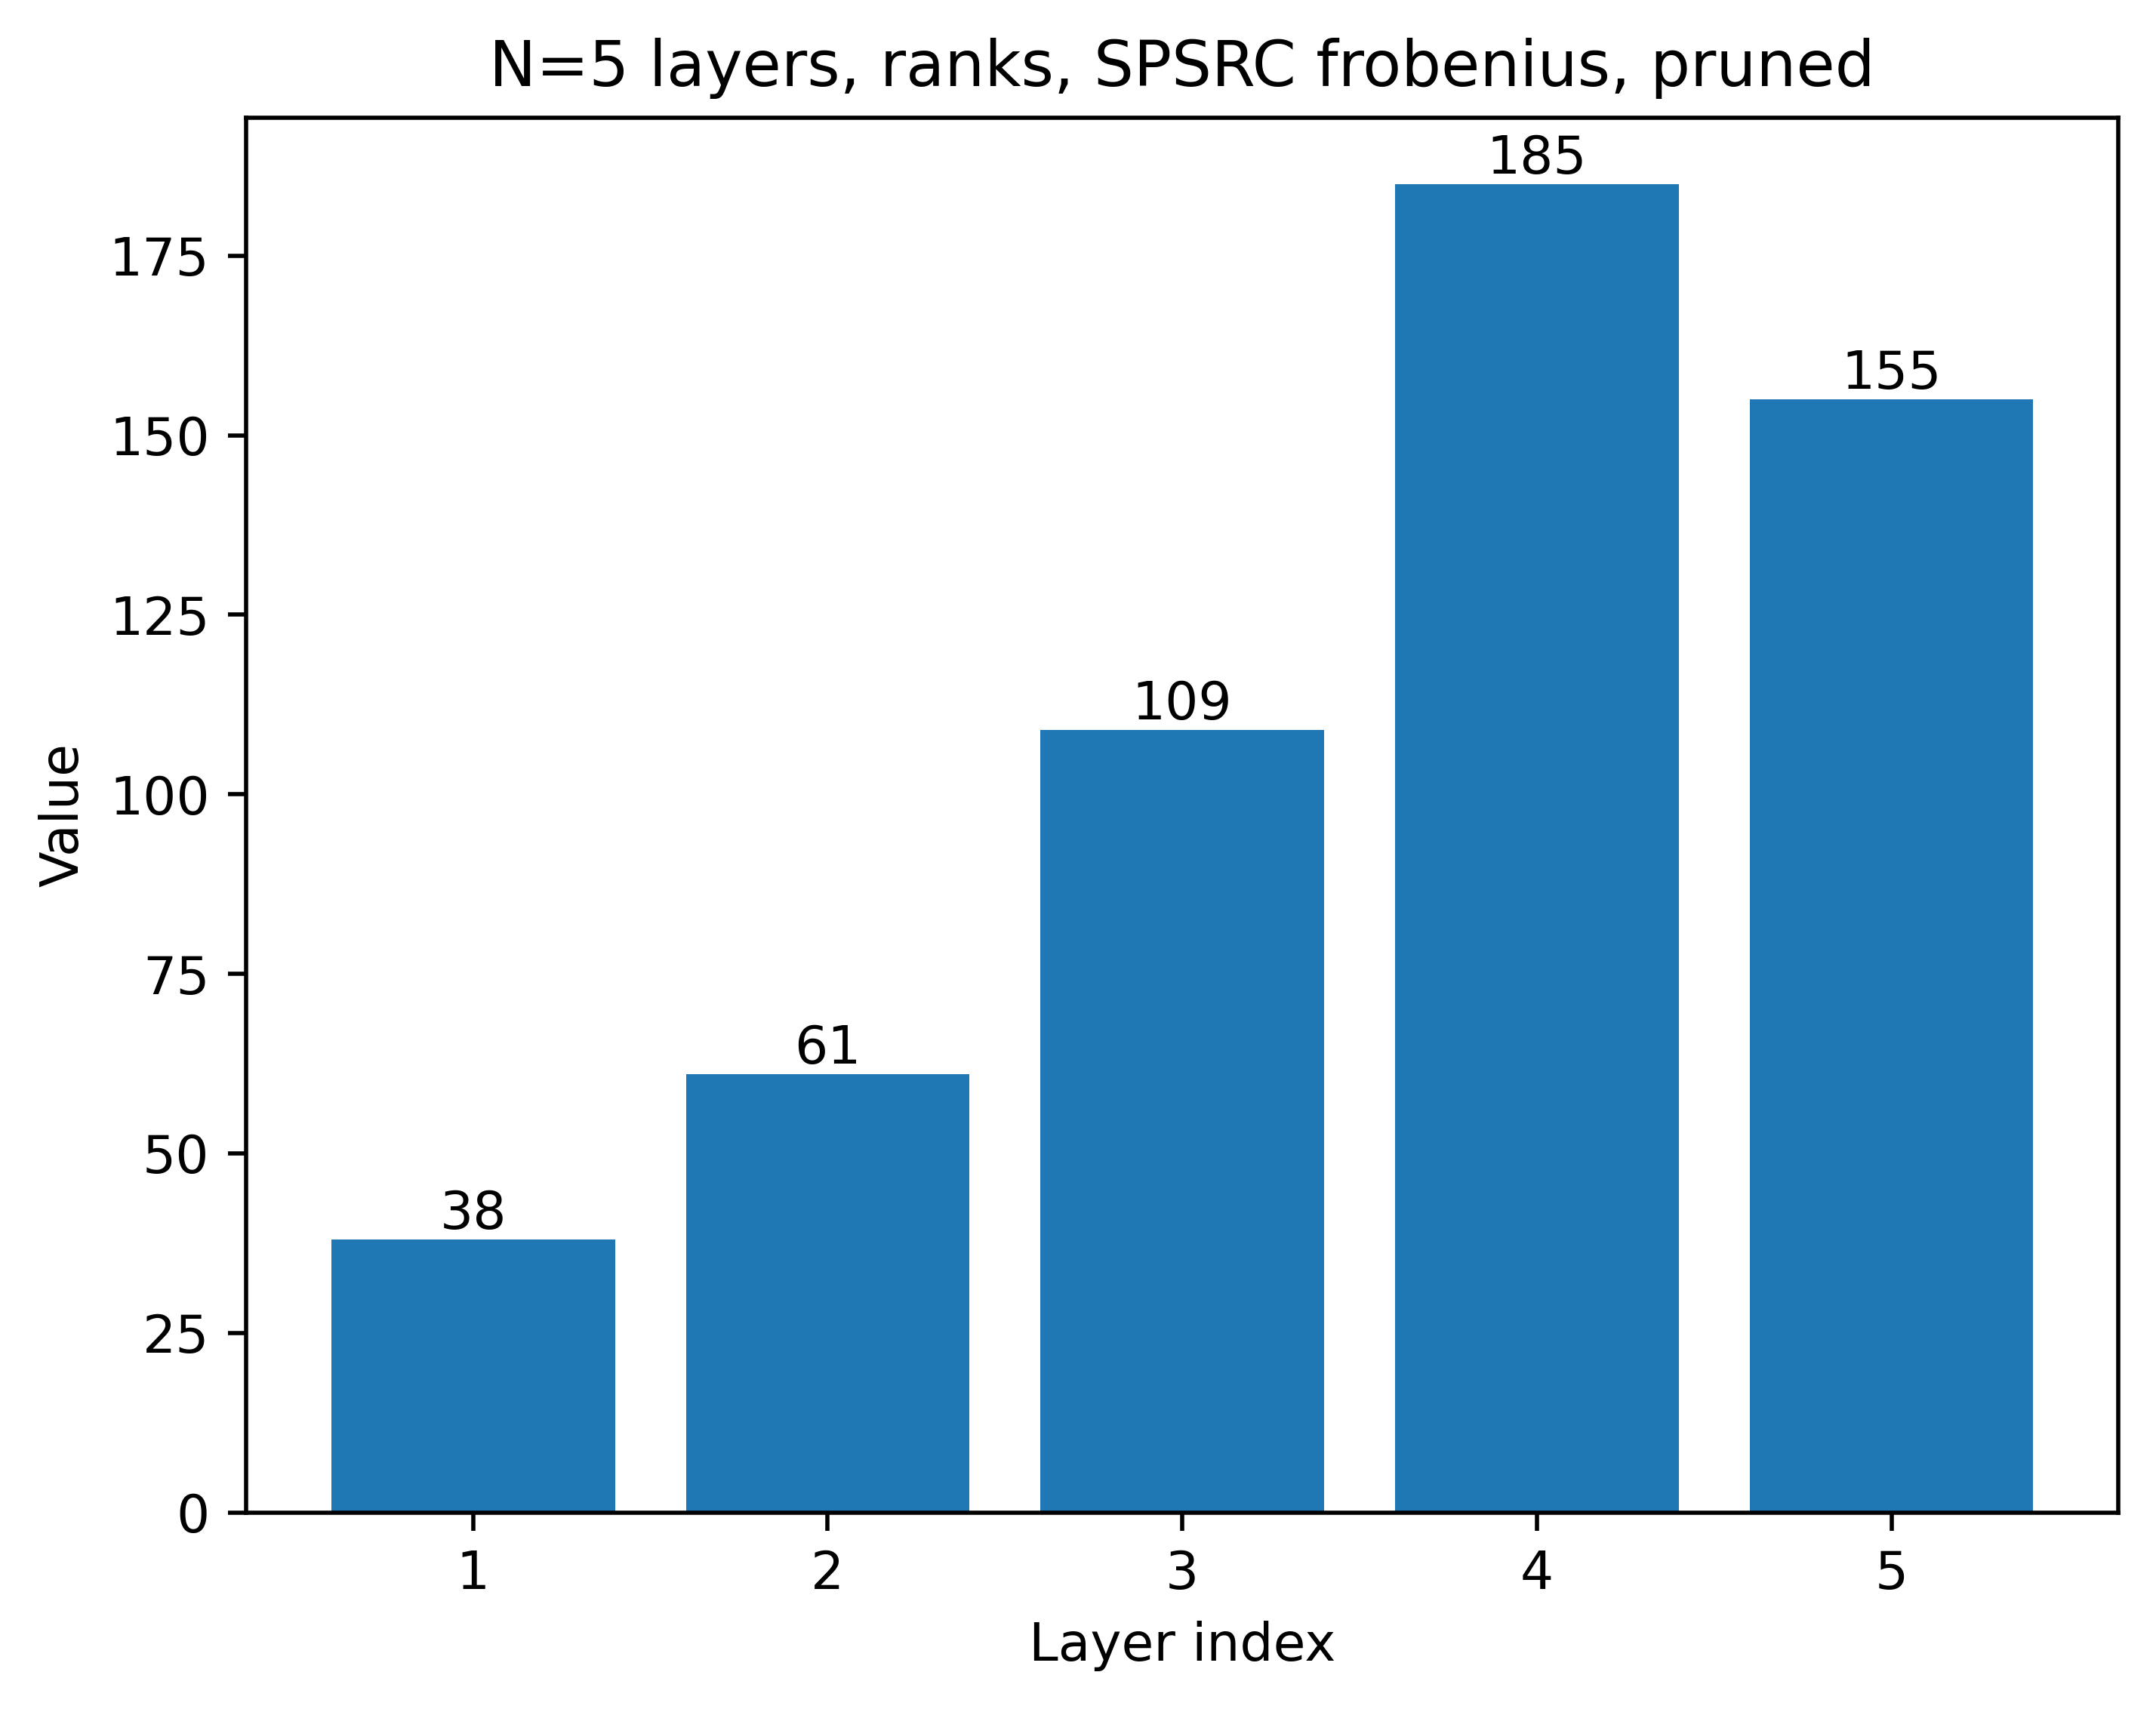

np.sum(nuclear_norms) 32388.29052734375


In [21]:
spsrc_frobenius_pruned_layers = apply_spsrc_to_layers(
    vgg_layers, optimal_channels, criterion="frobenius"
)
(
    spsrc_frobenius_singular_values,
    spsrc_frobenius_nuclear_norms,
    spsrc_frobenius_ranks,
) = inspect_layers(spsrc_frobenius_pruned_layers, name="SPSRC frobenius, pruned")

## GEM

In [22]:
import copy
from tqdm import tqdm


def remove_least_salient_filter(tensor, remaining_indice):
    """
    Compute the saliency of each filter in a tensor.
    Return the index of the least salient one and the pruned tensor.
    """
    full_nuclear_norm = nuclear_norm(tensor[remaining_indice])
    num_filters = len(remaining_indice)
    least_saliency = float("inf")
    least_saliency_index = 0
    pruned_tensor = None
    best_remaining_indice = None

    for i in remaining_indice:
        remaining_indice_copy = copy.deepcopy(remaining_indice)
        remaining_indice_copy.remove(i)
        remaining = tensor[remaining_indice_copy]
        saliency = full_nuclear_norm - nuclear_norm(remaining)
        if saliency < least_saliency:
            least_saliency = saliency
            least_saliency_index = i
            best_remaining_indice = remaining_indice_copy

    return least_saliency_index, best_remaining_indice


def reduce_filters(tensor, num_filters_to_keep):
    """
    Reduce the number of filters in a tensor to num_filters_to_keep
    using the least saliency greedy approach.
    """
    remaining_tensor = tensor.clone()
    num_filters = tensor.size(0)
    remaining_indice = list(range(num_filters))
    removed_indice = []

    for _ in tqdm(range(num_filters - num_filters_to_keep)):
        removed_index, remaining_indice = remove_least_salient_filter(
            tensor, remaining_indice
        )
        removed_indice.append(removed_index)

    print(f"Removed {len(removed_indice)} filters with indices: {removed_indice}")
    print(f"Kept {len(remaining_indice)} filters with indices: {remaining_indice}")
    remaining_tensor = tensor[remaining_indice]

    return remaining_indice, remaining_tensor


def apply_least_saliency_to_layers(vgg_layers, optimal_channels):
    """
    Apply the least saliency approach to reduce the number of filters in each layer.
    """
    new_layers = []

    for layer_tensor, num_filters_to_keep in zip(vgg_layers, optimal_channels):
        print(
            f"Current layer: layer_tensor.shape={layer_tensor.shape}, num_filters_to_keep={num_filters_to_keep}"
        )
        remaining_indice, pruned_tensor = reduce_filters(
            layer_tensor, num_filters_to_keep
        )
        new_layers.append(pruned_tensor)

    return new_layers

Current layer: layer_tensor.shape=torch.Size([64, 32, 3, 3]), num_filters_to_keep=48


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 20.58it/s]


Removed 16 filters with indices: [60, 7, 0, 9, 14, 13, 56, 11, 6, 15, 5, 3, 2, 10, 4, 49]
Kept 48 filters with indices: [1, 8, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63]
Current layer: layer_tensor.shape=torch.Size([128, 64, 3, 3]), num_filters_to_keep=90


100%|██████████| 38/38 [00:09<00:00,  3.96it/s]


Removed 38 filters with indices: [4, 11, 17, 34, 2, 95, 28, 111, 19, 10, 36, 18, 20, 8, 90, 22, 25, 7, 121, 93, 6, 14, 26, 113, 27, 120, 29, 13, 16, 125, 33, 105, 1, 32, 9, 12, 37, 24]
Kept 90 filters with indices: [0, 3, 5, 15, 21, 23, 30, 31, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 112, 114, 115, 116, 117, 118, 119, 122, 123, 124, 126, 127]
Current layer: layer_tensor.shape=torch.Size([256, 128, 3, 3]), num_filters_to_keep=166


100%|██████████| 90/90 [02:26<00:00,  1.63s/it]


Removed 90 filters with indices: [203, 17, 79, 38, 26, 45, 6, 39, 253, 186, 184, 86, 10, 77, 76, 74, 36, 89, 65, 23, 236, 31, 42, 35, 54, 5, 248, 9, 8, 28, 30, 83, 58, 75, 11, 12, 80, 46, 64, 228, 43, 50, 69, 169, 187, 73, 7, 61, 71, 188, 52, 182, 40, 68, 55, 213, 34, 56, 25, 238, 207, 49, 44, 84, 51, 53, 2, 63, 78, 59, 67, 1, 254, 170, 57, 32, 27, 48, 190, 251, 81, 60, 29, 185, 14, 13, 66, 15, 0, 199]
Kept 166 filters with indices: [3, 4, 16, 18, 19, 20, 21, 22, 24, 33, 37, 41, 47, 62, 70, 72, 82, 85, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 189, 191, 192, 193, 194, 195, 196, 197,

100%|██████████| 205/205 [43:41<00:00, 12.79s/it]


Removed 205 filters with indices: [189, 55, 365, 85, 15, 404, 75, 176, 386, 155, 356, 80, 139, 152, 180, 23, 138, 307, 203, 115, 110, 193, 149, 113, 16, 56, 439, 400, 30, 118, 314, 172, 167, 6, 17, 164, 495, 78, 168, 94, 96, 440, 103, 74, 107, 131, 154, 88, 52, 199, 153, 202, 99, 53, 376, 36, 82, 121, 141, 319, 379, 435, 426, 127, 34, 469, 39, 170, 165, 112, 32, 18, 136, 102, 54, 178, 108, 143, 137, 86, 148, 184, 68, 501, 398, 183, 66, 160, 38, 182, 63, 190, 64, 396, 51, 77, 197, 442, 41, 114, 83, 130, 25, 169, 1, 129, 174, 37, 449, 24, 95, 13, 430, 29, 349, 433, 484, 59, 67, 9, 196, 195, 48, 464, 87, 494, 50, 478, 342, 329, 71, 65, 158, 62, 31, 427, 192, 44, 318, 412, 311, 47, 159, 140, 150, 156, 20, 26, 98, 146, 161, 61, 144, 104, 175, 57, 33, 116, 2, 310, 45, 70, 507, 81, 186, 101, 317, 407, 335, 46, 134, 508, 166, 486, 8, 429, 40, 505, 321, 125, 185, 124, 109, 424, 163, 350, 106, 511, 73, 454, 145, 326, 60, 334, 111, 92, 480, 90, 5, 191, 76, 181, 151, 84, 21]
Kept 307 filters with 

100%|██████████| 230/230 [1:12:47<00:00, 18.99s/it]


Removed 230 filters with indices: [114, 57, 215, 359, 376, 375, 126, 23, 298, 20, 213, 502, 148, 46, 210, 47, 448, 433, 35, 496, 61, 412, 145, 195, 347, 75, 174, 15, 26, 156, 91, 143, 327, 155, 24, 85, 179, 30, 144, 223, 318, 471, 404, 37, 3, 32, 192, 467, 194, 311, 507, 399, 335, 38, 116, 41, 158, 203, 187, 149, 510, 351, 221, 159, 400, 482, 494, 51, 128, 161, 123, 10, 92, 481, 184, 293, 86, 98, 1, 153, 102, 22, 222, 90, 74, 511, 4, 67, 386, 204, 87, 18, 81, 27, 31, 78, 454, 97, 70, 119, 422, 190, 25, 202, 419, 68, 411, 178, 186, 157, 150, 168, 181, 169, 378, 498, 219, 489, 134, 138, 483, 89, 470, 103, 82, 407, 84, 177, 180, 197, 458, 79, 19, 402, 7, 142, 113, 183, 88, 453, 49, 127, 478, 28, 208, 60, 362, 198, 109, 133, 147, 152, 56, 509, 21, 115, 165, 62, 205, 455, 321, 33, 493, 105, 107, 111, 182, 40, 284, 428, 294, 209, 436, 388, 42, 442, 423, 17, 354, 63, 390, 406, 193, 413, 170, 217, 135, 162, 54, 164, 34, 282, 83, 71, 287, 14, 206, 58, 163, 382, 44, 110, 348, 13, 334, 43, 224, 6

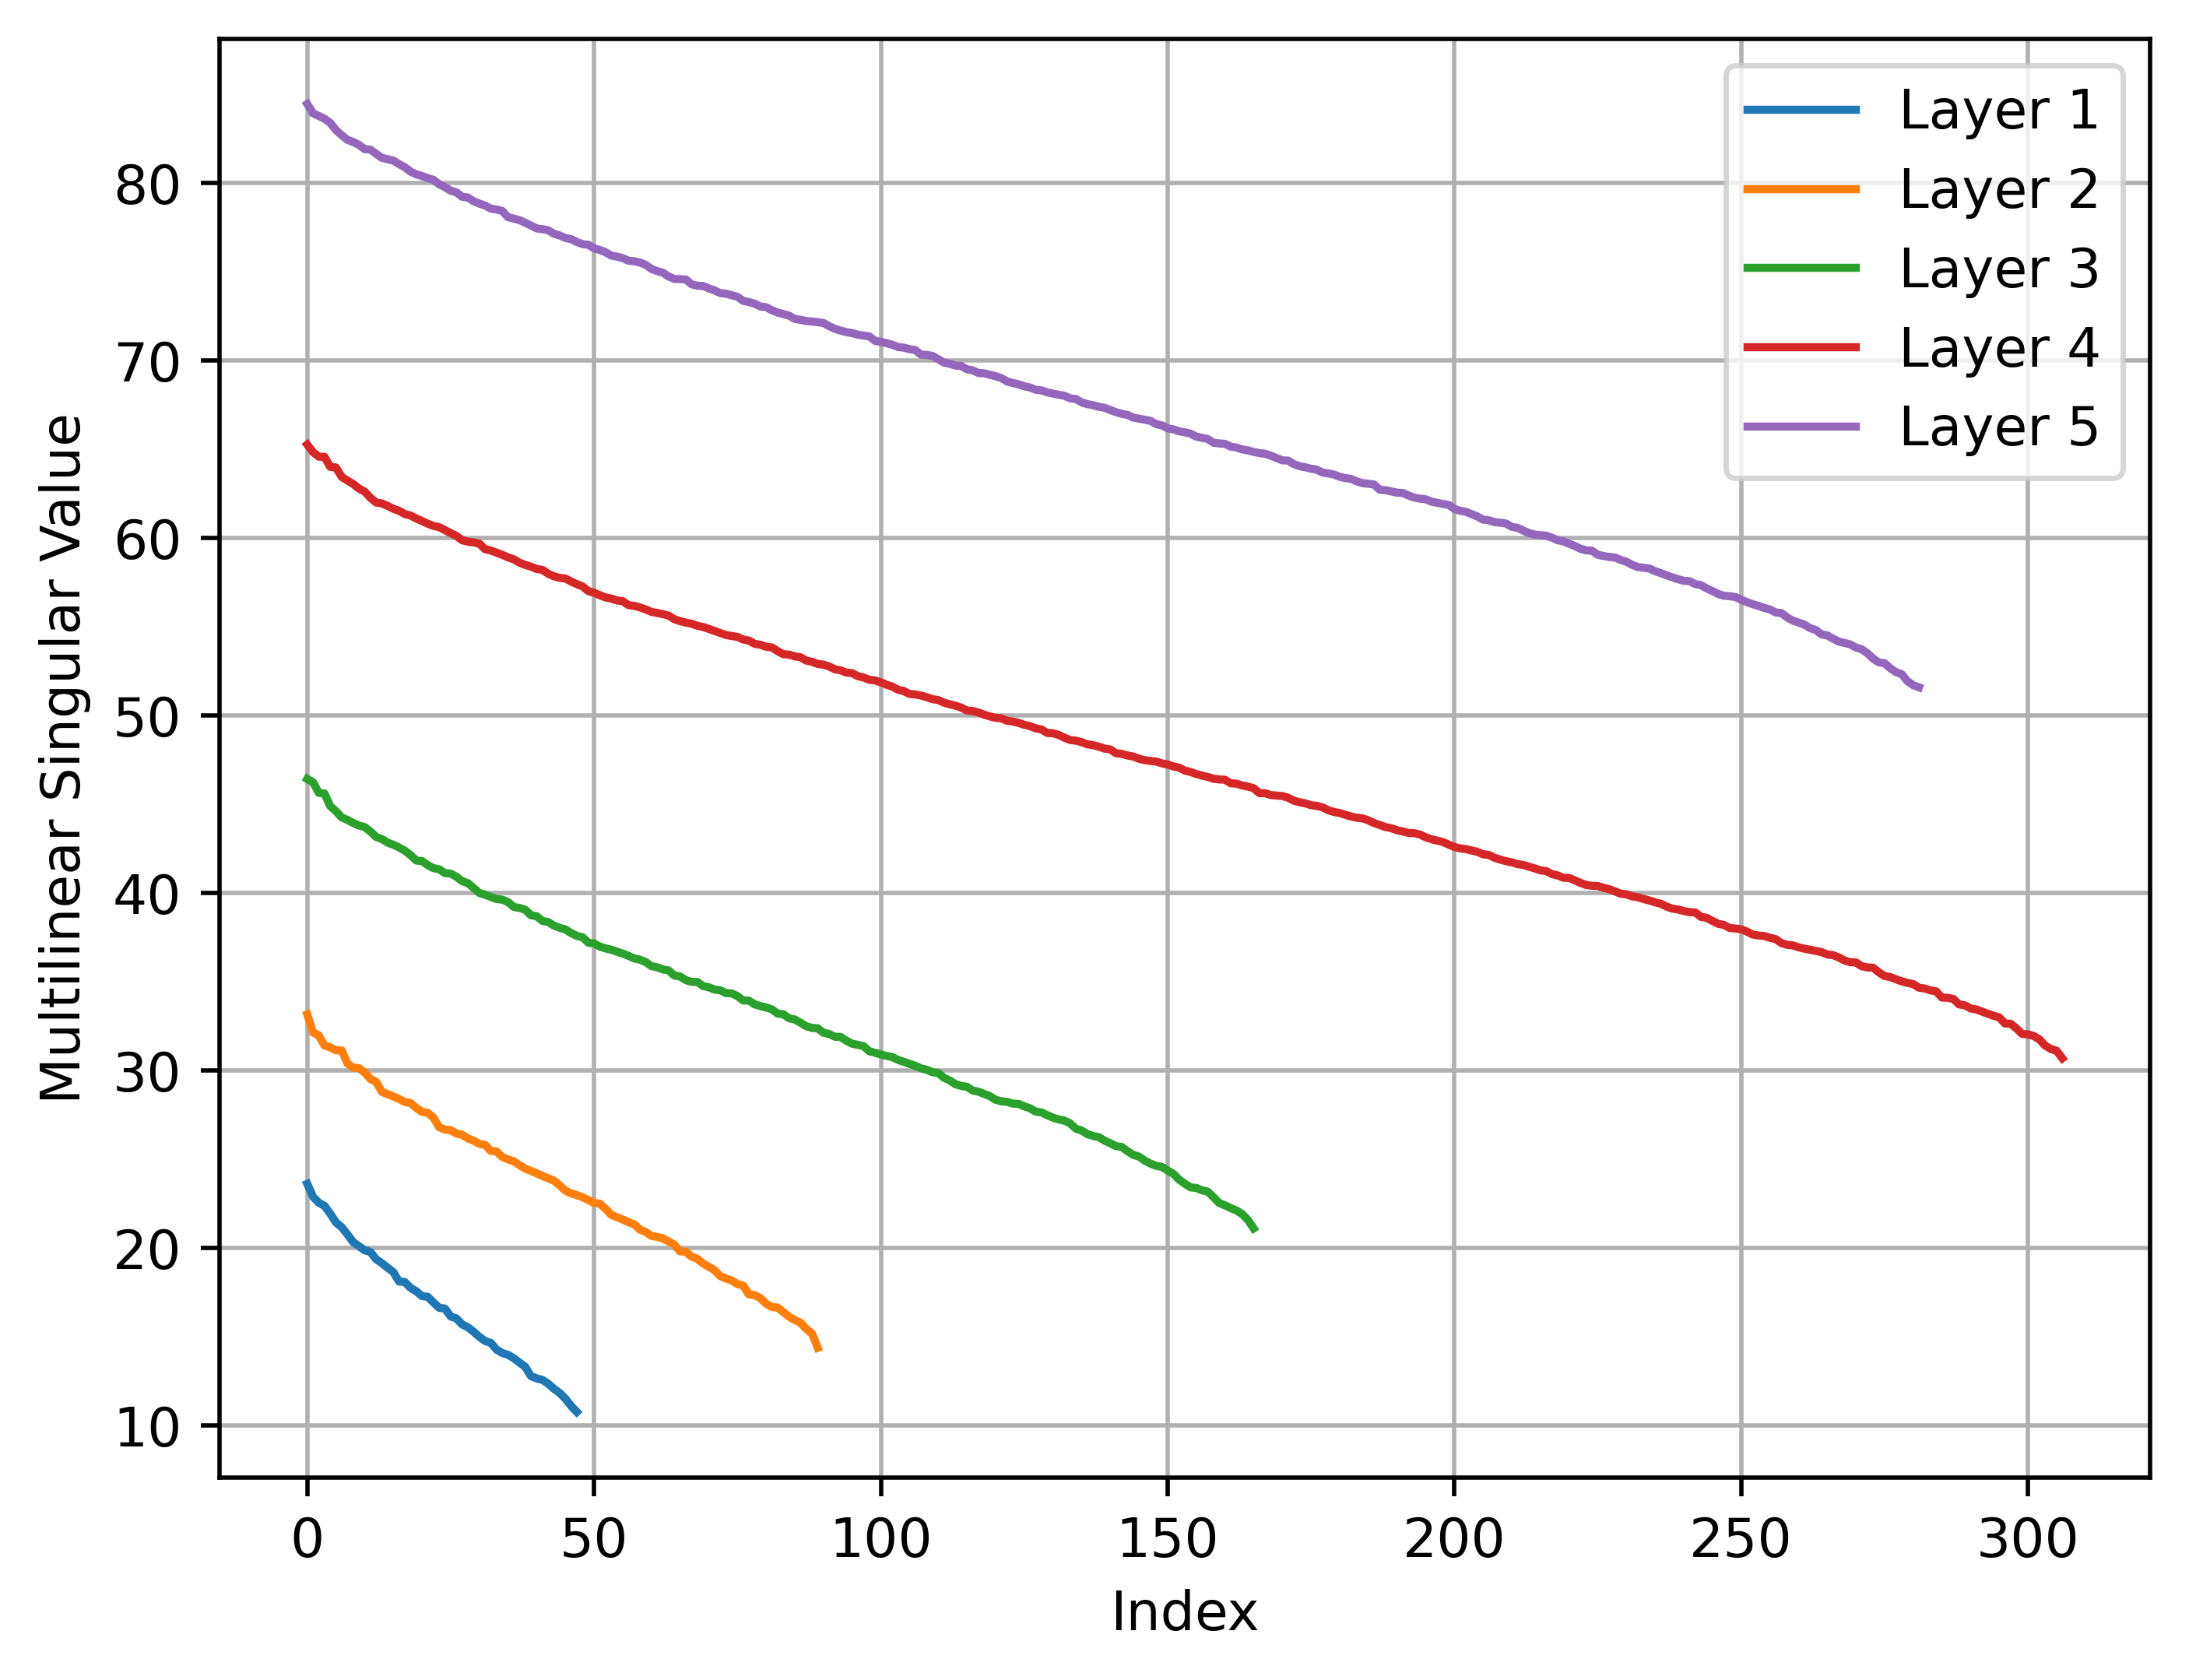

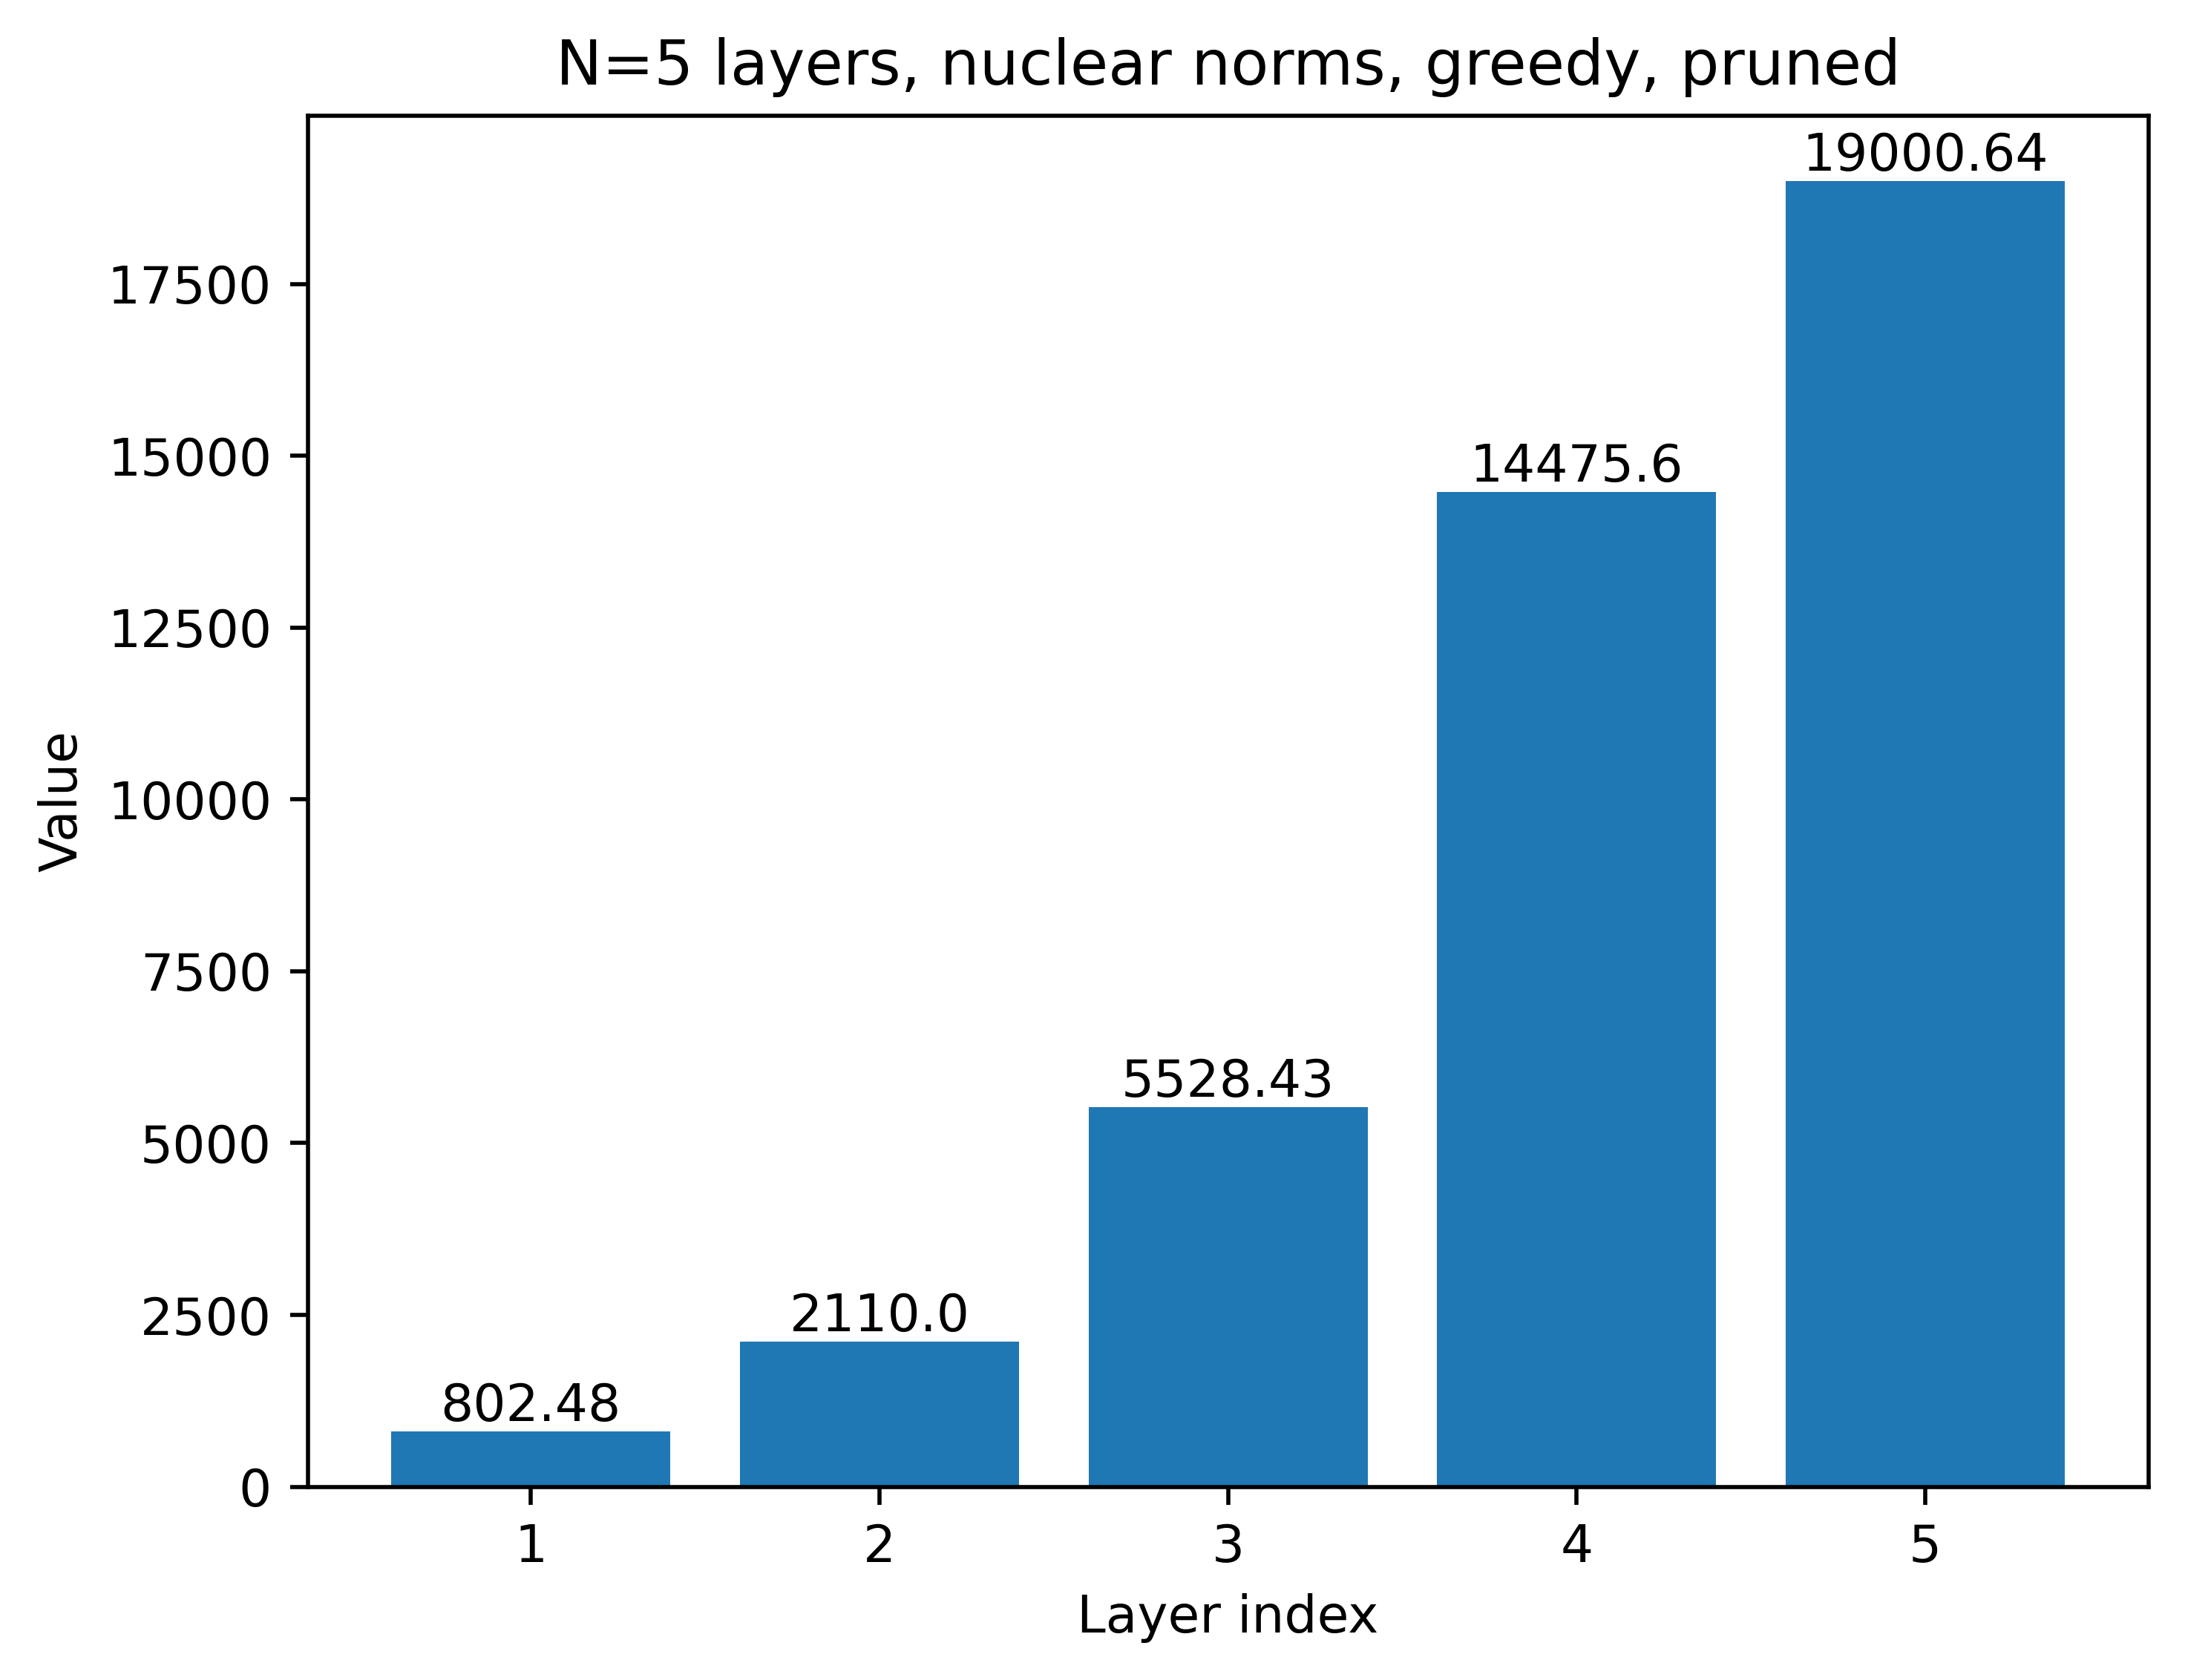

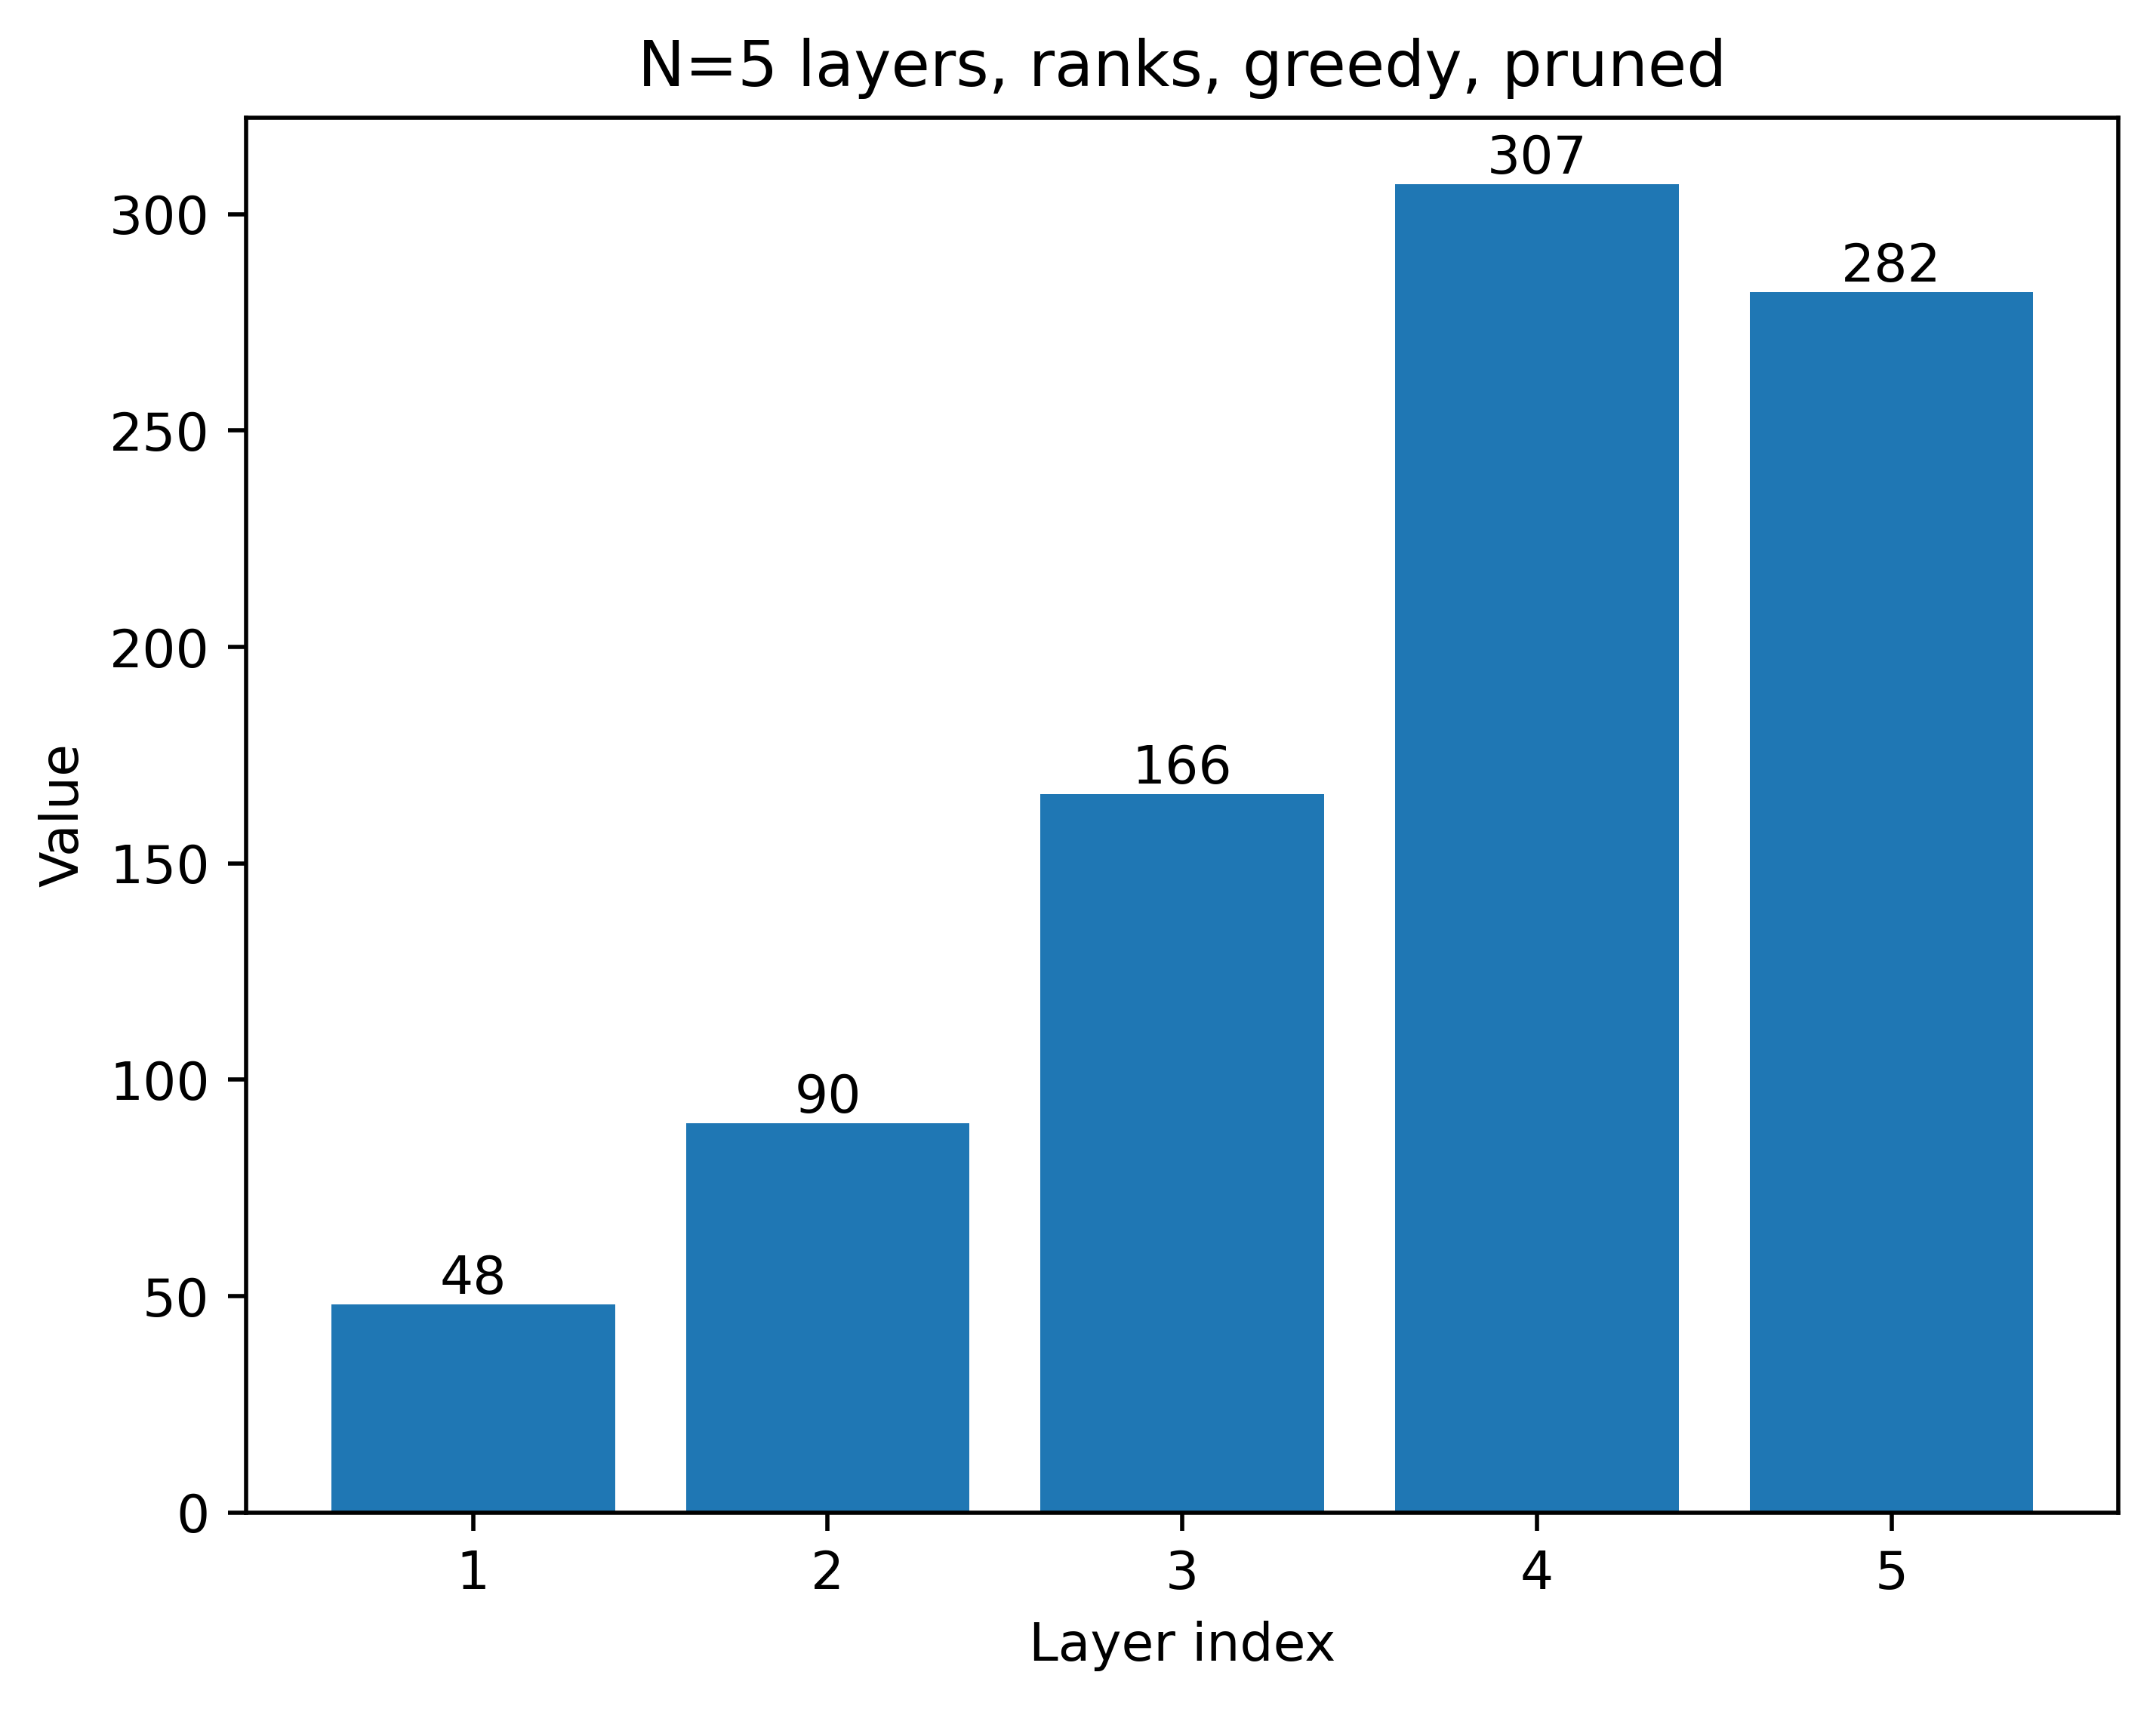

np.sum(nuclear_norms) 41917.15002441406


In [23]:
greedy_vgg_layers = apply_least_saliency_to_layers(vgg_layers, optimal_channels)
greedy_singular_values, greedy_nuclear_norms, greedy_ranks = inspect_layers(
    greedy_vgg_layers, name="greedy, pruned"
)